### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate


import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python.           {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python.           3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-10-19 13:18:25,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_dba2970730', 'finish_reason': 'stop', 'logprobs': None}, id='run-948e92e0-eb72-4158-a5ab-ca6c03dd6b5f-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-10-19 13:18:25,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templants (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-10-19 13:18:26,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-10-19 13:18:26,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-10-19 13:18:27,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-10-19 13:18:28,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifica e ti amo.

2024-10-19 13:18:29,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.

Elapsed seconds: 4.123532


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-10-19 13:18:30,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-19 13:18:30,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-19 13:18:30,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-19 13:18:31,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-19 13:18:31,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.657398
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifica e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [9]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
do_download = True


In [10]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [11]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [12]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [13]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [15]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict()
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [16]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [17]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [18]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [19]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [20]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [21]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict()
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [22]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [23]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [24]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    log(f"Proposed categories: {state['cluster_topics']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [25]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [27]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [28]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [30]:
# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [31]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [32]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_state)

# Define LangGraph agent state graph

In [33]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-10-19 12:45:42,864 - AInewsbot - INFO - Initializing with before_date=2024-10-18 11:00:00, do_download=True, thread_id=55cd0ea9b36d49c2aabd55668f7af45d


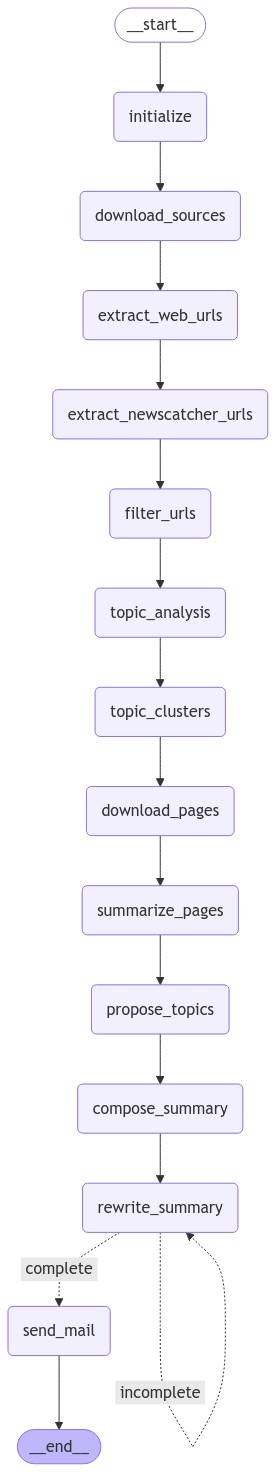

In [35]:
do_download = True
before_date = None
# before_date="2024-10-18 11:00:00"

# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
state["n_edits"] = 0
state["edit_complete"] = False

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [36]:
state = lg_agent.initialize(state)


2024-10-19 12:45:49,321 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-19 12:45:49,322 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-19 12:45:49,322 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-19 12:45:49,323 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-19 12:45:49,323 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-19 12:45:49,323 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-19 12:45:49,324 - AInewsbot - INFO - 

In [37]:
state = lg_agent.download_sources(state)


2024-10-19 12:45:53,278 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-10-19 12:45:53,304 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:45:53,307 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:45:53,307 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:45:53,307 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:46:10,561 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:46:10,561 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:46:10,561 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:46:10,561 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:46:10,562 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-19 12:46:10,562 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-19 12:46:10,562 - AInewsbot - INFO -

2024-10-19 12:47:20,055 - AInewsbot - INFO - get_files(New York Times Technology) - starting get_files https://www.nytimes.com/section/technology
2024-10-19 12:47:27,492 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-19 12:47:27,493 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence) - Saving Google News - Technology - Artificial intelligence (10_19_2024 12_47_27 PM).html as utf-8
2024-10-19 12:47:27,496 - AInewsbot - INFO - Processing Reddit
2024-10-19 12:47:27,496

2024-10-19 12:48:08,026 - AInewsbot - INFO - get_files(Washington Post Technology) - Saving Washington Post Technology (10_19_2024 12_48_08 PM).html as utf-8
2024-10-19 12:48:08,031 - AInewsbot - INFO - Quit webdriver
2024-10-19 12:48:12,536 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-19 12:48:22,573 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-19 12:48:22,575 - AInewsbot - INFO - get_files(Feedly AI) - Saving Feedly AI (10_19_2024 12_48_22 PM).h

In [38]:
state = lg_agent.extract_web_urls(state)


2024-10-19 12:48:24,404 - AInewsbot - INFO - Parsing html files
2024-10-19 12:48:24,404 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_19_2024 12_47_01 PM).html
2024-10-19 12:48:24,473 - AInewsbot - INFO - parse_file - found 203 raw links
2024-10-19 12:48:24,476 - AInewsbot - INFO - parse_file - found 31 filtered links
2024-10-19 12:48:24,477 - AInewsbot - INFO - 31 links found
2024-10-19 12:48:24,477 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_19_2024 12_47_06 PM).html
2024-10-19 12:48:24,497 - AInewsbot - INFO - parse_file - found 202 raw links
2024-10-19 12:48:24,500 - AInewsbot - INFO - parse_file - found 14 filtered links
2024-10-19 12:48:24,500 - AInewsbot - INFO - 14 links found
2024-10-19 12:48:24,500 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_19_2024 12_47_09 PM).html
2024-10-19 12:48:24,524 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-19 12:48:24,528 - AInewsbot - INFO - parse_file 

In [39]:
# s/b 17 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


17


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,51
FT Tech,55
Feedly AI,71
Google News,60
Hacker News,27
Hacker News 2,21
HackerNoon,97


In [40]:
state = lg_agent.extract_newscatcher_urls(state)


2024-10-19 12:48:25,307 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


In [41]:
state = lg_agent.filter_urls(state)


2024-10-19 12:48:25,966 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-10-18 11:00:00'
2024-10-19 12:48:26,647 - AInewsbot - INFO - URLs in orig_df: 1024
2024-10-19 12:48:26,650 - AInewsbot - INFO - Existing URLs in DB: 165030
2024-10-19 12:48:26,683 - AInewsbot - INFO - New URLs in df filtered by URL: 358
2024-10-19 12:48:26,769 - AInewsbot - INFO - Existing src+title: 7
2024-10-19 12:48:26,770 - AInewsbot - INFO - New URLs in df filtered by src+title: 351
2024-10-19 12:48:26,781 - AInewsbot - INFO - Found 330 unique new headlines
2024-10-19 12:48:26,933 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-10-19 12:48:26,934 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:26,934 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:26,935 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:26,935 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:26,936 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:26,936 - AInewsbot - I

In [42]:
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


,id
src,
Ars Technica,2
Bloomberg Tech,1
Business Insider,2
FT Tech,1
Feedly AI,53
Google News,20
Hacker News,2
HackerNoon,8
Newscatcher,43


In [43]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. 01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls (Eleanor Olcott/Financial Times) - Feedly AI](https://t.co/OjoP4jYT5c)

[1. 10 AI Prompts to Turbocharge Your Job Search - Feedly AI](https://www.forbes.com/sites/jeremyschifeling/2024/10/19/10-ai-prompts-to-turbocharge-your-job-search/)

[2. 4 ways AI could negatively impact the 2024 election - Newscatcher](https://www.fastcompany.com/91210933/ai-impact-2024-election)

[3. AI, crypto and data privacy: Comparing Harris, Trump on technology regulation - Newscatcher](https://www.yahoo.com/news/ai-crypto-data-privacy-comparing-133847347.html)

[4. AI-generated art piece disqualified by SC State Fair after being awarded cash prize - Newscatcher](https://www.yahoo.com/news/ai-generated-art-piece-disqualified-173231172.html)

[5. AI-generated child abuse images increasing at 'chilling' rate - as watchdog warns it is now becoming hard to spot - Feedly AI](https://news.sky.com/story/ai-generated-child-abuse-images-increasing-at-chilling-rate-as-watchdog-warns-it-is-now-becoming-hard-to-spot-13235706)

[6. AI Coding Showdown: Claude Sonnet vs ChatGPT vs OpenAI o1 - Who Wins? - Feedly AI](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)

[7. AI Creates 'Generational Opportunity': Why Nvidia Analyst Says Stock Will Hit $190 - Newscatcher](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)

[8. AI Video Call Scams Are on the Rise, and This Is How They Work - Feedly AI](https://www.makeuseof.com/how-ai-video-call-scams-work/)

[9. AI for business process intelligence: A sneak peak at Celosphere 2024 - Newscatcher](https://siliconangle.com/2024/10/18/ai-process-intelligence-celonis-automation-celosphere)

[10. AI humanoid robot defends criticism that she can't be artistic - Newscatcher](https://www.cnn.com/2024/10/18/science/video/ai-humanoid-robot-painting-stewart-contd-digvid)

[11. Agent-as-a-Judge: An Advanced AI Framework for Scalable and Accurate Evaluation of AI Systems Through Continuous Feedback and Human-level Judgments - Feedly AI](https://www.marktechpost.com/2024/10/18/agent-as-a-judge-an-advanced-ai-framework-for-scalable-and-accurate-evaluation-of-ai-systems-through-continuous-feedback-and-human-level-judgments/)

[12. A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future (Todd Bishop/GeekWire) - Feedly AI](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)

[13. All System Prompts For Anthropics Claude , Revealed - Google News](https://news.google.com/read/CBMiigFBVV95cUxOdzFYTnNPNEpLdGMwdVh0cE9kRF9ReExiS1M2aE11dG14UmlUdjBfbTZsUk9uek1mRFZ3VHNuWVMwbmdRdmp0d2o1Skl5RXRMMVJQcWtWT1dVbm14LTBCUXczVUE0VE5uRFJtblN0a3F4Q0w1TGFPM2hPLW9rNXkweEZPd0c3R0Fod2c)

[14. A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - Techmeme](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)

[15. Anthropic just announced major Claude AI update  heres everything thats new - Google News](https://news.google.com/read/CBMipgFBVV95cUxOT1k3S3ZVb2ZLcUh6VHRYUXlqRXRFSmFYNDNOOTZiWWdLTllyLXRabWE1Z1NZNVd3OS1aMUxkNFBrVmM2OXV1S3dMZzQ5a1Q4NGxiVXZlbnlIWTg2eVFNQ0V6d29WVV94dmtNVFNyUDVUeGt5bmZxWTRfX0o3UnZBa3RWSWEwQ3Q0SjFFMmpielFOOE41VjRRWkk5R1c3b1NZWjkxR0p3)

[16. AskBobby: The AI Tool Helping People in Need Locate Social Services - HackerNoon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)

[17. Astera Labs Inc (ALAB) Unveils Industry's First PCIe 6 Switch, Revolutionizing AI Infrastructure with Scorpio Smart Fabric Switch Portfolio - Newscatcher](https://ca.finance.yahoo.com/news/astera-labs-inc-alab-unveils-204442497.html)

[18. Bullfrog AI Announces Pricing of Registered Direct Offering and Concurrent Private Placement for Aggregate Gross Proceeds of $3.13 Million - Newscatcher](https://finance.yahoo.com/news/bullfrog-ai-announces-pricing-registered-133000030.html)

[19. Causal AI: Evolving from recognition to reasoning - Newscatcher](https://siliconangle.com/2024/10/18/causal-ai-evolving-recognition-reasoning-cubeconversations)

[20. ChatGPT's Name Bias and Apple's Findings on AI's Lack of Reasoning - Feedly AI](https://medium.com/@researchgraph/chatgpts-name-bias-and-apple-s-findings-on-ai-s-lack-of-reasoning-major-flaws-revealed-b4a44c27fd75)

[21. Chatbot hack shows why you shouldn't trust AI with your personal data - Feedly AI](https://bgr.com/tech/chatbot-hack-shows-why-you-shouldnt-trust-ai-with-your-personal-data/)

[22. Chinese AI groups get creative to drive down cost of models - FT Tech](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)

[23. Claude: Everything you need to know about Anthropics AI - Feedly AI](https://techcrunch.com/2024/10/19/claude-everything-you-need-to-know-about-anthropics-ai/)

[24. Claude AI: Unboxing Anthropics LLM-based AI Assistant, Artifacts & Use Cases - Google News](https://news.google.com/read/CBMinwFBVV95cUxOa0VNSkZvUjlkVF9BNnMzdHVUNnB1b2JpUm52WnNyWGVaUHJWYkdMZXRPc3E4YjVnRG9YRUVhbkhpY3lEY0J5Wk9iczhYNjc2S2tValk5MFZ4R0tncW1lTXF6RTFNbVM2OXlQRFdfZE56em1zZUxFM1JjX2VCcGdXUDhuWmFwdW5qdEtCVnNxcTl5dWRzbFZMRjB6SEpGbGs)

[25. Congressional leaders negotiating potential lame-duck deal to address AI concerns - Google News](https://news.google.com/read/CBMieEFVX3lxTE14UWN3MjZ3OEZnTU00STFLUUZwRUVMbFRyR2U1OWJEMTVUanFZRUc4UEZuNjI4MDRqRm81YmdZRExSU2FvbzlUaFNTNzNZMXRSU2R0LVh1NUl0NUEyZ3JjWHVSX1laQmFHRElYUUFUbjlfT3pHeFBNMA)

[26. Department of Labor releases AI best practices for employers - Newscatcher](https://www.yahoo.com/news/department-labor-releases-ai-best-222510480.html)

[27. Enhanced climate change resilience on wheat anther morphology using optimized deep learning techniques - Feedly AI](https://www.nature.com/articles/s41598-024-74875-7)

[28. Enhancing AI Accuracy and Confidence in Answer Generation - Feedly AI](https://neurosciencenews.com/ai-llm-accuracy-27893/)

[29. Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Feedly AI](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

[30. Father Disgusted to Find His Murdered Daughter Was Brought Back as an AI - Feedly AI](https://futurism.com/murdered-daughter-brought-back-as-ai)

[31. Former OpenAI technology chief Mira Murati to raise capital for new AI startup, sources say - Google News](https://news.google.com/read/CBMi5AFBVV95cUxQMHN1YUdxSlFzMURxNEMyellUblRvUzF4dGlyamR3VkFwU0RTUHVGRV83c1Jaa01OQUptUlBEdDlsaUxqcE04TWJhTWZaNGJmWmJReDI3UUNfRkZ0UkNZR0NRc1pyX3poYzY3VXEyRFROR1BPQWYwYU9CR0s0Y3ZlbEx6eWIzTkdkUHk4NE55RE1JTmd5Yzl1cEhtMzB3YUlGV2MwVngteV9KNUI3VXdxRzU3QnFINlMwRnBkUUFWSzZvTzkySHduRWtsWEVsLWdZbFpUcnRrZlh2UkszREtpa0R5Q28)

[32. Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)

[33. Google Unveils Sample What You Cant Compress in AIA Game-Changer in High-Fidelity Image Compression - Feedly AI](https://www.marktechpost.com/2024/10/19/google-unveils-sample-what-you-cant-compress-in-ai-a-game-changer-in-high-fidelity-image-compression/)

[34. Google licences diabetic retinopathy AI model to partners in APAC - Newscatcher](https://finance.yahoo.com/news/google-licences-diabetic-retinopathy-ai-150335183.html)

[35. Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)

[36. Got a Cool Idea for an AI Bot? Heres How It Could Win You $3000 in the #AI-Chatbot Writing Contest - HackerNoon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-$3000-in-the-ai-chatbot-writing-contest)

[37. Harris vs. Trump: Their Stance on AI and Cryptocurrency Regulations - Feedly AI](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)

[38. HeartFlow Announces New Category I CPT Code from the American Medical Association for AI-Enabled Plaque Analysis to Assess Risk for Coronary Artery Disease - Newscatcher](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)

[39. Herbie Hancock on AI, Kamala Harris, and the Kendrick Lamar collab that never was - Newscatcher](https://www.scmp.com/postmag/culture/article/3282841/herbie-hancock-ai-snoop-dogg-and-kendrick-lamar-collab-never-happened-and-kamala-harris-president)

[40. Heres Why Critics Are Raising Eyebrows Over Sam Altmans Iris-Scanning Crypto Project - Feedly AI](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)

[41. Hopes and fears for AI at work - Feedly AI](https://rapidcityjournal.com/hopes-and-fears-for-ai-at-work/article_83e2b052-2175-5214-a1a0-2dfb094c9122.html)

[42. How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)

[43. How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - HackerNoon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)

[44. How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions (Wall Street Journal) - Feedly AI](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)

[45. How can AI augment rather than dictate human action? This expert explains - Feedly AI](https://www.weforum.org/agenda/2024/10/ai-augment-rather-than-dictate-human-action/)

[46. INOVAIT reveals Canada's strategic advantages in image-guided therapy and artificial intelligence in latest report - Newscatcher](https://finance.yahoo.com/news/inovait-reveals-canadas-strategic-advantages-154700391.html)

[47. I created an AI clone of myself and the result was unintentionally hilarious - Feedly AI](https://www.techradar.com/computing/artificial-intelligence/i-created-an-ai-clone-of-myself-and-the-result-was-unintentionally-hilarious)

[48. I dumped Google for AI search alternatives like Perplexity and ChatGPT - Feedly AI](https://www.androidpolice.com/i-dumped-google-search-for-ai/)

[49. InnoTech Forum: Hong Kong can evolve into an AI applications development hub - Newscatcher](https://www.scmp.com/tech/tech-trends/article/3283002/innotech-forum-hong-kong-has-potential-become-ai-applications-development-hub)

[50. Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short (Marah Eakin/Wired) - Feedly AI](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)

[51. Is Broadcom a Top Artificial Intelligence (AI) Stock to Buy Right Now? - Newscatcher](https://finance.yahoo.com/news/broadcom-top-artificial-intelligence-ai-110000564.html)

[52. It's not even Halloween, but AI is already getting spooky - Feedly AI](https://www.laptopmag.com/ai/its-not-even-halloween-but-ai-is-already-getting-spooky)

[53. Looking to Buy Your First AI Stock? This Is the Best Choice (Hint: It's Not Nvidia). - Google News](https://news.google.com/read/CBMifEFVX3lxTFBMSDhoSjVjdHRTS2FVS2lEeDhHeldHN1ItVndlOXFVWFdPX25tREtScDhNWE5yUGRsMVQ4WXpJcVphMkRiTVhQWjlMeHdxcUVEZk9Oby1ia01tNXA5SG9QZGdYNUs2dS1EalZLYmFscjF2MGhDbThrNi0xQUE)

[54. Meta AI Releases Meta Lingua: A Minimal and Fast LLM Training and Inference Library for Research - Feedly AI](https://www.marktechpost.com/2024/10/18/meta-ai-releases-meta-lingua-a-minimal-and-fast-llm-training-and-inference-library-for-research/)

[55. Meta AI in WhatsApp may soon remember your likes and dislikes - Feedly AI](https://www.androidauthority.com/meta-ai-whatsapp-memory-3492224/)

[56. Meta Extends Pilot Program for AI Video Creation Tools into 2025 - Newscatcher](https://finance.yahoo.com/news/meta-extends-pilot-program-ai-210942397.html)

[57. Meta Platforms (NASDAQ:META) Releases a Series of New AI Models - Newscatcher](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)

[58. Meta Releases AI Model That Can Check Other AI Models' Work - Newscatcher](https://www.gadgets360.com/ai/news/meta-ai-release-check-other-models-work-6823539)

[59. Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - Techmeme](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

[60. Microsoft Open-Sources bitnet.cpp: A Super-Efficient 1-bit LLM Inference Framework that Runs Directly on CPUs - Feedly AI](https://www.marktechpost.com/2024/10/18/microsoft-open-sources-bitnet-cpp-a-super-efficient-1-bit-llm-inference-framework-that-runs-directly-on-cpus/)

[61. Microsoft could end up with substantial equity in the restructured, for-profit OpenAI - Feedly AI](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)

[62. Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - HackerNoon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)

[63. New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - HackerNoon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)

[64. New JAMA channel highlights AI's role in medicine - Newscatcher](https://www.msn.com/en-us/health/other/new-jama-channel-highlights-ai-s-role-in-medicine/ar-AA1sxTdE)

[65. New JAMA channel highlights AIs role in medicine - Feedly AI](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)

[66. News - Penguin Random House underscores copyright protection in AI rebuff - Google News](https://news.google.com/read/CBMiowFBVV95cUxPWWNRQ1ZTd2R5ZW0waGlvbnJsa3lrNkNkUUdNcWtPaDNvVGE3NE9Bakc2UVZEbHJHdEFUS09mdDdWdng0ZEdzbkwtQ2lsZDQxdk1VSGNhTGFVeUxGME4tMjBHVTRPWmxlR1ZHOFVnbWRCYWpEMG14ai1YZkZ0UFUzdnJtN1JPZUpySU9oa2drM2lfZnpmWDVFcmxzWnlBQ0ZKM3dz)

[67. Nobel Prizes and AI: The Promise, the Peril, and the Path Forward  Communications of the ACM - Feedly AI](https://cacm.acm.org/blogcacm/nobel-prizes-and-ai-the-promise-the-peril-and-the-path-forward/)

[68. Nokia Integrates AI into Altiplano Access Controller for Enhanced Network Automation - Newscatcher](https://telecomtalk.info/nokia-integrates-ai-into-altiplano-access-controller/983411)

[69. NotebookLM is Googles Own ChatGPT Moment - Feedly AI](https://analyticsindiamag.com/ai-insights-analysis/notebooklm-is-googles-chatgpt-moment/)

[70. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Feedly AI](https://www.cnbc.com/2024/10/19/hlth-2024-tech-companies-head-to-las-vegas-to-tout-health-ai-tools-.html)

[71. OpenAI, Microsoft reportedly hire banks to renegotiate partnership terms - Newscatcher](https://siliconangle.com/2024/10/18/openai-microsoft-reportedly-hire-banks-renegotiate-partnership-terms)

[72. OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)

[73. OpenAIs Newest Possible Threat: Ex-CTO Murati; Googles Mini-ChatGPT Moment - Google News](https://news.google.com/read/CBMisgFBVV95cUxPaWVnSnluejYtRzBRTWhCY2NEYVJVcVVvUDRvalRwNXpsOTdvT29ocldveU1iVzIwa2NfbFg3SGx2Y3VjcnQ2MGNWRFlvOTFkWnhBWkREVkNuTHJOREk4M2JyZFBnaTRVb3dCeWNjSmQxZEVUb1I1MmlEOE1uSDd3QjBab2doVjFQTThjVkJraEZyZi1Gakc1UXpVSV9yYUVacUJDeldNWFczSmZQOUwxa3NR)

[74. OpenAIs research organization in upheaval, The Information reports - Google News](https://news.google.com/read/CBMipgFBVV95cUxPTllrZnJobEJpcjFTeldTU0dDUDBsT2FhdzUySnl0QmNNbGlkMnFGS29Xb3Bhb2N6S184ZTA3LW5pRGRIeGU4QU80VHhiRjE2dDZhci15NWNPcGF5REY0TGR2QmNPZmVwRlBDMEFCeVJzOVBESXhsRXAydDdVZU9XUFluemJhbTZxSWNGcVQyQjBNZnhmaS05cmp6ZUhVTTB1bklJLVlR)

[75. OpenAIs revolving door risk factor - Google News](https://news.google.com/read/CBMidEFVX3lxTE1zOTRXWHdXTFIxX0RUODVZd04wd19tTXE5TW5jMUhiZUNVTV9BbVRXbzZYTWN4N1F2R0ZkZDR0bVNNanA0U0NGM0p6ZDItZ3N3MFl6UGdsaGQ1QW9PMjBTaC1mb2h3T040V1owckxCWm9NMTV0)

[76. Opinion - The 3 major decisions the next Congress must make about AI policy - Newscatcher](https://www.yahoo.com/news/opinion-3-major-decisions-next-143000600.html)

[77. Parents sue school over son's punishment for using AI, claim it's harmed his college chances - Feedly AI](https://www.techspot.com/news/105192-parents-sue-school-over-son-punishment-using-ai.html)

[78. Penguin Adds a Do-Not-Scrape-for-AI Page to Its Books - Google News](https://news.google.com/read/CBMijAFBVV95cUxOMGZOUGJsUGNfai1Od0VaU2xWWDdGMm81ZHd2czJBRnFBblFvSTJRUENBUjdXLTl5VV9lenJsUXM1Um1raDV6R1A5R0poUlpha1RwaW5BR1o4S1BUSEMzd3FIaHJfbG90ZnM5aGpKQ0JiZzBRcGF6YmJ3YjVjQzUxYTI3SFE2WWVkMlZ2MA)

[79. Penguin Random House Underscores Copyright Protection in AI Rebuff - Newscatcher](https://tech.slashdot.org/story/24/10/19/0121240/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)

[80. Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - Techmeme](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)

[81. Penguin Random House amends its copyright rules to protect authors from AI - Google News](https://news.google.com/read/CBMiuAFBVV95cUxQRGl3S0I0SnJCSjYtMnVTZ2VfNHB5SXlmRjhETmd1cGxEWHJUUVJrb1FEaDJqTXJhNE84SHVJWE5rWXJ6VzFnbFU2WnlPV2F3S0o3OUttUjQwcHJWRVZZV2tybHJsdTZIdGJCUDJLbWlzTm9RR194WWlNMkhTWlp3TlJITmZ1NERlb2JUTmRSdks3VmVUb3NubnZlQUt4a1BzX3RKYXduTHJWTVR6a3lDM2FhR1dDVklK)

[82. Penguin Random House books now explicitly say no to AI training - Google News](https://news.google.com/read/CBMijAFBVV95cUxPalMyWTZfUThabm42ZVlCQVRaX2hKb0w3ZFJsRGtWcnFfMjY5MXVabXFjSjdfS21IOTY5NFZjU01BbUlBOU0yZjVyajRaYmV2VE9aSjIzbUdVNzhHOWFCcUVvSzUzYlZGQXRHZzBXSW80RzZvSmRzQkd3WFZVSjJRSlpSZFhTVERmZWt0WA)

[83. Penguin Random House copyright pages will now forbid AI training - Feedly AI](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

[84. PennWest launches Center for Artificial Intelligence and Emerging Technologies - Newscatcher](https://news.yahoo.com/news/tech/pennwest-launches-center-artificial-intelligence-134600528.html)

[85. Perplexity's AI search engine goes deep to get your answers - Feedly AI](https://www.techradar.com/computing/artificial-intelligence/perplexitys-ai-search-engine-goes-deep-to-get-your-answers)

[86. Perplexity AI Can Help You Make Millions, or Even Billions of Dollars - Google News](https://news.google.com/read/CBMivAFBVV95cUxPem51Rk1UM1dJTHNDTmVxcFlvRTc3SzRJWHRrT05TbnA4amtKcmVzaXBiWE5tc0VhQmdkekFDMG56RENzWDBFYTFpWFg3eVZ4Mnd3SDhSMnVKXzFqY05uU1hWQWlBTVB4b1N2MDJzemN4SXZpb0tBUV9LZGZnNVVPeFl2alJmNHBOX1YwT0lTVUQxa3NzT2pEQkh1UjJMUm5VMldJM29DOWFmNWxTcDBYRy1jWjh1cDU2X0NyYg)

[87. Perplexity lets you search your internal enterprise files and the web - Google News](https://news.google.com/read/CBMingFBVV95cUxQR2ZBNjBYTHpMMTlpcERnWDhmamU0YVlhdW1KQWNuMkpLMmNabk5DTE4xeGpfc2F1YXBZV0k4Nm9GdTAtVEJidWQyZDNCMUE1d1BJTENnQS1FNGd4djl1cmdQdTRHNWoyNnd1NkhyQWhKOVJjQTJ1XzJpMzZBVzVBeXBXNW8wV19iTTFYRE9Qd2E0ZFVGTlFnWG1FekpoZw)

[88. Phase 3 AI Will Make Chatbots Look Like Dial-Up Internet - Here's How to Prepare Your Business Now! - Feedly AI](https://www.entrepreneur.com/business-news/phase-3-ai-will-make-chatbots-look-like-dial-up-internet/481494)

[89. Pope Francis and the Vatican just created an AI Bible reshaping faith in the Digital Age - Feedly AI](https://www.thebrighterside.news/post/pope-francis-and-the-vatican-just-created-an-ai-bible-reshaping-faith-in-the-digital-age/)

[90. Protect AI Named 2024 SINET16 Innovator - Newscatcher](https://finance.yahoo.com/news/protect-ai-named-2024-sinet16-130300622.html)

[91. Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Theoretical Science - HackerNoon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)

[92. PyTorch 2.5 Unleashes High-End GPU Performance, Supercharges LLMs - Feedly AI](https://analyticsindiamag.com/ai-insights-analysis/pytorch-2-5-unleashes-high-end-gpu-performance-supercharges-llms/)

[93. Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready "connectivity cloud", internet balkanization, more (Om Malik/Crazy Stupid Tech) - Feedly AI](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)

[94. Ransomware protection: AI and strategies to combat rising threats - Newscatcher](https://siliconangle.com/2024/10/18/ransomware-protection-ai-strategies-rising-cyber-threats-cubeconversations)

[95. Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - Techmeme](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)

[96. Researchers develop method enabling LLMs to answer questions more concisely and accurately - Newscatcher](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)

[97. Sam Altman's Worldcoin Rebrand Now Calls It 'World,' Brings New Orb for Crypto Project - Feedly AI](https://www.techtimes.com/articles/307927/20241019/sam-altmans-worldcoin-rebrand-now-calls-it-world-brings-new-orb-crypto-project.htm)

[98. Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)

[99. Scammers swindle elderly California man out of $25K by using AI voice technology to claim his son was in 'horrible accident,' needed money for bail: 'Absolutely his voice' - Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)

[100. Scientists have built an AI-powered 'electronic tongue' - Feedly AI](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)

[101. Self-learning AI gives out NFL against the spread, over-under, money-line picks for every Week 7, 2024 game - Feedly AI](https://www.cbssports.com/nfl/news/self-learning-ai-gives-out-nfl-against-the-spread-over-under-money-line-picks-for-every-week-7-2024-game/)

[102. SentinelOne, Inc. (S) Upgraded by Piper Sandler as AI-Powered Purple AI Platform Drives Q2 Outperformance and Market Share Gains - Newscatcher](https://finance.yahoo.com/news/sentinelone-inc-upgraded-piper-sandler-212814293.html)

[103. SentinelOne Expands Collaboration with AWS, Enhancing AI-Powered Cybersecurity Solutions - Newscatcher](https://finance.yahoo.com/news/sentinelone-expands-collaboration-aws-enhancing-210950914.html)

[104. Show HN: How to leverage Claude's capabilities with interactive visualization - Hacker News](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)

[105. Solving complex problems with OpenAI o1 models - Feedly AI](https://openai.com/business/solving-complex-problems-with-openai-o1-models/)

[106. Sources: former OpenAI CTO Mira Murati is raising funds for her new startup, which aims to build AI products based on proprietary models - Techmeme](https://www.reuters.com/technology/artificial-intelligence/former-openai-technology-chief-mira-murati-raise-capital-new-ai-startup-sources-2024-10-18/)

[107. Southeast Asia reiterates pledge to collaborate amid growing cyber threats in AI era - Feedly AI](https://www.zdnet.com/article/southeast-asia-reiterates-pledge-to-collaborate-amid-growing-cyber-threat-in-ai-era/#ftag=RSSbaffb68)

[108. Study In UK: University of Sheffield Invites International Students For MSc Artificial Intelligence, Offering 10,000 Scholarships For 2025 - Newscatcher](https://www.msn.com/en-in/news/India/study-in-uk-university-of-sheffield-invites-international-students-for-msc-artificial-intelligence-offering-10-000-scholarships-for-2025/ar-AA1sxYzC)

[109. TREAT: A Deep Learning Framework that Achieves High-Precision Modeling for a Wide Range of Dynamical Systems by Injecting Time-Reversal Symmetry as an Inductive Bias - Feedly AI](https://www.marktechpost.com/2024/10/19/treat-a-deep-learning-framework-that-achieves-high-precision-modeling-for-a-wide-range-of-dynamical-systems-by-injecting-time-reversal-symmetry-as-an-inductive-bias/)

[110. Taming randomness in ML models with hypothesis testing and marimo - Hacker News](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)

[111. Tensions with OpenAI underscore Microsoft's need to ensure its own AI future - Newscatcher](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)

[112. Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a $120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - Techmeme](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)

[113. Tesla FSD crashes in fog, sun glareFeds open new safety investigation - Ars Technica](https://arstechnica.com/cars/2024/10/feds-open-their-14th-tesla-safety-investigation-this-time-for-fsd/)

[114. Tesla Facing NHTSA Investigation of 2.4 Million Cars Over Full Self-Driving Crashes - Newscatcher](https://ca.finance.yahoo.com/news/tesla-facing-nhtsa-investigation-2-151200159.html)

[115. Tesla software under investigation after collisions - Newscatcher](https://www.yahoo.com/news/tesla-software-under-investigation-collisions-134341068.html)

[116. The 3 major decisions the next Congress must make about AI policy - Newscatcher](https://thehill.com/opinion/technology/4939175-ai-regulatory-limbo-congress)

[117. The Age of AI Child Abuse Is Here - Google News](https://news.google.com/read/CBMikAFBVV95cUxPVFMtdXNWT3ZJbVZzSGtBWjZMX18yQ2pnWmZ6enREdUdsRFJ5N1JCUHhRanpyRzFaWi1pZ1VJOWlaXzdOLVlzRENQbHBZcTJ2UjRsNWVKbUUwWXpXa1BJOF9weWpZTzc0Y2s3T01yc3ZCNkowaVNsX2tRQnl4ZHJwbm9CbGhIZERORzFaRzgzVVY)

[118. The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg Tech](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)

[119. The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - HackerNoon](https://hackernoon.com/10-18-2024-newsletter)

[120. The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - HackerNoon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)

[121. The Pentagon Wants to Flood Social Media With Fake AI People - Feedly AI](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)

[122. The Return of Nuclear Energy Thanks to the AI Revolution - Feedly AI](https://greekreporter.com/2024/10/19/the-return-of-nuclear-energy-thanks-to-the-ai-revolution/)

[123. This AI Paper from Google DeepMind Explores Inference Scaling in Long-Context RAG - Feedly AI](https://www.marktechpost.com/2024/10/19/this-ai-paper-from-google-deepmind-explores-inference-scaling-in-long-context-rag/)

[124. This Expert Says AI Efficiency Soars When it Uses Video to Crunch Numbers - Feedly AI](https://www.inc.com/kit-eaton/this-expert-says-ai-efficiency-soars-when-it-uses-video-to-crunch-numbers/90991212)

[125. This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)

[126. Tired of ChatGPT? 5 incredible uses of Perplexity AI that trumps Google Search - Google News](https://news.google.com/read/CBMisgFBVV95cUxOTGFqdU1zZkI2WC1ZNWpwWHkyUUE2a2F5SEE4bnVhZ19fdlpSS20tal9xZERUcjE1ZWtiVXo1YlRCeHQwZUFZdWUyeTQ0NnFfMlJ3TTl0a2Z2ajVDMDVEOWdhaGx4d0hOZ3BwVTNYOGJnT2pTcmdwMUsxU3NlYUdCX0lKVTlNYUZoeExjOHFoM19zSHhJVUg1WjJwYjFIZXRZS0xXSVA1b2dmNkc5WXBHc29B)

[127. US Government Recovered $4 Billion Worth of Fraud With AI - Newscatcher](https://tech.co/news/us-govt-recovered-billions-fraud-ai)

[128. US Probes TSMC for Allegedly Helping Huawei Develop Smartphone, AI Chips for the Chinese Tech - Newscatcher](https://www.techtimes.com/articles/307928/20241019/us-probes-tsmc-allegedly-helping-huawei-develop-smartphone-ai-chips-chinese-tech.htm)

[129. US probing Elon Musk's Tesla over self-driving systems - Newscatcher](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)

[130. Ventura teen finds her voice lobbying for bill on AI child abuse - Google News](https://news.google.com/read/CBMirAFBVV95cUxQT1lXeW1fVEJ4emhmaGlUOEJqSkFtVVZaek9kNWhrQ0JpMjFvbVdQdGxpeUFpcUptUS1HeUQydEwxWWpoeHN2SkZyNGl5YlplYWlTOE52TUUzSWlFNmJFenlKeGJKNlVvSlI4eG9zT0NaWVE3bDVRSlliWHhuNW1VWnpKWlZ4SXRIeFp4MmZzMk9hM2hOMGRYNU9RMkJRY3ZyNUJjckFIS080Sjd4)

[131. Washington Journal: Cat Zakrzewski Discusses Artificial intelligence & Campaign 2024 - Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)

[132. Where Nvidia ranks among fastest-growing AI companies. No, its not No. 1. - Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)

[133. Why AI Success Still Appears So Elusive - Feedly AI](https://www.forbes.com/sites/joemckendrick/2024/10/19/why-ai-success-still-appears-so-elusive/)

[134. Why balancing Europes AI regulations is a difficult juggling act for start-ups - Feedly AI](https://www.euronews.com/next/2024/10/19/why-balancing-europes-ai-regulations-is-a-difficult-juggling-act-for-start-ups)

[135. X's new terms of service push lawsuits to Texas courts, allow third-party AI data-sharing - Newscatcher](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)

[136. X Is Giving Away Your Data to Train Third-Party AIs - Feedly AI](https://lifehacker.com/tech/x-is-selling-your-data-to-third-parties-for-ai-training)

[137. XYZ Media's 'Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology - Newscatcher](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)

[138. XYZ Media's Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology - Newscatcher](https://finance.yahoo.com/news/xyz-media-next-generation-innovators-034400241.html)

[139. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Feedly AI](https://www.techradar.com/computing/websites-apps/xs-controversial-changes-to-blocking-and-ai-training-sees-half-a-million-users-leave-for-rival-bluesky-which-then-crashes-under-the-strain)

[140. X to allow third parties to train AI on your posts - Newscatcher](https://mashable.com/article/x-train-ai-posts)

[141. X to allow third parties to train their AI models with social media users' data - Newscatcher](https://www.theregister.com/2024/10/18/x_train_data)

In [44]:
state = lg_agent.topic_analysis(state)


2024-10-19 12:48:31,507 - AInewsbot - INFO - start free-form topic extraction
2024-10-19 12:48:31,507 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:48:31,508 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:31,508 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:48:31,509 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:48:38,603 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:48:39,359 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:48:39,597 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:48:39,599 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:48:39,601 - AInewsbot - INFO - 142 free-form topics extracted
2024-10-19 12:48:39,605 - AInewsbot - INFO - ['cost reduction', 'harris', 'trump', 'child abuse', 'competition', 'chatgpt', 'openai', 'nvidia', 'investment', 'cybersecurity', 'fraud', 'microsoft', 'research', 'claude', 'anthropic', 'fundraising', 'apple', 'reasoning', 'chatbot', 'llm', 'congress', 

2024-10-19 12:49:18,416 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:49:18,417 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:49:21,273 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:49:21,687 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:49:21,762 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:49:21,764 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:49:21,765 - AInewsbot - INFO - China, topic 12 of 100
2024-10-19 12:49:21,767 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:49:21,769 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:49:21,770 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:49:21,771 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:49:24,456 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:49:24,462 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:49:24,962 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:49:24,966 - AInewsbot - INFO - Processed 142

2024-10-19 12:50:14,703 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:50:14,766 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:50:14,948 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:50:14,951 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:50:14,951 - AInewsbot - INFO - Economics, topic 25 of 100
2024-10-19 12:50:14,952 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:50:14,953 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:50:14,953 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:50:14,954 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:50:17,945 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:50:18,417 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:50:18,419 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:50:18,420 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:50:18,420 - AInewsbot - INFO - Education, topic 26 of 100
2024-10-19 12:50:18,420 - AInews

2024-10-19 12:51:02,049 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:51:02,050 - AInewsbot - INFO - Gen AI, topic 38 of 100
2024-10-19 12:51:02,051 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:51:02,052 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:02,054 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:02,058 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:51:05,463 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:51:05,830 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:51:05,957 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:51:05,960 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:51:05,961 - AInewsbot - INFO - Governance, topic 39 of 100
2024-10-19 12:51:05,962 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:51:05,964 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:05,966 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:05,967 - AInew

2024-10-19 12:51:49,869 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:51:49,870 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:49,871 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:49,873 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:51:53,038 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:51:53,283 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:51:53,409 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:51:53,410 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:51:53,411 - AInewsbot - INFO - Job Automation, topic 52 of 100
2024-10-19 12:51:53,411 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:51:53,412 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:53,413 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:51:53,414 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:51:56,098 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:51:56,699 - AInewsbot -

2024-10-19 12:52:35,851 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:52:35,852 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:52:35,853 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:52:39,540 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:52:39,691 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:52:40,264 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:52:40,266 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:52:40,266 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-19 12:52:40,267 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:52:40,268 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:52:40,274 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:52:40,275 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:52:43,256 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:52:43,280 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:52:43,728 - AInewsbot - INFO - got dict with 50 ite

2024-10-19 12:53:24,492 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:53:27,854 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:53:28,557 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:53:28,699 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:53:28,701 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:53:28,701 - AInewsbot - INFO - Safety and Alignment, topic 78 of 100
2024-10-19 12:53:28,702 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:53:28,703 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:53:28,704 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:53:28,706 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:53:31,656 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:53:32,063 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:53:32,066 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:53:32,070 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:53:32,071 - AInewsb

2024-10-19 12:54:17,019 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:54:17,381 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:54:17,383 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:54:17,384 - AInewsbot - INFO - TV & Film & Movies, topic 91 of 100
2024-10-19 12:54:17,385 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-19 12:54:17,389 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:54:17,392 - AInewsbot - INFO - sent 50 items 
2024-10-19 12:54:17,395 - AInewsbot - INFO - sent 42 items 
2024-10-19 12:54:20,541 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:54:20,629 - AInewsbot - INFO - got dict with 42 items 
2024-10-19 12:54:20,910 - AInewsbot - INFO - got dict with 50 items 
2024-10-19 12:54:20,915 - AInewsbot - INFO - Processed 142 responses.
2024-10-19 12:54:20,915 - AInewsbot - INFO - Taiwan, topic 92 of 100
2024-10-19 12:54:20,916 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-

In [45]:
state = lg_agent.topic_clusters(state)


2024-10-19 12:54:54,618 - AInewsbot - INFO - Fetching embeddings for 142 headlines
2024-10-19 12:54:55,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-19 12:54:55,719 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-19 12:54:55,752 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-10-19 12:54:57,125 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-19 12:54:58,604 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"4 ways AI could negatively impact the 2024 election (Topics: 2024 Election, AI Doom, Bias And Fairness, Disinformation, Ethics, Gen AI, Governance, Negative Impact, Opinion, Politics, Safety And Alignment)"
1,1,"The Pentagon Wants to Flood Social Media With Fake AI People (Topics: AI Doom, Bias And Fairness, Deepfakes, Disinformation, Ethics, Fake Personas, Gen AI, Governance, Military, Pentagon, Politics, Privacy, Privacy & Surveillance, Social Media)"
2,2,"Washington Journal: Cat Zakrzewski Discusses Artificial intelligence & Campaign 2024 (Topics: Campaign 2024, Cat Zakrzewski, Gen AI, Governance, Opinion, Politics, Washington Journal)"


2024-10-19 12:54:59,256 - AInewsbot - INFO - {'topic_title': 'AI Impact on Politics and Elections'}
2024-10-19 12:54:59,257 - AInewsbot - INFO - I dub this cluster: AI Impact on Politics and Elections


,id,title_topic_str
3,3,"Harris vs. Trump: Their Stance on AI and Cryptocurrency Regulations (Topics: Cryptocurrency, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Harris, Job Automation, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulations, Safety And Alignment, Trump)"
4,4,"Herbie Hancock on AI, Kamala Harris, and the Kendrick Lamar collab that never was (Topics: Art & Design, Consciousness, Entertainment, Gen AI, Herbie Hancock, Kamala Harris, Kendrick Lamar, Music, Opinion, Politics, Society & Culture)"
5,5,"AI, crypto and data privacy: Comparing Harris, Trump on technology regulation (Topics: Crypto, Cryptocurrency, Data Privacy, Ethics, Finance, Fintech, Gen AI, Governance, Harris, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Technology Regulation, Trump)"


2024-10-19 12:54:59,925 - AInewsbot - INFO - {'topic_title': 'AI and Technology Regulation in Politics'}
2024-10-19 12:54:59,926 - AInewsbot - INFO - I dub this cluster: AI and Technology Regulation in Politics


,id,title_topic_str
6,6,"AI Coding Showdown: Claude Sonnet vs ChatGPT vs OpenAI o1 - Who Wins? (Topics: Chatbots, Chatgpt, Claude Sonnet, Code Assistants, Coding, Competition, Gen AI, Language Models, OpenAI, Review)"
7,7,"Show HN: How to leverage Claude's capabilities with interactive visualization (Topics: Art & Design, Chatbots, Claude, Code Assistants, Gen AI, Interactive Visualization, Language Models)"
8,8,"Claude AI: Unboxing Anthropics LLM-based AI Assistant, Artifacts & Use Cases (Topics: AI Assistant, Chatbots, Claude AI, Code Assistants, Entertainment, Gen AI, Language Models, Llm, Products, Review, Science, Unboxing, Use Cases, Virtual Assistants)"
9,9,"Claude: Everything you need to know about Anthropics AI (Topics: Anthropic, Claude, Code Assistants, Gen AI, Language Models, Overview, Review, Science)"
10,10,"All System Prompts For Anthropics Claude , Revealed (Topics: Anthropic, Claude, Code Assistants, Gen AI, Language Models, Review, System Prompts)"
11,11,"Anthropic just announced major Claude AI update heres everything thats new (Topics: Anthropic, Claude, Code Assistants, Gen AI, Language Models, Products, Review, Science, Update)"


2024-10-19 12:55:00,321 - AInewsbot - INFO - {'topic_title': 'Claude AI and Code Assistants'}
2024-10-19 12:55:00,322 - AInewsbot - INFO - I dub this cluster: Claude AI and Code Assistants


,id,title_topic_str
12,12,"Where Nvidia ranks among fastest-growing AI companies. No, its not No. 1. (Topics: AI Companies, Gen AI, Growth, Hardware, Nvidia, Stocks)"
13,13,"Looking to Buy Your First AI Stock? This Is the Best Choice (Hint: It's Not Nvidia). (Topics: AI Stocks, Deals, Economics, Finance, Investment, Nvidia, Products, Science, Stocks)"
14,14,"AI Creates 'Generational Opportunity': Why Nvidia Analyst Says Stock Will Hit $190 (Topics: Economics, Finance, Gen AI, Generational Opportunity, Investment, Nvidia, Opinion, Products, Stock Market, Stocks)"


2024-10-19 12:55:00,757 - AInewsbot - INFO - {'topic_title': 'Nvidia and AI Stock Market Trends'}
2024-10-19 12:55:00,759 - AInewsbot - INFO - I dub this cluster: Nvidia and AI Stock Market Trends


,id,title_topic_str
15,15,"Scammers swindle elderly California man out of $25K by using AI voice technology to claim his son was in 'horrible accident,' needed money for bail: 'Absolutely his voice' (Topics: AI Doom, AI Voice Technology, California, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Economics, Elderly, Ethics, Facial Recognition, Finance, Fraud, Gen AI, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scammers, Scams, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
16,16,"US Government Recovered $4 Billion Worth of Fraud With AI (Topics: Economics, Finance, Fraud, Gen AI, Governance, Legal Issues, Politics, Recovery, Scams, Us Government)"
17,17,"AI Video Call Scams Are on the Rise, and This Is How They Work (Topics: AI Doom, Cybersecurity, Deepfakes, Disinformation, Ethics, Fraud, Gen AI, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Video Call Scams)"


2024-10-19 12:55:01,158 - AInewsbot - INFO - {'topic_title': 'AI-Driven Fraud and Scams'}
2024-10-19 12:55:01,159 - AInewsbot - INFO - I dub this cluster: AI-Driven Fraud and Scams


,id,title_topic_str
18,18,"Researchers develop method enabling LLMs to answer questions more concisely and accurately (Topics: Accuracy, Code Assistants, Cognitive Science, Gen AI, Language Models, Llms, Products, Question Answering, Researchers, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Testing)"
19,19,"Enhancing AI Accuracy and Confidence in Answer Generation (Topics: Accuracy, Answer Generation, Cognitive Science, Confidence, Gen AI, Retrieval Augmented Generation, Science, Testing)"
20,20,"Taming randomness in ML models with hypothesis testing and marimo (Topics: Cognitive Science, Hypothesis Testing, Language Models, Machine Learning, Randomness, Science, Testing)"
21,21,"This AI Paper from Google DeepMind Explores Inference Scaling in Long-Context RAG (Topics: Cognitive Science, Gen AI, Google Deepmind, Inference Scaling, Language Models, Long-Context Rag, Retrieval Augmented Generation, Science)"
22,22,"TREAT: A Deep Learning Framework that Achieves High-Precision Modeling for a Wide Range of Dynamical Systems by Injecting Time-Reversal Symmetry as an Inductive Bias (Topics: Cognitive Science, Deep Learning, Dynamical Systems, Inductive Bias, Language Models, Modeling, Science, Treat)"


2024-10-19 12:55:01,569 - AInewsbot - INFO - {'topic_title': 'Advancements in AI and Language Models'}
2024-10-19 12:55:01,570 - AInewsbot - INFO - I dub this cluster: Advancements in AI and Language Models


,id,title_topic_str
23,23,"Scientists have built an AI-powered 'electronic tongue' (Topics: Electronic Tongue, Gen AI, Hardware, Innovation, Products, Science)"
24,24,"New JAMA channel highlights AIs role in medicine (Topics: Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science, Society & Culture)"
25,25,"XYZ Media's 'Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology (Topics: Cancer Treatment, Digital Twin Technology, Health & Fitness, Healthcare, Internet Of Things, James Gu, Recommendation Systems, Science, Xyz Media)"
26,26,"HeartFlow Announces New Category I CPT Code from the American Medical Association for AI-Enabled Plaque Analysis to Assess Risk for Coronary Artery Disease (Topics: Computer Vision, Coronary Artery Disease, Cpt Code, Gen AI, Health & Fitness, Healthcare, Heartflow, Plaque Analysis, Policy And Regulation, Products, Safety And Alignment, Science, Testing)"
27,27,"New JAMA channel highlights AI's role in medicine (Topics: Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science, Society & Culture)"
28,28,"XYZ Media's Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology (Topics: Cancer Treatment, Digital Twin Technology, Health & Fitness, Healthcare, Internet Of Things, James Gu, Recommendation Systems, Science, Xyz Media)"
29,29,"INOVAIT reveals Canada's strategic advantages in image-guided therapy and artificial intelligence in latest report (Topics: Canada, Computer Vision, Gen AI, Healthcare, Image-Guided Therapy, Inovait, Science)"


2024-10-19 12:55:02,017 - AInewsbot - INFO - {'topic_title': 'AI in Healthcare and Innovation'}
2024-10-19 12:55:02,018 - AInewsbot - INFO - I dub this cluster: AI in Healthcare and Innovation


,id,title_topic_str
30,30,"Sam Altmans eyeball-scanning crypto project has a new Orb and a new name (Topics: Crypto Project, Cryptocurrency, Economics, Eyeball-Scanning, Finance, Fintech, New Orb, Politics, Privacy, Privacy & Surveillance, Products, Sam Altman)"
31,31,"Sam Altman's Worldcoin Rebrand Now Calls It 'World,' Brings New Orb for Crypto Project (Topics: Crypto Project, Cryptocurrency, Economics, Finance, Fintech, Politics, Privacy, Privacy & Surveillance, Products, Rebrand, Sam Altman, Venture Capital, Worldcoin)"
32,32,"Heres Why Critics Are Raising Eyebrows Over Sam Altmans Iris-Scanning Crypto Project (Topics: Criticism, Crypto Project, Cryptocurrency, Economics, Ethics, Facial Recognition, Finance, Fintech, Governance, Iris-Scanning, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Sam Altman)"


2024-10-19 12:55:02,487 - AInewsbot - INFO - {'topic_title': "Sam Altman's Crypto and Privacy Innovations"}
2024-10-19 12:55:02,489 - AInewsbot - INFO - I dub this cluster: Sam Altman's Crypto and Privacy Innovations


,id,title_topic_str
33,33,"Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens (Topics: Cognitive Science, Context Size, Gen AI, Language Models, Mixtrala, Multilingual Language Model, Products, Science, Tokens)"
34,34,"Meta Platforms (NASDAQ:META) Releases a Series of New AI Models (Topics: AI Models, Cognitive Science, Gen AI, Language Models, Meta Platforms, Products, Review, Science, Testing)"
35,35,"Meta AI Releases Meta Lingua: A Minimal and Fast LLM Training and Inference Library for Research (Topics: Cognitive Science, Gen AI, Inference, Language Models, Llm, Meta AI, Meta Lingua, Products, Research, Review, Science, Testing, Training)"
36,36,"How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design (Topics: Art & Design, Design, Gen AI, Hardware, Innovation, Language Models, Mixtral 8X7B, Open Source, Open-Source AI, Products, Science)"
37,37,"Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only (Topics: Cognitive Science, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Science, Speech Recognition & Synthesis, Spirit Lm)"
38,38,"Microsoft Open-Sources bitnet.cpp: A Super-Efficient 1-bit LLM Inference Framework that Runs Directly on CPUs (Topics: Bitnet.Cpp, Cognitive Science, Gen AI, Hardware, Inference Framework, Intellectual Property, Language Models, Llm, Microsoft, Open Source, Open-Source, Products, Review, Science, Testing)"
39,39,"PyTorch 2.5 Unleashes High-End GPU Performance, Supercharges LLMs (Topics: Cognitive Science, Gen AI, Gpu Performance, Hardware, Language Models, Llms, Products, Pytorch, Science)"


2024-10-19 12:55:02,899 - AInewsbot - INFO - {'topic_title': 'Advancements in Language Models and AI'}
2024-10-19 12:55:02,901 - AInewsbot - INFO - I dub this cluster: Advancements in Language Models and AI


,id,title_topic_str
40,40,"I dumped Google for AI search alternatives like Perplexity and ChatGPT (Topics: AI Search, Alternatives, Chatbots, Chatgpt, Gen AI, Google, Language Models, Opinion, Perplexity, Products)"
41,41,"Perplexity lets you search your internal enterprise files and the web (Topics: Enterprise Files, Gen AI, Perplexity, Products, Web Search)"
42,42,"Perplexity's AI search engine goes deep to get your answers (Topics: Gen AI, Perplexity, Products, Search Engine)"


2024-10-19 12:55:03,259 - AInewsbot - INFO - {'topic_title': 'AI Search Alternatives'}
2024-10-19 12:55:03,261 - AInewsbot - INFO - I dub this cluster: AI Search Alternatives


,id,title_topic_str
43,43,"Microsoft could end up with substantial equity in the restructured, for-profit OpenAI (Topics: Artificial General Intelligence, Deals, Economics, Equity, Finance, Funding, Governance, Mergers And Acquisitions, Microsoft, OpenAI, Partnership, Policy And Regulation, Politics, Restructured, Stocks, Venture Capital)"
44,44,"Tensions with OpenAI underscore Microsoft's need to ensure its own AI future (Topics: AI Future, Gen AI, Microsoft, OpenAI, Tensions)"
45,45,"Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract (Topics: Agi, AI Doom, Artificial General Intelligence, Contract, Deals, Economics, Finance, Funding, Governance, Legal Issues, Mergers And Acquisitions, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Singularity, Stocks, Venture Capital)"
46,46,"OpenAI, Microsoft reportedly hire banks to renegotiate partnership terms (Topics: Artificial General Intelligence, Deals, Economics, Finance, Funding, Governance, Legal Issues, Mergers And Acquisitions, Microsoft, Negotiation, OpenAI, Partnership, Policy And Regulation, Politics, Stocks, Venture Capital)"


2024-10-19 12:55:03,680 - AInewsbot - INFO - {'topic_title': 'Microsoft and OpenAI Partnership Dynamics'}
2024-10-19 12:55:03,682 - AInewsbot - INFO - I dub this cluster: Microsoft and OpenAI Partnership Dynamics


,id,title_topic_str
47,47,"News - Penguin Random House underscores copyright protection in AI rebuff (Topics: Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Protection, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation)"
48,48,"Penguin Random House Underscores Copyright Protection in AI Rebuff (Topics: Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Protection, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation)"
49,49,"Penguin Random House amends its copyright rules to protect authors from AI (Topics: Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Rules, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance)"


2024-10-19 12:55:04,275 - AInewsbot - INFO - {'topic_title': 'Copyright Protection in Publishing and AI'}
2024-10-19 12:55:04,276 - AInewsbot - INFO - I dub this cluster: Copyright Protection in Publishing and AI


,id,title_topic_str
50,50,"Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints (Topics: AI Training, Authors & Writing, Bias And Fairness, Books, Books & Publishing, Copyright Notice, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance)"
51,51,"Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky which then crashes under the strain (Topics: AI Training, Bias And Fairness, Bluesky, Controversy, Ethics, Gen AI, Language Models, Opinion, Privacy, Privacy & Surveillance, User Migration, X)"
52,52,"X to allow third parties to train their AI models with social media users' data (Topics: AI Models, Bias And Fairness, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Social Media Data, Third Parties, X)"
53,53,"X to allow third parties to train AI on your posts (Topics: AI Training, Bias And Fairness, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Third Parties, User Data, X)"
54,54,"Penguin Random House books now explicitly say no to AI training (Topics: AI Training, Authors & Writing, Bias And Fairness, Books, Books & Publishing, Copyright, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance)"
55,55,"X Is Giving Away Your Data to Train Third-Party AIs (Topics: AI Doom, Bias And Fairness, Cybersecurity, Data Sharing, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Third-Party AI, X)"
56,56,"X's new terms of service push lawsuits to Texas courts, allow third-party AI data-sharing (Topics: AI Data-Sharing, Bias And Fairness, Ethics, Gen AI, Governance, Intellectual Property, Lawsuits, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Terms Of Service, X)"


2024-10-19 12:55:05,046 - AInewsbot - INFO - {'topic_title': 'AI Training and Data Privacy Issues'}
2024-10-19 12:55:05,048 - AInewsbot - INFO - I dub this cluster: AI Training and Data Privacy Issues


,id,title_topic_str
57,57,"US probing Elon Musk's Tesla over self-driving systems (Topics: Autonomous Vehicles, Computer Vision, Elon Musk, Governance, Hardware, Investigation, Job Automation, Legal Issues, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Self-Driving, Tesla, Transportation, Us)"
58,58,"Tesla FSD crashes in fog, sun glareFeds open new safety investigation (Topics: AI Doom, Autonomous Vehicles, Computer Vision, Crashes, Fog, Fsd, Governance, Hardware, Legal Issues, Policy And Regulation, Products, Robots, Safety And Alignment, Safety Investigation, Sun Glare, Tesla, Transportation)"
59,59,"Tesla software under investigation after collisions (Topics: AI Doom, Autonomous Vehicles, Collisions, Computer Vision, Governance, Hardware, Investigation, Legal Issues, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Software, Tesla, Transportation)"
60,60,"Tesla Facing NHTSA Investigation of 2.4 Million Cars Over Full Self-Driving Crashes (Topics: AI Doom, Autonomous Vehicles, Computer Vision, Crashes, Governance, Hardware, Investigation, Legal Issues, Nhtsa, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Self-Driving, Tesla, Transportation)"


2024-10-19 12:55:05,455 - AInewsbot - INFO - {'topic_title': 'Tesla Self-Driving Investigations'}
2024-10-19 12:55:05,456 - AInewsbot - INFO - I dub this cluster: Tesla Self-Driving Investigations


['AI Impact on Politics and Elections', 'AI and Technology Regulation in Politics', 'Claude AI and Code Assistants', 'Nvidia and AI Stock Market Trends', 'AI-Driven Fraud and Scams', 'Advancements in AI and Language Models', 'AI in Healthcare and Innovation', "Sam Altman's Crypto and Privacy Innovations", 'Advancements in Language Models and AI', 'AI Search Alternatives', 'Microsoft and OpenAI Partnership Dynamics', 'Copyright Protection in Publishing and AI', 'AI Training and Data Privacy Issues', 'Tesla Self-Driving Investigations']


In [46]:
state = lg_agent.download_pages(state)


2024-10-19 12:55:05,493 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-19 12:55:05,498 - AInewsbot - INFO - fetching 142 pages using 4 browsers
2024-10-19 12:55:05,499 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:55:05,500 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:55:05,500 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:55:05,500 - AInewsbot - INFO - get_driver - 95410 Initializing webdriver
2024-10-19 12:55:21,891 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:55:21,891 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:55:21,891 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:55:21,891 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-19 12:55:21,892 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-19 12:55:21,892 - AInewsbot - INFO - get_driver - In

2024-10-19 12:56:32,976 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiigFBVV95cUxOdzFYTnNPNEpLdGMwdVh0cE9kRF9ReExiS1M2aE11dG14UmlUdjBfbTZsUk9uek1mRFZ3VHNuWVMwbmdRdmp0d2o1Skl5RXRMMVJQcWtWT1dVbm14LTBCUXczVUE0VE5uRFJtblN0a3F4Q0w1TGFPM2hPLW9rNXkweEZPd0c3R0Fod2c) - starting get_url https://news.google.com/read/CBMiigFBVV95cUxOdzFYTnNPNEpLdGMwdVh0cE9kRF9ReExiS1M2aE11dG14UmlUdjBfbTZsUk9uek1mRFZ3VHNuWVMwbmdRdmp0d2o1Skl5RXRMMVJQcWtWT1dVbm14LTBCUXczVUE0VE5uRFJtblN0a3F4Q0w1TGFPM2hPLW9rNXkweEZPd0c3R0Fod2c
2024-10-19 12:56:35,195 - AInewsbot - INFO - get_url(Show HN: How to leverage Claude's capabilities with interactive visualization) - Saving Show_HN__How_to_leverage_Claude_s_capabilities_with_interactive_visualization.html as utf-8
2024-10-19 12:56:35,196 - AInewsbot - INFO - Processing page 11: https://news.google.com/read/CBMipgFBVV95cUxOT1k3S3ZVb2ZLcUh6VHRYUXlqRXRFSmFYNDNOOTZiWWdLTllyLXRabWE1Z1NZNVd3OS1aMUxkNFBrVmM2OXV1S3dMZzQ5a1Q4NGxiVXZlbnlIWTg2eVFNQ0V6d29WVV94dmtNVFNyUDVUeG

2024-10-19 12:57:07,563 - AInewsbot - INFO - get_url(AI Video Call Scams Are on the Rise, and This Is How They Work) - Saving AI_Video_Call_Scams_Are_on_the_Rise__and_This_Is_How_They_Work.html as utf-8
2024-10-19 12:57:07,566 - AInewsbot - INFO - Processing page 21: https://www.marktechpost.com/2024/10/19/this-ai-paper-from-google-deepmind-explores-inference-scaling-in-long-context-rag/
2024-10-19 12:57:07,566 - AInewsbot - INFO - get_url(https://www.marktechpost.com/2024/10/19/this-ai-paper-from-google-deepmind-explores-inference-scaling-in-long-context-rag/) - starting get_url https://www.marktechpost.com/2024/10/19/this-ai-paper-from-google-deepmind-explores-inference-scaling-in-long-context-rag/
2024-10-19 12:57:10,057 - AInewsbot - INFO - get_url(Enhancing AI Accuracy and Confidence in Answer Generation) - Saving Enhancing_AI_Accuracy_and_Confidence_in_Answer_Generation.html as utf-8
2024-10-19 12:57:10,059 - AInewsbot - INFO - Processing page 22: https://www.marktechpost.com/202

2024-10-19 12:57:40,519 - AInewsbot - INFO - Processing page 32: https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229
2024-10-19 12:57:40,520 - AInewsbot - INFO - get_url(https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229) - starting get_url https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229
2024-10-19 12:57:42,719 - AInewsbot - INFO - get_url(INOVAIT reveals Canada's strategic advantages in image-guided therapy and artificial intelligence in latest report) - Saving INOVAIT_reveals_Canada_s_strategic_advantages_in_image-guided_therapy_and_artificial_intelligence_in_latest_report.html as utf-8
2024-10-19 12:57:42,721 - AInewsbot - INFO - Processing page 33: https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens
2024-10-19 12:57:42,72

2024-10-19 12:58:08,409 - AInewsbot - INFO - get_url(PyTorch 2.5 Unleashes High-End GPU Performance, Supercharges LLMs) - Saving PyTorch_2_5_Unleashes_High-End_GPU_Performance__Supercharges_LLMs.html as utf-8
2024-10-19 12:58:08,410 - AInewsbot - INFO - Processing page 43: https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/
2024-10-19 12:58:08,410 - AInewsbot - INFO - get_url(https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/) - starting get_url https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/
2024-10-19 12:58:14,463 - AInewsbot - INFO - get_url(I dumped Google for AI search alternatives like Perplexity and ChatGPT) - Saving I_dumped_Google_for_AI_search_alternatives_like_Perplexity_and_ChatGPT.html as utf-8
2024-10-19 12:58:14,465 - AInewsbot - INFO - Processing page 44: https://w

2024-10-19 12:58:39,517 - AInewsbot - INFO - Processing page 53: https://mashable.com/article/x-train-ai-posts
2024-10-19 12:58:39,518 - AInewsbot - INFO - get_url(https://mashable.com/article/x-train-ai-posts) - starting get_url https://mashable.com/article/x-train-ai-posts
2024-10-19 12:58:40,006 - AInewsbot - INFO - get_url(Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints) - Saving Penguin_Random_House_amends_its_copyright_notice_globally_to_prohibit_the_use_of_books_for_training_AI__the_notice_will_be_included_in_new_titles_and_reprints.html as utf-8
2024-10-19 12:58:40,007 - AInewsbot - INFO - Processing page 54: https://news.google.com/read/CBMijAFBVV95cUxPalMyWTZfUThabm42ZVlCQVRaX2hKb0w3ZFJsRGtWcnFfMjY5MXVabXFjSjdfS21IOTY5NFZjU01BbUlBOU0yZjVyajRaYmV2VE9aSjIzbUdVNzhHOWFCcUVvSzUzYlZGQXRHZzBXSW80RzZvSmRzQkd3WFZVSjJRSlpSZFhTVERmZWt0WA
2024-10-19 12:58:40,008 - AInewsbot - IN

2024-10-19 12:59:14,037 - AInewsbot - INFO - Processing page 66: https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai
2024-10-19 12:59:14,037 - AInewsbot - INFO - get_url(https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai) - starting get_url https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai
2024-10-19 12:59:14,252 - AInewsbot - INFO - get_url(Opinion - The 3 major decisions the next Congress must make about AI policy) - Saving Opinion_-_The_3_major_decisions_the_next_Congress_must_make_about_AI_policy.html as utf-8
2024-10-19 12:59:14,253 - AInewsbot - INFO - Processing page 67: https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10
2024-10-19 12:59:14,254 - AInewsbot - INFO - get_url(https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10) - starting get_url https://www.businessinsider.com/openai-ceo-sam-altman-

2024-10-19 12:59:46,355 - AInewsbot - INFO - Processing page 77: https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview
2024-10-19 12:59:46,357 - AInewsbot - INFO - get_url(https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview) - starting get_url https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview
2024-10-19 12:59:48,135 - AInewsbot - INFO - get_url(AI-generated art piece disqualified by SC State Fair after being awarded cash prize) - Saving AI-generated_art_piece_disqualified_by_SC_State_Fair_after_being_awarded_cash_prize.html as utf-8
2024-10-19 12:59:48,138 - AInewsbot - INFO - Processing page 78: https://www.inc.com/kit-eaton/this-expert-says-ai-efficiency-soars-when-it-uses-video-to-crunch-numbers/90991212
2024-10-19 12:59:48,139 - AInewsbot - INFO - get_url(https://www.inc.com/kit-eaton/this-expert-says-ai-efficiency-soars-when-it-uses-

2024-10-19 13:00:19,245 - AInewsbot - INFO - get_url(https://www.laptopmag.com/ai/its-not-even-halloween-but-ai-is-already-getting-spooky) - starting get_url https://www.laptopmag.com/ai/its-not-even-halloween-but-ai-is-already-getting-spooky
2024-10-19 13:00:20,708 - AInewsbot - INFO - get_url(I created an AI clone of myself and the result was unintentionally hilarious) - Saving I_created_an_AI_clone_of_myself_and_the_result_was_unintentionally_hilarious.html as utf-8
2024-10-19 13:00:20,710 - AInewsbot - INFO - Processing page 90: https://www.androidauthority.com/meta-ai-whatsapp-memory-3492224/
2024-10-19 13:00:20,710 - AInewsbot - INFO - get_url(https://www.androidauthority.com/meta-ai-whatsapp-memory-3492224/) - starting get_url https://www.androidauthority.com/meta-ai-whatsapp-memory-3492224/
2024-10-19 13:00:22,582 - AInewsbot - INFO - get_url(Phase 3 AI Will Make Chatbots Look Like Dial-Up Internet - Here's How to Prepare Your Business Now!) - Saving Phase_3_AI_Will_Make_Chatbo

2024-10-19 13:00:48,565 - AInewsbot - INFO - get_url(https://thehill.com/opinion/technology/4939175-ai-regulatory-limbo-congress) - starting get_url https://thehill.com/opinion/technology/4939175-ai-regulatory-limbo-congress
2024-10-19 13:00:51,003 - AInewsbot - INFO - get_url(Google's viral AI podcast tool just got more useful) - Saving Google_s_viral_AI_podcast_tool_just_got_more_useful.html as utf-8
2024-10-19 13:00:51,004 - AInewsbot - INFO - Processing page 100: https://www.scmp.com/tech/tech-trends/article/3283002/innotech-forum-hong-kong-has-potential-become-ai-applications-development-hub
2024-10-19 13:00:51,005 - AInewsbot - INFO - get_url(https://www.scmp.com/tech/tech-trends/article/3283002/innotech-forum-hong-kong-has-potential-become-ai-applications-development-hub) - starting get_url https://www.scmp.com/tech/tech-trends/article/3283002/innotech-forum-hong-kong-has-potential-become-ai-applications-development-hub
2024-10-19 13:00:56,164 - AInewsbot - INFO - get_url(Southe

2024-10-19 13:01:23,769 - AInewsbot - INFO - get_url(Study In UK: University of Sheffield Invites International Students For MSc Artificial Intelligence, Offering 10,000 Scholarships For 2025) - Saving Study_In_UK__University_of_Sheffield_Invites_International_Students_For_MSc_Artificial_Intelligence__Offering_10_000_Scholarships_For_2025.html as utf-8
2024-10-19 13:01:23,770 - AInewsbot - INFO - Processing page 111: https://finance.yahoo.com/news/sentinelone-expands-collaboration-aws-enhancing-210950914.html
2024-10-19 13:01:23,770 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/sentinelone-expands-collaboration-aws-enhancing-210950914.html) - starting get_url https://finance.yahoo.com/news/sentinelone-expands-collaboration-aws-enhancing-210950914.html
2024-10-19 13:01:25,708 - AInewsbot - INFO - get_url(Sources: former OpenAI CTO Mira Murati is raising funds for her new startup, which aims to build AI products based on proprietary models) - Saving Sources__former_OpenAI_C

2024-10-19 13:01:56,901 - AInewsbot - INFO - get_url(A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future (Todd Bishop/GeekWire)) - Saving A_historical_look_at_Microsoft_s_work_in_AI__from_research_to_real-world_applications__recent_progress__competition__challenges__and_the_future__Todd_Bishop_GeekWire_.html as utf-8
2024-10-19 13:01:56,902 - AInewsbot - INFO - Processing page 122: https://news.google.com/read/CBMieEFVX3lxTE14UWN3MjZ3OEZnTU00STFLUUZwRUVMbFRyR2U1OWJEMTVUanFZRUc4UEZuNjI4MDRqRm81YmdZRExSU2FvbzlUaFNTNzNZMXRSU2R0LVh1NUl0NUEyZ3JjWHVSX1laQmFHRElYUUFUbjlfT3pHeFBNMA
2024-10-19 13:01:56,903 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMieEFVX3lxTE14UWN3MjZ3OEZnTU00STFLUUZwRUVMbFRyR2U1OWJEMTVUanFZRUc4UEZuNjI4MDRqRm81YmdZRExSU2FvbzlUaFNTNzNZMXRSU2R0LVh1NUl0NUEyZ3JjWHVSX1laQmFHRElYUUFUbjlfT3pHeFBNMA) - starting get_url https://news.google.com/read/CBMieEFVX3lxTE14UWN3MjZ3OEZnT

2024-10-19 13:02:28,821 - AInewsbot - INFO - get_url(Astera Labs Inc (ALAB) Unveils Industry's First PCIe 6 Switch, Revolutionizing AI Infrastructure with Scorpio Smart Fabric Switch Portfolio) - Saving Astera_Labs_Inc__ALAB__Unveils_Industry_s_First_PCIe_6_Switch__Revolutionizing_AI_Infrastructure_with_Scorpio_Smart_Fabric_Switch_Portfolio.html as utf-8
2024-10-19 13:02:28,826 - AInewsbot - INFO - Processing page 133: https://bgr.com/tech/chatbot-hack-shows-why-you-shouldnt-trust-ai-with-your-personal-data/
2024-10-19 13:02:28,826 - AInewsbot - INFO - get_url(https://bgr.com/tech/chatbot-hack-shows-why-you-shouldnt-trust-ai-with-your-personal-data/) - starting get_url https://bgr.com/tech/chatbot-hack-shows-why-you-shouldnt-trust-ai-with-your-personal-data/
2024-10-19 13:02:29,137 - AInewsbot - INFO - get_url(AskBobby: The AI Tool Helping People in Need Locate Social Services) - Saving AskBobby__The_AI_Tool_Helping_People_in_Need_Locate_Social_Services.html as utf-8
2024-10-19 13:02:2

In [47]:
state = lg_agent.summarize_pages(state)


2024-10-19 13:03:06,526 - AInewsbot - INFO - Starting summarize
2024-10-19 13:03:06,557 - AInewsbot - INFO - fetch_all_summaries - Page title: 4 ways AI could negatively impact the 2024 election - Fast Company
Social card title: 4 ways AI could negatively impact the 2024 election
Social card description: Some are concerned that AI might be used by election deniers in this cycle.

2024-10-19 13:03:06,639 - AInewsbot - INFO - fetch_all_summaries - Page title: The Pentagon Wants to Flood Social Media With Fake AI People
Social card title: The Pentagon Wants to Flood Social Media With Fake AI People
Social card description: Sophisticated AI deepfakes, created and operated by covert Pentagon teams, might be coming to an online forum near you.

2024-10-19 13:03:06,727 - AInewsbot - INFO - fetch_all_summaries - Page title: Cat Zakrzewski on Artificial intelligence and Campaign 2024 | C-SPAN.org
Social card title: Washington Journal: Cat Zakrzewski Discusses Artificial intelligence & Campaign 

2024-10-19 13:03:08,151 - AInewsbot - INFO - fetch_all_summaries - Page title: Taming randomness in ML models with hypothesis testing and marimo
Social card title: Taming randomness in ML models with hypothesis testing and marimo
Social card description: The behavior of ML models is often affected by randomness at different levels, from the initialization of model parameters to the dataset split into training and evaluation. Thus, predictions made by a model (including the answers an LLM gives to your questions) are potentially different every time you run it.

2024-10-19 13:03:08,174 - AInewsbot - INFO - fetch_all_summaries - Page title: This AI Paper from Google DeepMind Explores Inference Scaling in Long-Context RAG - MarkTechPost
Social card title: This AI Paper from Google DeepMind Explores Inference Scaling in Long-Context RAG
Social card description: Long-context Large language models (LLMs) are designed to handle long input sequences, enabling them to process and understand lar

2024-10-19 13:03:08,864 - AInewsbot - INFO - fetch_all_summaries - Page title: Meta Platforms (NASDAQ:META) Releases a Series of New AI Models - TipRanks.com
Social card title: Meta Platforms (NASDAQ:META) Releases a Series of New AI Models - TipRanks.com
Social card description: Meta Platforms ($META) has issued several new artificial intelligence (AI) models, including one that is capable of checking the work of other AI for accuracy. Call...

2024-10-19 13:03:09,012 - AInewsbot - INFO - fetch_all_summaries - Page title: Meta AI Releases Meta Lingua: A Minimal and Fast LLM Training and Inference Library for Research - MarkTechPost
Social card title: Meta AI Releases Meta Lingua: A Minimal and Fast LLM Training and Inference Library for Research
Social card description: Training and deploying large-scale language models (LLMs) is complex, requiring significant computational resources, technical expertise, and access to high-performance infrastructure. These barriers limit reproducibil

2024-10-19 13:03:09,664 - AInewsbot - INFO - fetch_all_summaries - Page title: X’s controversial changes to blocking and AI training sees half a million users leave for rival Bluesky – which then crashes under the strain | TechRadar
Social card title: X’s controversial changes to blocking and AI training sees half a million users leave for rival Bluesky – which then crashes under the strain
Social card description: Concerns over the enablement of stalkers and trolls abound

2024-10-19 13:03:09,703 - AInewsbot - INFO - fetch_all_summaries - Page title: X to allow third parties to train AIs with user data • The Register
Social card title: X to allow third parties to train AIs with user data
Social card description: Another raft of reasons to ponder your social media presence

2024-10-19 13:03:09,731 - AInewsbot - INFO - fetch_all_summaries - Page title: X to allow third parties to train AI on your posts | Mashable
Social card title: X to allow third parties to train AI on your posts
Soci

2024-10-19 13:03:10,726 - AInewsbot - INFO - fetch_all_summaries - Page title: Pope Francis and the Vatican just created an "AI Bible" reshaping faith in the Digital Age - The Brighter Side of News
Social card title: Pope Francis and the Vatican just created an "AI Bible" reshaping faith in the Digital Age
Social card description: The Vatican has signaled its determination to be an influential voice in the rapidly advancing field of artificial intelligence.

2024-10-19 13:03:10,758 - AInewsbot - INFO - fetch_all_summaries - Page title: Penguin Adds a Do-Not-Scrape-for-AI Page to Its Books
Social card title: Penguin Adds a Do-Not-Scrape-for-AI Page to Its Books
Social card description: The world's largest publishing house doesn't want its copyrighted work used to train AI models.

2024-10-19 13:03:10,782 - AInewsbot - INFO - fetch_all_summaries - Page title: Parents sue school over son's punishment for using AI, claim it's harmed his college chances | TechSpot
Social card title: Parents

2024-10-19 13:03:11,806 - AInewsbot - INFO - fetch_all_summaries - Page title: Meta Releases AI Model That Can Check Other AI Models' Work | Technology News
Social card title: Meta Releases AI Model That Can Check Other AI Models' Work
Social card description: Meta's "Self-Taught Evaluator" the same "chain of thought" technique used by OpenAI's o1 models to make reliable judgments about models' responses.

2024-10-19 13:03:11,866 - AInewsbot - INFO - fetch_all_summaries - Page title: Agent-as-a-Judge: An Advanced AI Framework for Scalable and Accurate Evaluation of AI Systems Through Continuous Feedback and Human-level Judgments - MarkTechPost
Social card title: Agent-as-a-Judge: An Advanced AI Framework for Scalable and Accurate Evaluation of AI Systems Through Continuous Feedback and Human-level Judgments
Social card description: Agentic systems have evolved rapidly in recent years, showing potential to solve complex tasks that mimic human-like decision-making processes. These system

2024-10-19 13:03:12,744 - AInewsbot - INFO - fetch_all_summaries - Page title: reuters.com

2024-10-19 13:03:12,746 - trafilatura.core - WARNING - discarding data: None
2024-10-19 13:03:12,753 - AInewsbot - INFO - fetch_all_summaries - Page title: Solving complex problems with OpenAI o1 models | OpenAI
Social card title: Solving complex problems with OpenAI o1 models
Social card description: In this video, we share how the o1 reasoning models can help in domains like coding, strategy, and research.

2024-10-19 13:03:12,812 - AInewsbot - INFO - fetch_all_summaries - Page title: SentinelOne, Inc. (S) Upgraded by Piper Sandler as AI-Powered Purple AI Platform Drives Q2 Outperformance and Market Share Gains
Social card title: SentinelOne, Inc. (S) Upgraded by Piper Sandler as AI-Powered Purple AI Platform Drives Q2 Outperformance and Market Share Gains
Social card description: We recently compiled a list of the 20 Trending AI Stocks on Latest News and Ratings. In this article, we are going

2024-10-19 13:03:13,747 - AInewsbot - INFO - fetch_all_summaries - Page title: Nokia Integrates AI into Altiplano Access Controller for Enhanced Network Automation
Social card title: Nokia Integrates AI into Altiplano Access Controller for Enhanced Network Automation
Social card description: Nokia enhances its Altiplano Access Controller with AI-driven operations (AIOps), offering faster network anomaly detection, resource optimization, and smarter broadband network management.

2024-10-19 13:03:13,797 - AInewsbot - INFO - fetch_all_summaries - Page title: Astera Labs Inc (ALAB) Unveils Industry’s First PCIe 6 Switch, Revolutionizing AI Infrastructure with Scorpio Smart Fabric Switch Portfolio
Social card title: Astera Labs Inc (ALAB) Unveils Industry’s First PCIe 6 Switch, Revolutionizing AI Infrastructure with Scorpio Smart Fabric Switch Portfolio
Social card description: We recently compiled a list of the 20 Trending AI Stocks on Latest News and Ratings. In this article, we are goin

[1. 4 ways AI could negatively impact the 2024 election - Fast Company](https://www.fastcompany.com/91210933/ai-impact-2024-election)  

 AI Impact on Politics and Elections, 2024 Election, AI Doom, Bias And Fairness, Disinformation, Ethics, Gen AI, Governance, Negative Impact, Opinion, Politics, Safety And Alignment  

- A September 2024 Pew Research Center poll indicates that over half of Americans are concerned about AI being used to spread false information during the 2024 election cycle.
- The text identifies four ways AI may influence the election, emphasizing its potential roles in voter information and misinformation.
- Generative AI tools are becoming alternatives for seeking electoral information, although some platforms may choose to limit responses about candidates. 



[2. The Pentagon Wants to Flood Social Media With Fake AI People - Futurism](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)  

 AI Impact on Politics and Elections, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Ethics, Fake Personas, Gen AI, Governance, Military, Pentagon, Politics, Privacy, Privacy & Surveillance, Social Media  

- The Pentagon's Joint Special Operations Command (JSOC) plans to use generative AI to create fake online personas for social media to aid information-gathering efforts.
- This strategy raises concerns about increasing misinformation and could encourage other nations to adopt similar deceptive practices.
- Experts warn that the U.S. military's use of AI for surveillance and influence could further complicate the ability to distinguish truth from fiction in the geopolitical landscape. 



[3. Washington Journal: Cat Zakrzewski Discusses Artificial intelligence & Campaign 2024 - Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)  

 AI Impact on Politics and Elections, Campaign 2024, Cat Zakrzewski, Gen AI, Governance, Opinion, Politics, Washington Journal  

- Political actors in the U.S. and internationally are using artificial intelligence (AI) to influence political discourse in the 2024 election, with examples including Donald Trump's use of AI-generated images to bolster his messaging.
- There is growing caution among campaigns regarding the use of AI due to concerns about misinformation, ethical implications, and potential legal regulations, with many states implementing laws on AI usage in political contexts.
- Both major parties are navigating significant discussions around AI regulation, reflecting a broader debate on balancing innovation with consumer protection and the ramifications for upcoming elections. 



[4. Harris vs. Trump: Their Stance on AI and Cryptocurrency Regulations - Greek Reporter](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)  

 AI and Technology Regulation in Politics, Cryptocurrency, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Harris, Job Automation, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulations, Safety And Alignment, Trump  

- Kamala Harris and Donald Trump exhibit divergent approaches to AI and cryptocurrency regulations, critical issues in the 2024 presidential campaign.
- Harris emphasizes addressing algorithmic harms and has implemented measures for consumer protection and antitrust enforcement, while Trump has expressed intentions to repeal certain regulations and believes in a more lenient approach toward cryptocurrencies.
- The Biden administration's stance appears more proactive in regulating technology and antitrust concerns compared to the approaches taken during Trump's presidency. 



[5. Herbie Hancock on AI, Kamala Harris, and the Kendrick Lamar collab that never was - South China Morning Post](https://www.scmp.com/postmag/culture/article/3282841/herbie-hancock-ai-snoop-dogg-and-kendrick-lamar-collab-never-happened-and-kamala-harris-president)  

 AI and Technology Regulation in Politics, Art & Design, Consciousness, Entertainment, Gen AI, Herbie Hancock, Kamala Harris, Kendrick Lamar, Music, Opinion, Politics, Society & Culture  

- Herbie Hancock expresses optimism about the potential of artificial intelligence in the creative process and emphasizes its artistic benefits despite some concerns about accuracy.
- He reflects on his illustrious career, highlighting his role in jazz innovation and collaborations with artists like Kendrick Lamar and Snoop Dogg, although no album from these efforts has been released.
- Hancock shares his support for Kamala Harris's presidential campaign, suggesting her appeal among younger voters and expressing hope for a positive democratic outcome amidst current political challenges. 



[6. AI, crypto and data privacy: Comparing Harris, Trump on technology regulation - Yahoo](https://www.yahoo.com/news/ai-crypto-data-privacy-comparing-133847347.html)  

 AI and Technology Regulation in Politics, Crypto, Cryptocurrency, Data Privacy, Ethics, Finance, Fintech, Gen AI, Governance, Harris, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Technology Regulation, Trump  

- Kamala Harris emphasizes the need to address algorithmic harms from AI and has actively sought commitments from tech companies to safeguard individual rights, while Donald Trump has not publicly prioritized this issue and seeks to repeal Biden's AI executive order.
- Both administrations have engaged in antitrust actions, but the Biden-Harris administration's approach appears more aggressive, focusing on dominant companies like Google and Apple, while the Trump administration's efforts were less comprehensive.
- The candidates have differing views on cryptocurrency regulation, with Trump advocating for a more lenient approach and calling for the U.S. to become a Bitcoin superpower, whereas the Biden administration has enacted stricter regulations and enforcement actions. 



[7. AI Coding Showdown: Claude Sonnet vs ChatGPT vs OpenAI o1 - Who Wins? - Geeky Gadgets](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)  

 Claude AI and Code Assistants, Chatbots, Chatgpt, Claude Sonnet, Code Assistants, Coding, Competition, Gen AI, Language Models, OpenAI, Review  

- Claude Sonnet excels in reasoning for complex problem-solving, while ChatGPT stands out for natural language interaction, and OpenAI's o1 models are versatile across various tasks.
- Benchmarking challenges highlight the inadequacy of current tests in reflecting real-world programming needs, necessitating more comprehensive evaluation methods.
- Human feedback and effective prompt design are critical for enhancing model performance and ensuring outputs meet practical coding requirements. 



[8. Show HN: How to leverage Claude's capabilities with interactive visualization - GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)  

 Claude AI and Code Assistants, Art & Design, Chatbots, Claude, Code Assistants, Gen AI, Interactive Visualization, Language Models  

- The project is a Next.js application that integrates the Anthropic API for interactive financial data analysis, allowing users to upload diverse file formats and analyze data using AI.
- It supports various types of data visualization, including line, bar, pie, and area charts, enabling users to extract key metrics and identify trends through interactive analysis.
- While focused on financial applications, the assistant can also be repurposed for analyzing environmental data, sports performance, social media engagement, educational progress, and health metrics. 



[9. Claude AI: Unboxing Anthropics LLM-based AI Assistant, Artifacts & Use Cases - Google News](https://news.google.com/read/CBMinwFBVV95cUxOa0VNSkZvUjlkVF9BNnMzdHVUNnB1b2JpUm52WnNyWGVaUHJWYkdMZXRPc3E4YjVnRG9YRUVhbkhpY3lEY0J5Wk9iczhYNjc2S2tValk5MFZ4R0tncW1lTXF6RTFNbVM2OXlQRFdfZE56em1zZUxFM1JjX2VCcGdXUDhuWmFwdW5qdEtCVnNxcTl5dWRzbFZMRjB6SEpGbGs)  

 Claude AI and Code Assistants, AI Assistant, Chatbots, Claude AI, Code Assistants, Entertainment, Gen AI, Language Models, Llm, Products, Review, Science, Unboxing, Use Cases, Virtual Assistants  

- Claude AI, developed by Anthropic, is a next-generation AI assistant focusing on advanced capabilities, safety, and ethical interactions in conversational AI.
- Key features include "artifacts," which allow the creation of reusable content from conversations, and advanced visual reasoning that aids in processing complex information.
- Notable use cases involve financial analysis, retail vision optimization, and multilingual processing for e-commerce, showcasing Claude's versatility in addressing various business needs. 



[10. Claude: Everything you need to know about Anthropics AI - TechCrunch](https://techcrunch.com/2024/10/19/claude-everything-you-need-to-know-about-anthropics-ai/)  

 Claude AI and Code Assistants, Anthropic, Claude, Code Assistants, Gen AI, Language Models, Overview, Review, Science  

- Anthropic's Claude is a family of generative AI models, including Claude 3 Haiku, Claude 3.5 Sonnet, and Claude 3 Opus, which perform various tasks like analyzing text and images, solving math, and coding challenges.
- The Claude models, which do not access the internet and lack image generation capabilities, are available through API with different pricing tiers, and their performance varies based on model type.
- Subscription plans for individual and business users offer enhanced functionalities, while risks such as potential copyright issues and the models' tendency to produce inaccuracies ("hallucinations") are noted. 



[11. All System Prompts For Anthropics Claude , Revealed - Google News](https://news.google.com/read/CBMiigFBVV95cUxOdzFYTnNPNEpLdGMwdVh0cE9kRF9ReExiS1M2aE11dG14UmlUdjBfbTZsUk9uek1mRFZ3VHNuWVMwbmdRdmp0d2o1Skl5RXRMMVJQcWtWT1dVbm14LTBCUXczVUE0VE5uRFJtblN0a3F4Q0w1TGFPM2hPLW9rNXkweEZPd0c3R0Fod2c)  

 Claude AI and Code Assistants, Anthropic, Claude, Code Assistants, Gen AI, Language Models, Review, System Prompts  

- Anthropic has made public the system prompts for all versions of its AI model Claude, including a detailed 1500-word prompt for Claude Opus that guides its responses and behavior.
- The prompts include directives for Claude to communicate effectively, consider its knowledge cut-off date, and avoid certain conversational fillers, showcasing a more transparent approach compared to other AI models.
- Claude is noted for being intuitive and responsive, offering a more user-friendly experience, particularly in demo modes involving facial recognition. 



[12. Anthropic just announced major Claude AI update  heres everything thats new - Google News](https://news.google.com/read/CBMipgFBVV95cUxOT1k3S3ZVb2ZLcUh6VHRYUXlqRXRFSmFYNDNOOTZiWWdLTllyLXRabWE1Z1NZNVd3OS1aMUxkNFBrVmM2OXV1S3dMZzQ5a1Q4NGxiVXZlbnlIWTg2eVFNQ0V6d29WVV94dmtNVFNyUDVUeGt5bmZxWTRfX0o3UnZBa3RWSWEwQ3Q0SjFFMmpielFOOE41VjRRWkk5R1c3b1NZWjkxR0p3)  

 Claude AI and Code Assistants, Anthropic, Claude, Code Assistants, Gen AI, Language Models, Products, Review, Science, Update  

- Anthropic released a major update to Claude AI, debuting an iPad app and enhancing the iOS and Android versions with a fresh look and improved functionality.
- New features include the ability to search past chats and customize instructions by adding specific information, enhancing user productivity for personal and professional tasks.
- The updates aim to improve accessibility and usability across devices, solidifying Claude AI's position as a versatile productivity tool. 



[13. Where Nvidia ranks among fastest-growing AI companies. No, its not No. 1. - Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)  

 Nvidia and AI Stock Market Trends, AI Companies, Gen AI, Growth, Hardware, Nvidia, Stocks  

- Nvidia Corp. is a leading producer of GPUs crucial for AI technology development but is not ranked No. 1 among the fastest-growing AI companies.  
- Other companies, such as AMD and Micron, are also recognized as high-ranking in the AI stocks category.  
- Interest from individual investors in the AI sector may be waning despite Nvidia's media presence in the space.   



[14. Looking to Buy Your First AI Stock? This Is the Best Choice (Hint: It's Not Nvidia). - Google News](https://news.google.com/read/CBMifEFVX3lxTFBMSDhoSjVjdHRTS2FVS2lEeDhHeldHN1ItVndlOXFVWFdPX25tREtScDhNWE5yUGRsMVQ4WXpJcVphMkRiTVhQWjlMeHdxcUVEZk9Oby1ia01tNXA5SG9QZGdYNUs2dS1EalZLYmFscjF2MGhDbThrNi0xQUE)  

 Nvidia and AI Stock Market Trends, AI Stocks, Deals, Economics, Finance, Investment, Nvidia, Products, Science, Stocks  

- Nvidia holds a dominant position in the AI chip market with significant demand but faces competition and risks associated with high stock prices and potential overspending in the sector.
- Taiwan Semiconductor Manufacturing Corporation (TSMC) emerges as a more stable investment option, reporting a 39% revenue growth and continued high demand for its advanced chip technologies.
- TSMC's financials show increased profits and an affordable price-to-earnings ratio, contrasting with challenges faced by competitors Intel and Samsung, making TSMC a strong candidate for first-time AI stock investors. 



[15. AI Creates 'Generational Opportunity': Why Nvidia Analyst Says Stock Will Hit \\$190 - Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)  

 Nvidia and AI Stock Market Trends, Economics, Finance, Gen AI, Generational Opportunity, Investment, Nvidia, Opinion, Products, Stock Market, Stocks  

- Bank of America has named Nvidia as its top stock pick in the AI sector, raising the price target from \\$165 to \\$190, signaling a 40% potential upside.
- Analyst Vivek Arya boosted Nvidia's earnings forecasts for 2025 and 2026 by 13% to 20%, citing the company's dominant market position in AI chips and expectations of significant market growth.
- Nvidia's ongoing partnerships and strong demand for its next-generation products support a bullish outlook, with the potential to generate over \\$200 billion in free cash flow over the next two years. 



[16. Scammers swindle elderly California man out of \\$25K by using AI voice technology to claim his son was in 'horrible accident,' needed money for bail: 'Absolutely his voice' - Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)  

 AI-Driven Fraud and Scams, AI Doom, AI Voice Technology, California, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Economics, Elderly, Ethics, Facial Recognition, Finance, Fraud, Gen AI, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scammers, Scams, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants  

- Scammers stole \\$25,000 from an elderly California man using AI voice technology to impersonate his son, claiming he was in a serious accident and needed bail money.
- This incident highlights the growing use of advanced technology in scams targeting vulnerable populations, particularly the elderly.
- Such scams, akin to traditional "it's me" scams, have gained sophistication with the help of AI, raising concerns about future risks as technology evolves. 



[17. US Government Recovered \\$4 Billion Worth of Fraud With AI - Tech.co](https://tech.co/news/us-govt-recovered-billions-fraud-ai)  

 AI-Driven Fraud and Scams, Economics, Finance, Fraud, Gen AI, Governance, Legal Issues, Politics, Recovery, Scams, Us Government  

- The US Treasury Department announced that it has prevented and recovered \\$4 billion in fraud in 2024, a significant increase from \\$652.7 million in 2023, by utilizing machine learning and AI technologies.
- A notable recovery includes \\$1 billion from check fraud in 2024, more than triple the amount retrieved in the previous year.
- The agency uses AI to analyze large data sets to identify patterns and anomalies associated with fraudulent activity, enhancing its fraud detection capabilities. 



[18. AI Video Call Scams Are on the Rise, and This Is How They Work - MakeUseOf](https://www.makeuseof.com/how-ai-video-call-scams-work/)  

 AI-Driven Fraud and Scams, AI Doom, Cybersecurity, Deepfakes, Disinformation, Ethics, Fraud, Gen AI, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Video Call Scams  

- AI video call scams are increasing, utilizing deepfake technology to impersonate individuals and extract sensitive information, often targeting victims through romance scams or impersonating known figures.
- Scammers aim to gather sensitive data, ranging from client information to personal financial details, with the potential for severe consequences depending on the information obtained.
- To protect against these scams, it's crucial to verify the identity of the caller, avoid sharing sensitive information over video calls, and take a proactive approach in security measures. 



[19. Researchers develop method enabling LLMs to answer questions more concisely and accurately - TechXplore](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)  

 Advancements in AI and Language Models, Accuracy, Code Assistants, Cognitive Science, Gen AI, Language Models, Llms, Products, Question Answering, Researchers, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Testing  

- Researchers at the Japan Advanced Institute of Science and Technology developed a new method called Answer-prefix Generation (ANSPRE) to enhance large language models (LLMs) in producing concise and accurate answers to factual questions.
- ANSPRE improves the quality of responses by adding an answer prefix to the LLM prompt, enabling the model to generate exact answer phrases and produce reliable confidence scores, which is crucial in high-risk fields like finance and healthcare.
- The results from tests on various LLM architectures demonstrate that ANSPRE significantly enhances question answering capabilities and correlation of confidence scores with correctness, paving the way for broader application of LLMs in sensitive domains. 



[20. Enhancing AI Accuracy and Confidence in Answer Generation - Neuroscience News](https://neurosciencenews.com/ai-llm-accuracy-27893/)  

 Advancements in AI and Language Models, Accuracy, Answer Generation, Cognitive Science, Confidence, Gen AI, Retrieval Augmented Generation, Science, Testing  

- Researchers at the Japan Advanced Institute of Science and Technology have developed a method called Answer-prefix Generation (ANSPRE) to enhance the performance of large language models (LLMs) in open-domain question answering (ODQA), improving both answer precision and confidence scoring.
- ANSPRE improves LLMs by using an "answer prefix" in prompts to guide models in generating concise answers, which is essential in high-stakes fields like healthcare and law.
- Tests on multiple benchmarks show that ANSPRE significantly enhances LLM performance, making them more applicable for real-world situations, including sensitive domains. 



[21. Taming randomness in ML models with hypothesis testing and marimo - Mozilla AI Blog](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)  

 Advancements in AI and Language Models, Cognitive Science, Hypothesis Testing, Language Models, Machine Learning, Randomness, Science, Testing  

- The performance of ML models is influenced by randomness in various aspects, complicating the evaluation of their effectiveness across different experiments.
- Hypothesis testing is introduced as a statistical method to compare results from different experiments and validate claims about ML model performance.
- A marimo app is utilized to provide practical examples of hypothesis testing, using dice throwing to simplify the understanding of randomness and statistical comparisons. 



[22. This AI Paper from Google DeepMind Explores Inference Scaling in Long-Context RAG - MarkTechPost](https://www.marktechpost.com/2024/10/19/this-ai-paper-from-google-deepmind-explores-inference-scaling-in-long-context-rag/)  

 Advancements in AI and Language Models, Cognitive Science, Gen AI, Google Deepmind, Inference Scaling, Language Models, Long-Context Rag, Retrieval Augmented Generation, Science  

- Researchers from Google DeepMind and universities have explored inference scaling for Retrieval-Augmented Generation (RAG), finding that increasing computation optimally enhances performance in long-context tasks.
- Two strategies were introduced: Demonstration-based RAG (DRAG), which uses multiple examples for context application, and Iterative DRAG (IterDRAG), which retrieves information in steps, improving handling of complex queries.
- Experimental results show both DRAG and IterDRAG outperform traditional RAG methods, achieving up to 58.9% gains on benchmark datasets when optimal configurations are applied. 



[23. TREAT: A Deep Learning Framework that Achieves High-Precision Modeling for a Wide Range of Dynamical Systems by Injecting Time-Reversal Symmetry as an Inductive Bias - MarkTechPost](https://www.marktechpost.com/2024/10/19/treat-a-deep-learning-framework-that-achieves-high-precision-modeling-for-a-wide-range-of-dynamical-systems-by-injecting-time-reversal-symmetry-as-an-inductive-bias/)  

 Advancements in AI and Language Models, Cognitive Science, Deep Learning, Dynamical Systems, Inductive Bias, Language Models, Modeling, Science, Treat  

- The TREAT framework introduces a Time-Reversal Symmetry (TRS) loss that enhances the accuracy of long-term predictions in complex dynamical systems, achieving an 11.5% reduction in Mean Squared Error (MSE) for chaotic systems like the triple-pendulum.
- TREAT outperformed existing models in various applications, including multi-agent systems, by adapting the TRS regularization to improve performance in both conservative and non-conservative scenarios.
- Rigorous testing across nine different datasets demonstrates TREAT's versatility and effectiveness in accurately modeling complex physical interactions in real-world and simulated environments. 



[24. Scientists have built an AI-powered 'electronic tongue' - Live Science](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)  

 AI in Healthcare and Innovation, Electronic Tongue, Gen AI, Hardware, Innovation, Products, Science  

- Scientists have developed an AI-powered "electronic tongue" capable of assessing food safety and freshness, distinguishing between various beverages, and detecting spoilage or harmful substances.
- The system uses an ion-sensitive field-effect transistor to collect data, which is processed by an artificial neural network, achieving an accuracy rate of over 95% when determining the acidity of liquids.
- This technology could enhance food safety monitoring by adapting to variations in sensor performance, similar to how natural systems operate despite imperfections. 



[25. New JAMA channel highlights AIs role in medicine - The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)  

 AI in Healthcare and Innovation, Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science, Society & Culture  

- A new website, JAMA+ AI, has launched to focus on artificial intelligence's role in medicine. 
- The platform will feature supplementary studies, author interviews, educational reviews, a podcast, and invited commentaries from the JAMA Network. 
- This initiative reflects the growing importance of AI in healthcare research and news. 



[26. XYZ Media's 'Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology - Benzinga](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)  

 AI in Healthcare and Innovation, Cancer Treatment, Digital Twin Technology, Health & Fitness, Healthcare, Internet Of Things, James Gu, Recommendation Systems, Science, Xyz Media  

- XYZ Media's "Next Generation of Innovators" series features James Gu, a student developing technology for personalized cancer treatment using Multi-level Parameterized Automata (MLPA) and artificial intelligence.
- Gu's research focuses on simulating cancer progression to tailor treatment strategies, inspired by his grandfather's battle with cancer.
- The initiative aims to highlight and support young innovators addressing global challenges through their inventive solutions. 



[27. HeartFlow Announces New Category I CPT Code from the American Medical Association for AI-Enabled Plaque Analysis to Assess Risk for Coronary Artery Disease - Yahoo Finance](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)  

 AI in Healthcare and Innovation, Computer Vision, Coronary Artery Disease, Cpt Code, Gen AI, Health & Fitness, Healthcare, Heartflow, Plaque Analysis, Policy And Regulation, Products, Safety And Alignment, Science, Testing  

- HeartFlow has received a new Category I CPT code from the AMA for its AI-enabled Plaque Analysis, effective January 2026, following increasing use and strong clinical validation.
- The new code will allow for better reimbursement practices, as it transitions from a Category III to a Category I code, enhancing physician payment for using the service.
- This development follows recent favorable Medicare coverage decisions, expanding patient access to HeartFlow’s Plaque Analysis, which aids in personalized treatment for coronary artery disease. 



[28. New JAMA channel highlights AI's role in medicine - MSN](https://www.msn.com/en-us/health/other/new-jama-channel-highlights-ai-s-role-in-medicine/ar-AA1sxTdE)  

 AI in Healthcare and Innovation, Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science, Society & Culture  

- JAMA is launching a new channel focused on the role of artificial intelligence in medicine.
- The JAMA+ AI channel will feature supplementary studies, author interviews, educational reviews, a podcast, and invited commentaries.
- The initiative aims to enhance understanding of AI's impact within the JAMA Network. 



[29. XYZ Media's Next Generation of Innovators' Highlights James Gu's Research: Advancing Personalized Cancer Treatment with Digital Twin Technology - Yahoo Finance](https://finance.yahoo.com/news/xyz-media-next-generation-innovators-034400241.html)  

 AI in Healthcare and Innovation, Cancer Treatment, Digital Twin Technology, Health & Fitness, Healthcare, Internet Of Things, James Gu, Recommendation Systems, Science, Xyz Media  

- James Gu's research, featured in XYZ Media's "Next Generation of Innovators," focuses on advancing personalized cancer treatment using the Multi-level Parameterized Automata (MLPA) framework, which integrates genomic data and electronic health records.
- The MLPA model simulates tumor growth, metastasis, and drug responses, aiming to tailor treatment strategies to the biological characteristics of individual patients' cancers.
- Gu's inspiration for this project stems from his grandfather's battle with cancer, leading him to develop a digital twin framework that leverages artificial intelligence for optimizing personalized therapies. 



[30. INOVAIT reveals Canada's strategic advantages in image-guided therapy and artificial intelligence in latest report - Yahoo Finance](https://finance.yahoo.com/news/inovait-reveals-canadas-strategic-advantages-154700391.html)  

 AI in Healthcare and Innovation, Canada, Computer Vision, Gen AI, Healthcare, Image-Guided Therapy, Inovait, Science  

- INOVAIT's new report highlights Canada's strategic advantages in image-guided therapy (IGT) and artificial intelligence (AI), revealing untapped potential in the sector.
- Key strategic benefits for IGT companies in Canada include strong research foundations, access to a skilled talent pool, global collaboration opportunities, and availability of non-dilutive funding.
- The report emphasizes Canada's unique strengths in supporting innovation and commercialization in healthcare technology, positioning it as a global leader in IGT advancements. 



[31. Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)  

 Sam Altman's Crypto and Privacy Innovations, Crypto Project, Cryptocurrency, Economics, Eyeball-Scanning, Finance, Fintech, New Orb, Politics, Privacy, Privacy & Surveillance, Products, Sam Altman  

- The cryptocurrency and identity project co-founded by Sam Altman, previously known as Worldcoin, has rebranded to World and introduced an updated version of its eyeball-scanning device, the Orb, to improve human authentication amidst AI advancements.
- The new Orb features a simplified design, made with 30% fewer parts, aiming for wider accessibility and production, including a new service called "Orb on Demand" for individuals to rent or purchase the device.
- Despite verifying nearly 7 million users, the project faces ongoing privacy concerns and regulatory scrutiny, with multiple countries like Kenya, Hong Kong, Portugal, and Spain taking actions against its operations. 



[32. Sam Altman's Worldcoin Rebrand Now Calls It 'World,' Brings New Orb for Crypto Project - Tech Times](https://www.techtimes.com/articles/307927/20241019/sam-altmans-worldcoin-rebrand-now-calls-it-world-brings-new-orb-crypto-project.htm)  

 Sam Altman's Crypto and Privacy Innovations, Crypto Project, Cryptocurrency, Economics, Finance, Fintech, Politics, Privacy, Privacy & Surveillance, Products, Rebrand, Sam Altman, Venture Capital, Worldcoin  

- Sam Altman's cryptocurrency project has rebranded from 'Worldcoin' to 'World,' introducing a new focus on its iris-scanning technology and a new human verification device called the 'Orb.'
- The new Orb device is smaller, more efficient, and features significant technology upgrades, ensuring user anonymity and security by deleting eye scan data after transmission.
- World continues to face regulatory scrutiny and complaints regarding privacy practices related to its technology, but is pushing to expand its iris-scanning initiative globally. 



[33. Heres Why Critics Are Raising Eyebrows Over Sam Altmans Iris-Scanning Crypto Project - Inc.](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)  

 Sam Altman's Crypto and Privacy Innovations, Criticism, Crypto Project, Cryptocurrency, Economics, Ethics, Facial Recognition, Finance, Fintech, Governance, Iris-Scanning, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Sam Altman  

- The page title suggests it belongs to Inc.com, a publication focused on business news and entrepreneurship.
- No substantive news content to summarize is provided. 



[34. Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - Hacker Noon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)  

 Advancements in Language Models and AI, Cognitive Science, Context Size, Gen AI, Language Models, Mixtrala, Multilingual Language Model, Products, Science, Tokens  

- Mixtral 8x7B is a Sparse Mixture of Experts (SMoE) language model with a context size of 32k tokens, outperforming models like Llama 2 70B and GPT-3.5 across multiple benchmarks, particularly in mathematics and code generation.
- The model utilizes 47B parameters while only activating 13B during inference, allowing for faster processing and higher throughput.
- Mixtral 8x7B – Instruct is a fine-tuned version that excels in following instructions and demonstrates lower biases compared to competitors, released under the Apache 2.0 license for wide accessibility. 



[35. Meta Platforms (NASDAQ:META) Releases a Series of New AI Models - TipRanks](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)  

 Advancements in Language Models and AI, AI Models, Cognitive Science, Gen AI, Language Models, Meta Platforms, Products, Review, Science, Testing  

- Meta Platforms has released several new AI models, including the "Self-Taught Evaluator," which checks the accuracy of AI-generated responses in areas like science and coding.  
- The introduction of AI that can evaluate other AI marks progress towards autonomous AI applications capable of learning and self-correcting without human input.  
- Analysts predict that we could achieve "artificial general intelligence," where AI matches human intelligence, as soon as 2030. 



[36. Meta AI Releases Meta Lingua: A Minimal and Fast LLM Training and Inference Library for Research - MarkTechPost](https://www.marktechpost.com/2024/10/18/meta-ai-releases-meta-lingua-a-minimal-and-fast-llm-training-and-inference-library-for-research/)  

 Advancements in Language Models and AI, Cognitive Science, Gen AI, Inference, Language Models, Llm, Meta AI, Meta Lingua, Products, Research, Review, Science, Testing, Training  

- Meta AI has launched Meta Lingua, a minimal and fast library designed for training and inference of large-scale language models (LLMs), aiming to simplify the research process.
- The library is built on PyTorch and emphasizes a self-contained, modular design, reducing setup complexities and allowing for rapid experimentation by researchers with limited computational resources.
- Meta Lingua is positioned to address key challenges in LLM research, potentially becoming a standard tool that enhances accessibility and innovation in natural language processing. 



[37. How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - Hacker Noon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)  

 Advancements in Language Models and AI, Art & Design, Design, Gen AI, Hardware, Innovation, Language Models, Mixtral 8X7B, Open Source, Open-Source AI, Products, Science  

- The Mixtral 8x7B model achieves state-of-the-art performance in open-source AI, outperforming Claude-2.1, Gemini Pro, and GPT-3.5 Turbo on human evaluation benchmarks.
- It uniquely utilizes a sparse mixture of experts, activating only 13B parameters per token, in contrast to other models requiring 70B parameters per token.
- The trained models are made publicly available under the Apache 2.0 license to encourage advancements across various industries. 



[38. Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)  

 Advancements in Language Models and AI, Cognitive Science, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Science, Speech Recognition & Synthesis, Spirit Lm  

- Meta has launched Spirit LM, an open-source multimodal language model that integrates text and speech inputs and outputs, designed to provide more natural-sounding and expressive speech generation.  
- The model includes two versions: Spirit LM Base, which uses phonetic tokens, and Spirit LM Expressive, which adds emotional tones, enabling it to reflect feelings like anger or joy in generated speech.  
- Spirit LM is available for non-commercial research use and is part of a broader effort by Meta to advance AI capabilities while promoting open science and accessibility in artificial intelligence. 



[39. Microsoft Open-Sources bitnet.cpp: A Super-Efficient 1-bit LLM Inference Framework that Runs Directly on CPUs - MarkTechPost](https://www.marktechpost.com/2024/10/18/microsoft-open-sources-bitnet-cpp-a-super-efficient-1-bit-llm-inference-framework-that-runs-directly-on-cpus/)  

 Advancements in Language Models and AI, Bitnet.Cpp, Cognitive Science, Gen AI, Hardware, Inference Framework, Intellectual Property, Language Models, Llm, Microsoft, Open Source, Open-Source, Products, Review, Science, Testing  

- Microsoft has open-sourced bitnet.cpp, a 1-bit LLM inference framework designed to run efficiently on CPUs, enabling the execution of large models without the need for GPUs.
- The framework provides substantial performance improvements, with speedups of up to 6.17x and energy consumption reductions of up to 82.2%, making LLMs more accessible and sustainable.
- Bitnet.cpp's design promotes local execution of LLMs, addressing privacy concerns and reducing reliance on expensive, power-intensive infrastructure, potentially democratizing AI technology for smaller enterprises and individuals. 



[40. PyTorch 2.5 Unleashes High-End GPU Performance, Supercharges LLMs - Analytics India Magazine](https://analyticsindiamag.com/ai-insights-analysis/pytorch-2-5-unleashes-high-end-gpu-performance-supercharges-llms/)  

 Advancements in Language Models and AI, Cognitive Science, Gen AI, Gpu Performance, Hardware, Language Models, Llms, Products, Pytorch, Science  

- PyTorch 2.5 introduces significant performance enhancements, including a new CuDNN backend for SDPA that provides up to 75% speedups on H100 GPUs and regional compilation to optimize execution for transformer layers in large language models (LLMs).
- The update improves TorchInductor's performance with a CPP backend featuring FP16 support and max-autotune mode, consistently outperforming the previous eager mode.
- This version expands PyTorch's ecosystem by introducing projects like TorchRec and TorchFix, while also enhancing compatibility and performance for Intel GPUs in AI workloads. 



[41. I dumped Google for AI search alternatives like Perplexity and ChatGPT - Android Police](https://www.androidpolice.com/i-dumped-google-search-for-ai/)  

 AI Search Alternatives, AI Search, Alternatives, Chatbots, Chatgpt, Gen AI, Google, Language Models, Opinion, Perplexity, Products  

- The author has shifted from using Google Search to AI-based alternatives like Perplexity and ChatGPT due to dissatisfaction with the reliability of Google’s search results.
- Perplexity provides efficient summarization of information and improves research productivity, although it has faced criticism regarding citation practices and ethical concerns about data scraping.
- The author highlights a change in search query formulation, using AI tools for both straightforward answers and creative brainstorming, while noting that their reliance on Google Search has decreased as AI tools handle more queries. 



[42. Perplexity lets you search your internal enterprise files and the web - Google News](https://news.google.com/read/CBMingFBVV95cUxQR2ZBNjBYTHpMMTlpcERnWDhmamU0YVlhdW1KQWNuMkpLMmNabk5DTE4xeGpfc2F1YXBZV0k4Nm9GdTAtVEJidWQyZDNCMUE1d1BJTENnQS1FNGd4djl1cmdQdTRHNWoyNnd1NkhyQWhKOVJjQTJ1XzJpMzZBVzVBeXBXNW8wV19iTTFYRE9Qd2E0ZFVGTlFnWG1FekpoZw)  

 AI Search Alternatives, Enterprise Files, Gen AI, Perplexity, Products, Web Search  

- Perplexity has launched Internal Knowledge Search and Spaces, enabling users to query both internal files and web data within a single platform, improving enterprise productivity.
- The Internal Knowledge Search feature allows specific uploaded files to be searched, with a limitation of 500 files for Enterprise Pro users, while ensuring data source labeling for deeper insights.
- Perplexity plans to integrate third-party data from services like Crunchbase and FactSet into the Spaces feature, enhancing the knowledge base available for enterprise search queries. 



[43. Perplexity's AI search engine goes deep to get your answers - TechRadar](https://www.techradar.com/computing/artificial-intelligence/perplexitys-ai-search-engine-goes-deep-to-get-your-answers)  

 AI Search Alternatives, Gen AI, Perplexity, Products, Search Engine  

- Perplexity's AI search engine has introduced two new features, Internal Knowledge Search and Spaces, to enhance users' search capabilities by integrating online and internal information.
- The Internal Knowledge Search allows for simultaneous searches of company knowledge and online resources, which can greatly benefit professionals and students.
- The Spaces feature enables collaborative environments where users can work together with the AI, share files, and customize instructions for both personal and professional projects. 



[44. Microsoft could end up with substantial equity in the restructured, for-profit OpenAI - TechCrunch](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)  

 Microsoft and OpenAI Partnership Dynamics, Artificial General Intelligence, Deals, Economics, Equity, Finance, Funding, Governance, Mergers And Acquisitions, Microsoft, OpenAI, Partnership, Policy And Regulation, Politics, Restructured, Stocks, Venture Capital  

- Microsoft and OpenAI are negotiating the equity stake Microsoft will receive as OpenAI transitions to a for-profit model, potentially resulting in substantial ownership.
- Microsoft has invested nearly \\$14 billion in OpenAI, now recognized as the second-most valuable startup in the U.S. after SpaceX.
- Key issues in the talks include equity distribution for CEO Sam Altman and employees, as well as Microsoft's governance rights in the new public-benefit corporation structure. 



[45. Tensions with OpenAI underscore Microsoft's need to ensure its own AI future - GeekWire](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)  

 Microsoft and OpenAI Partnership Dynamics, AI Future, Gen AI, Microsoft, OpenAI, Tensions  

- Microsoft’s partnership with OpenAI is becoming increasingly strained due to funding needs, recruitment competition, and questions over Microsoft's equity stake in OpenAI's future.
- OpenAI CEO Sam Altman remains optimistic about their collaboration, but Microsoft is proactively seeking to establish its own AI direction independent of OpenAI.
- Recent developments include the recruitment of Microsoft’s AI researcher by OpenAI and the opening of OpenAI’s satellite office near Microsoft, raising concerns over potential employee attrition. 



[46. Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - TechCrunch](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)  

 Microsoft and OpenAI Partnership Dynamics, Agi, AI Doom, Artificial General Intelligence, Contract, Deals, Economics, Finance, Funding, Governance, Legal Issues, Mergers And Acquisitions, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Singularity, Stocks, Venture Capital  

- The relationship between OpenAI and Microsoft is reportedly "fraying" due to financial pressures and disagreements, leading to speculation on their future collaboration.
- A clause in OpenAI's contract with Microsoft restricts access to its technology if OpenAI develops artificial general intelligence (AGI), which is defined subjectively by OpenAI's board.
- Concerns arise about Microsoft potentially misusing OpenAI's technology as development towards AGI progresses, highlighting the complexities in their partnership. 



[47. OpenAI, Microsoft reportedly hire banks to renegotiate partnership terms - SiliconANGLE](https://siliconangle.com/2024/10/18/openai-microsoft-reportedly-hire-banks-renegotiate-partnership-terms)  

 Microsoft and OpenAI Partnership Dynamics, Artificial General Intelligence, Deals, Economics, Finance, Funding, Governance, Legal Issues, Mergers And Acquisitions, Microsoft, Negotiation, OpenAI, Partnership, Policy And Regulation, Politics, Stocks, Venture Capital  

- OpenAI and Microsoft have hired investment banks to renegotiate their partnership, with Goldman Sachs advising OpenAI and Morgan Stanley advising Microsoft.
- The negotiations aim to determine Microsoft's future stake in OpenAI as the company transitions to a benefit corporation and seeks to eliminate caps on investor returns.
- OpenAI expects to incur losses of about \\$5 billion against projected revenues of \\$3.7 billion this year, and is negotiating to reduce cloud costs from Microsoft to help achieve profitability by 2029. 



[48. News - Penguin Random House underscores copyright protection in AI rebuff - Google News](https://news.google.com/read/CBMiowFBVV95cUxPWWNRQ1ZTd2R5ZW0waGlvbnJsa3lrNkNkUUdNcWtPaDNvVGE3NE9Bakc2UVZEbHJHdEFUS09mdDdWdng0ZEdzbkwtQ2lsZDQxdk1VSGNhTGFVeUxGME4tMjBHVTRPWmxlR1ZHOFVnbWRCYWpEMG14ai1YZkZ0UFUzdnJtN1JPZUpySU9oa2drM2lfZnpmWDVFcmxzWnlBQ0ZKM3dz)  

 Copyright Protection in Publishing and AI, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Protection, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation  

- Penguin Random House has updated its copyright wording to prohibit the use of its books for training AI technologies, aiming to protect authors' intellectual property from copyright infringement.
- The new copyright statement will be included in all new titles and any reprinted backlist titles, explicitly excluding text and data mining for AI applications.
- This move reflects ongoing concerns within the publishing industry regarding the use of copyrighted material in developing AI tools, amidst a backdrop of existing copyright infringement cases in the US. 



[49. Penguin Random House Underscores Copyright Protection in AI Rebuff - tech.slashdot.org](https://tech.slashdot.org/story/24/10/19/0121240/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)  

 Copyright Protection in Publishing and AI, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Protection, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation  

- Penguin Random House has updated its copyright pages to explicitly prohibit the use of its books for training artificial intelligence technologies, aiming to protect authors' intellectual property.
- The new copyright wording will be applied globally across all its imprints and includes a reservation from the text and data mining exception in accordance with European Parliament directives.
- This decision follows a rise in copyright infringement cases and concerns about tech companies using pirated books to train AI tools. 



[50. Penguin Random House amends its copyright rules to protect authors from AI - Google News](https://news.google.com/read/CBMiuAFBVV95cUxQRGl3S0I0SnJCSjYtMnVTZ2VfNHB5SXlmRjhETmd1cGxEWHJUUVJrb1FEaDJqTXJhNE84SHVJWE5rWXJ6VzFnbFU2WnlPV2F3S0o3OUttUjQwcHJWRVZZV2tybHJsdTZIdGJCUDJLbWlzTm9RR194WWlNMkhTWlp3TlJITmZ1NERlb2JUTmRSdks3VmVUb3NubnZlQUt4a1BzX3RKYXduTHJWTVR6a3lDM2FhR1dDVklK)  

 Copyright Protection in Publishing and AI, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Rules, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance  

- Penguin Random House has updated its copyright rules to prohibit AI companies from using its books for training purposes.
- The amended copyright notice explicitly states that no part of the books may be reproduced for artificial intelligence technologies or systems.
- This change follows criticism of AI practices and comes after a European Parliament directive on text and data mining. 



[51. Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)  

 AI Training and Data Privacy Issues, AI Training, Authors & Writing, Bias And Fairness, Books, Books & Publishing, Copyright Notice, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance  

- Penguin Random House (PRH) has updated its copyright wording to prohibit the use of its titles for training AI tools, aiming to protect authors' intellectual property rights.
- The new copyright statement will be included in all new and reprinted titles, explicitly barring their use for AI training purposes and establishing a clear stance against text and data mining exceptions.
- The change has been welcomed by industry organizations like the Authors’ Licensing and Collecting Society and the Society of Authors, who emphasize the need for broader contractual protections for authors regarding AI usage of their works. 



[52. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - TechRadar](https://www.techradar.com/computing/websites-apps/xs-controversial-changes-to-blocking-and-ai-training-sees-half-a-million-users-leave-for-rival-bluesky-which-then-crashes-under-the-strain)  

 AI Training and Data Privacy Issues, AI Training, Bias And Fairness, Bluesky, Controversy, Ethics, Gen AI, Language Models, Opinion, Privacy, Privacy & Surveillance, User Migration, X  

- X's recent changes to its blocking feature and AI training policy have led to a mass exodus of users, with approximately half a million migrating to rival platform Bluesky, which temporarily crashed due to the influx.
- The modified blocking policy allows blocked users to view public posts of the accounts that blocked them, raising concerns about online safety and harassment.
- X's updated privacy policy permits third-party collaborators to use user content for AI training unless users opt out, prompting backlash from users and contributing to the migration. 



[53. X to allow third parties to train their AI models with social media users' data - The Register](https://www.theregister.com/2024/10/18/x_train_data)  

 AI Training and Data Privacy Issues, AI Models, Bias And Fairness, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Social Media Data, Third Parties, X  

- X (formerly Twitter) is updating its Terms of Service to allow third parties to use user data for training AI models, effective November 15, 2024, with an option for users to opt out.
- The company is targeting new revenue streams amid reduced advertising business, following a notable loss of advertisers after controversial statements made by Elon Musk.
- Disputes will now be directed to a federal court in the northern district of Texas, which has raised concerns about "judge shopping" due to its more conservative, business-friendly environment. 



[54. X to allow third parties to train AI on your posts - Mashable](https://mashable.com/article/x-train-ai-posts)  

 AI Training and Data Privacy Issues, AI Training, Bias And Fairness, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Third Parties, User Data, X  

- X has updated its Privacy Policy to permit third parties to use user posts for training their AI models, in addition to training its own chatbot Grok.
- Users cannot currently opt out of having their posts used by third parties for AI training, although opting out of Grok training remains an option.
- The new policy will take effect on November 15, 2024, with no current mechanisms in place for users to block third-party access. 



[55. Penguin Random House books now explicitly say no to AI training - Google News](https://news.google.com/read/CBMijAFBVV95cUxPalMyWTZfUThabm42ZVlCQVRaX2hKb0w3ZFJsRGtWcnFfMjY5MXVabXFjSjdfS21IOTY5NFZjU01BbUlBOU0yZjVyajRaYmV2VE9aSjIzbUdVNzhHOWFCcUVvSzUzYlZGQXRHZzBXSW80RzZvSmRzQkd3WFZVSjJRSlpSZFhTVERmZWt0WA)  

 AI Training and Data Privacy Issues, AI Training, Authors & Writing, Bias And Fairness, Books, Books & Publishing, Copyright, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance  

- Penguin Random House has added a clause to its copyright pages stating that no part of its books may be used for AI training purposes, making it the first major publisher to do so.
- The new clause also reserves the works from the text and data mining exception under EU law, signaling a protective stance towards copyright in the context of AI.
- This move parallels the usage of a robots.txt file on websites but lacks legal enforceability as copyright protections exist independently of such statements. 



[56. X Is Giving Away Your Data to Train Third-Party AIs - Lifehacker](https://lifehacker.com/tech/x-is-selling-your-data-to-third-parties-for-ai-training)  

 AI Training and Data Privacy Issues, AI Doom, Bias And Fairness, Cybersecurity, Data Sharing, Disinformation, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Third-Party AI, X  

- X has updated its Privacy Policy to allow sharing user data with unnamed third-party collaborators for AI training without explicit user consent.
- Users can opt-out of this data sharing by changing their settings, but the process is not clearly communicated and could lead to further unawareness among users.
- The policy revisions suggest that X may be financially benefiting from this data sharing, as they face challenges with advertising revenue and user engagement. 



[57. X's new terms of service push lawsuits to Texas courts, allow third-party AI data-sharing - Yahoo](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)  

 AI Training and Data Privacy Issues, AI Data-Sharing, Bias And Fairness, Ethics, Gen AI, Governance, Intellectual Property, Lawsuits, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Terms Of Service, X  

- X's new terms of service, effective November 15, will require user lawsuits to be filed in Texas courts.
- The updated privacy policy allows third parties to access user data to train AI models, which could involve using the data for independent purposes.
- Users will have the option to opt out of third-party data-sharing, but the settings for this option will not be fully implemented until after the update takes effect. 



[58. US probing Elon Musk's Tesla over self-driving systems - Yahoo](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)  

 Tesla Self-Driving Investigations, Autonomous Vehicles, Computer Vision, Elon Musk, Governance, Hardware, Investigation, Job Automation, Legal Issues, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Self-Driving, Tesla, Transportation, Us  

- The National Highway Traffic Safety Administration (NHTSA) is probing Tesla's self-driving software systems, evaluating 2.4 million vehicles from 2016 to 2024, potentially leading to a recall.
- The investigation follows four crash reports involving Tesla's "Full Self-Driving" (FSD) software, including a fatal incident, focusing on the system's ability to respond to reduced visibility conditions.
- Despite Elon Musk's recent promotion of the Cybercab autonomous vehicle, Tesla's stock has dropped 8% since the reveal, and analysts remain skeptical about its self-driving technology compared to competitors like Waymo. 



[59. Tesla FSD crashes in fog, sun glareFeds open new safety investigation - Ars Technica](https://arstechnica.com/cars/2024/10/feds-open-their-14th-tesla-safety-investigation-this-time-for-fsd/)  

 Tesla Self-Driving Investigations, AI Doom, Autonomous Vehicles, Computer Vision, Crashes, Fog, Fsd, Governance, Hardware, Legal Issues, Policy And Regulation, Products, Robots, Safety And Alignment, Safety Investigation, Sun Glare, Tesla, Transportation  

- The National Highway Traffic Safety Administration (NHTSA) has opened its 14th investigation into Tesla, focusing on its "full self-driving" (FSD) feature following reports of four crashes, including one fatal incident involving a pedestrian.
- The investigation is prompted by concerns regarding the FSD system's performance in challenging conditions such as fog, sun glare, and airborne dust.
- NHTSA requires notification of any crashes occurring while operating under semi-autonomous functions, highlighting the distinction between Tesla's level 2+ automation and fully autonomous systems. 



[60. Tesla software under investigation after collisions - Yahoo](https://www.yahoo.com/news/tesla-software-under-investigation-collisions-134341068.html)  

 Tesla Self-Driving Investigations, AI Doom, Autonomous Vehicles, Collisions, Computer Vision, Governance, Hardware, Investigation, Legal Issues, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Software, Tesla, Transportation  

- The NHTSA has initiated an investigation into Tesla's Full Self-Driving (FSD) software after it was implicated in four crashes, including one fatality involving a pedestrian.  
- The investigation is focused on potential failures of the FSD system to detect and disengage in challenging visibility conditions like sun glare and fog.  
- Approximately 2.4 million Tesla vehicles are part of the investigation, coinciding with the recent unveiling of Tesla's robotaxi concept by CEO Elon Musk.   



[61. Tesla Facing NHTSA Investigation of 2.4 Million Cars Over Full Self-Driving Crashes - Yahoo Finance](https://ca.finance.yahoo.com/news/tesla-facing-nhtsa-investigation-2-151200159.html)  

 Tesla Self-Driving Investigations, AI Doom, Autonomous Vehicles, Computer Vision, Crashes, Governance, Hardware, Investigation, Legal Issues, Nhtsa, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Self-Driving, Tesla, Transportation  

- The NHTSA has launched an investigation into Tesla's Full Self-Driving system after four crashes, including one fatality, were reported in low-visibility conditions, affecting approximately 2.4 million vehicles.
- The investigation will assess the system's ability to detect and respond to reduced visibility, amid concerns that Tesla's driver-assistance systems lack the same safeguards as competitors.
- This scrutiny follows a previous recall of two million vehicles for updates to Autopilot safeguards and could impact Tesla's future plans for fully autonomous vehicles, including the anticipated Cybercab. 



[62. Protect AI Named 2024 SINET16 Innovator - Yahoo Finance](https://finance.yahoo.com/news/protect-ai-named-2024-sinet16-130300622.html)  

 2024, Innovator, Protect AI, Sinet16  

- Protect AI has been awarded the SINET16 Innovator Award for 2024, recognizing its innovative technologies in AI security among 230 applicants from 13 countries.
- The award highlights Protect AI's commitment to addressing security challenges in AI and machine learning systems as enterprises and governments increasingly deploy these technologies.
- The company is acknowledged for its leadership in AI Security Posture Management (AI-SPM), providing comprehensive security for AI systems throughout their development lifecycle. 



[63. Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)  

 AI Podcast, Gen AI, Google, Guidance, Music, Notebooklm, Products, Review  

- Google’s NotebookLM now allows users to customize AI podcast-like Audio Overviews by providing specific instructions on topics and target audiences.
- The feature enables a personalized discussion generated by AI hosts based on user-uploaded sources and instructions.
- Google has also removed the "experimental" label from NotebookLM and introduced background listening for Audio Overviews, enhancing usability while working within the app. 



[64. Opinion - The 3 major decisions the next Congress must make about AI policy - Yahoo](https://www.yahoo.com/news/opinion-3-major-decisions-next-143000600.html)  

 AI Policy, Bias And Fairness, Congress, Decisions, Economics, Ethics, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture  

- The upcoming Congress faces pivotal decisions regarding AI policy, including addressing national security concerns, existing harms, and whether to create a new agency for AI regulation.  
- Despite over 100 AI-related bills introduced, no legislation has passed, leading to a perception that elected officials are not sufficiently addressing technology issues, as highlighted by a 2020 Gallup survey showing 59% of Americans feeling overlooked.  
- State-level efforts have resulted in a fragmented regulatory landscape, emphasizing the necessity for cohesive national policies to manage AI development and mitigate ethical and safety risks.   



[65. Department of Labor releases AI best practices for employers - Yahoo](https://www.yahoo.com/news/department-labor-releases-ai-best-222510480.html)  

 Best Practices, Bias And Fairness, Department Of Labor, Economics, Education, Employers, Ethics, Gen AI, Governance, Job Automation, Jobs & Careerslabor Market, Legal Issues, Policy And Regulation, Safety And Alignment, Science, Testing  

- The U.S. Department of Labor has released a guide of artificial intelligence best practices aimed at helping employers utilize AI for efficiency while safeguarding workers from discrimination and job displacement.
- The guidelines emphasize the importance of worker involvement in the development and oversight of AI systems and advocate for transparency and ethical practices in AI deployment.
- Employers are encouraged to assess the impact of AI on job opportunities, retrain displaced workers, and ensure the protection of employee data while providing them with a share of productivity gains. 



[66. Causal AI: Evolving from recognition to reasoning - SiliconANGLE](https://siliconangle.com/2024/10/18/causal-ai-evolving-recognition-reasoning-cubeconversations)  

 Artificial General Intelligence, Causal AI, Cognitive Science, Consciousness, Evolution, Gen AI, Reasoning, Recognition, Reinforcement Learning, Science  

- Causal AI is emerging as a crucial evolution in artificial intelligence, focusing on reasoning and explainability rather than mere pattern recognition, enabling businesses to make smarter decisions.
- The integration of large and small language models in causal AI facilitates a better understanding of cause-and-effect relationships, enhancing problem-solving capabilities in dynamic environments.
- A significant number of AI professionals are already experimenting with causal AI, signaling its potential as a key technology that demands greater explainability and adaptability in decision-making processes. 



[67. A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - The Information](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)  

 Apple, Economics, Finance, Funding, Fundraising, Gen AI, Greg Brockman, Language Models, Open Source, OpenAI, Sabbatical, Venture Capital  

- Greg Brockman is expected to return to OpenAI after a two-month sabbatical, during which significant changes occurred within the company.  
- The departure of Chief Technology Officer Mira Murati and other senior researchers happened while Brockman was away, along with a substantial increase in the company's valuation from \\$86 billion to \\$157 billion.  
- Brockman's return will challenge his ability to coexist with CEO Sam Altman, who has consolidated power during Brockman's absence. 



[68. This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)  

 Agi, Artificial General Intelligence, Consciousness, Gen AI, OpenAI, Questions, Sam Altman, Singularity  

- Sam Altman discussed his vision for artificial general intelligence (AGI) at Harvard, emphasizing its potential to enhance productivity and create shared intelligence within society.
- He articulated that AGI could serve as a tool for societal participation and economic improvement, contrasting earlier views of it as a superintelligent entity.
- Altman illustrated the development of a "technology tree" through collaborative expertise and experiences, suggesting that AGI would emerge from the connections between neural networks rather than from a single intelligence source. 



[69. The Age of AI Child Abuse Is Here - Google News](https://news.google.com/read/CBMikAFBVV95cUxPVFMtdXNWT3ZJbVZzSGtBWjZMX18yQ2pnWmZ6enREdUdsRFJ5N1JCUHhRanpyRzFaWi1pZ1VJOWlaXzdOLVlzRENQbHBZcTJ2UjRsNWVKbUUwWXpXa1BJOF9weWpZTzc0Y2s3T01yc3ZCNkowaVNsX2tRQnl4ZHJwbm9CbGhIZERORzFaRzgzVVY)  

 AI Doom, Bias And Fairness, Child Abuse, Consciousness, Deepfakes, Ethics, Gen AI, Inequality, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society, Society & Culture  

- The Muah.AI website, allowing users to create AI chatbots, has raised concerns as data suggests some individuals might be using it to generate child sexual abuse material (CSAM).
- A report revealed alarming user prompts, including explicit references to infants and young children, highlighting potential misuse of AI technology despite existing content moderation tools on major platforms.
- Child-safety advocates are warning that generative AI is increasingly exploited to create sexually abusive images, with significant instances reported in schools nationwide. 



[70. New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - Hacker Noon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)  

 Cognitive Science, Education, Gen AI, Graphacademy, Knowledge Graphs, Language Models, Llms, Python, Science, Unstructured Data  

- A new course on GraphAcademy teaches how to create and query knowledge graphs using large language models (LLMs) and Python.
- The course covers text analysis capabilities, knowledge graph generation, schema setting, and result interpretation.
- It is an advanced course requiring prior knowledge of Neo4j, LLM integration, and Cypher for effective learning. 



[71. 01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls (Eleanor Olcott/Financial Times) - Twitter](https://t.co/OjoP4jYT5c)  

 China, Chinese Companies, Cost Reduction, Deepseek, Economics, Export Controls, Finance, Gen AI, Language Models, Policy And Regulation, Science, Training Data  

- Chinese AI companies are significantly reducing model costs, competing effectively despite US restrictions on high-end chips.
- Start-ups like 01.ai and larger firms like Alibaba and ByteDance have slashed inference costs by over 90%, utilizing strategies like focusing on smaller datasets and hiring skilled engineers at lower costs.
- The "model-of-expert" approach, which uses multiple neural networks for industry-specific data, is being adopted by many Chinese firms to enhance efficiency and maintain competitiveness. 



[72. Bullfrog AI Announces Pricing of Registered Direct Offering and Concurrent Private Placement for Aggregate Gross Proceeds of \\$3.13 Million - Yahoo Finance](https://finance.yahoo.com/news/bullfrog-ai-announces-pricing-registered-133000030.html)  

 Bullfrog AI, Deals, Economics, Finance, Funding, Ipos, Offering, Pricing, Private Placement, Products, Stocks, Venture Capital  

- Bullfrog AI Holdings, Inc. announced a definitive agreement for a registered direct offering and concurrent private placement, aiming for gross proceeds of approximately \\$3.13 million.
- The company plans to sell 1,565,000 shares of common stock at a combined purchase price of \\$2.00, alongside warrants that will have an exercise price of \\$2.00 each.
- Closing of the offering is expected around October 21, 2024, pending customary closing conditions. 



[73. Pope Francis and the Vatican just created an AI Bible reshaping faith in the Digital Age - The Brighter Side](https://www.thebrighterside.news/post/pope-francis-and-the-vatican-just-created-an-ai-bible-reshaping-faith-in-the-digital-age/)  

 AI Bible, Books & Publishing, Consciousness, Digital Age, Entertainment, Ethics, Faith, Gen AI, History, Politics, Pope Francis, Society & Culture, Vatican  

- The Vatican, under Pope Francis' direction, has launched an "AI Bible" and a handbook on AI ethics through a partnership with Santa Clara University's Markkula Center for Applied Ethics, aiming to influence the dialogue surrounding AI's societal impacts.
- The handbook titled "Ethics in the Age of Disruptive Technologies" outlines seven key ethical guidelines for tech companies, emphasizing principles like accountability, transparency, and the common good of humanity and the environment.
- The initiative seeks to empower companies to integrate ethical values into technology development proactively, addressing current AI challenges rather than waiting for regulatory measures. 



[74. Penguin Adds a Do-Not-Scrape-for-AI Page to Its Books - Google News](https://news.google.com/read/CBMijAFBVV95cUxOMGZOUGJsUGNfai1Od0VaU2xWWDdGMm81ZHd2czJBRnFBblFvSTJRUENBUjdXLTl5VV9lenJsUXM1Um1raDV6R1A5R0poUlpha1RwaW5BR1o4S1BUSEMzd3FIaHJfbG90ZnM5aGpKQ0JiZzBRcGF6YmJ3YjVjQzUxYTI3SFE2WWVkMlZ2MA)  

 Authors & Writing, Bias And Fairness, Books & Publishing, Copyright, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance, Scraping  

- Penguin Random House is altering its copyright pages to prohibit using its books for training AI systems, making it distinct from other large publishers that have licensed their content to AI companies.
- The change is partially aimed at the European market, where copyright holders can opt out of data mining under EU law, and may influence practices in the U.S. as well.
- If successful, this move could force AI developers to pay for high-quality content from publishers, challenging current business models that rely on using copyrighted material without payment. 



[75. Parents sue school over son's punishment for using AI, claim it's harmed his college chances - TechSpot](https://www.techspot.com/news/105192-parents-sue-school-over-son-punishment-using-ai.html)  

 Bias And Fairness, College Chances, Education, Ethics, Gen AI, Inequality, Jobs & Careerslabor Market, Lawsuit, Legal Issues, Parents, Policy And Regulation, Safety And Alignment, School, Society & Culture  

- A Massachusetts school district is being sued by the parents of a student who was punished for using AI to complete a Social Studies project, claiming the punishment harmed his college chances.
- The plaintiffs argue that the school handbook does not explicitly prohibit the use of AI for assignments, while the school maintains that the students were informed of policies against unauthorized technology use.
- The parents seek to have the incident removed from their son's records, a better grade, and training for school officials on using AI in education, with the case set to go to court unless settled. 



[76. AI-generated art piece disqualified by SC State Fair after being awarded cash prize - Yahoo](https://www.yahoo.com/news/ai-generated-art-piece-disqualified-173231172.html)  

 Art, Art & Design, Cash Prize, Disqualification, Entertainment, Gen AI, Intellectual Property, Legal Issues, Society & Culture, State Fair  

- An AI-generated art piece titled "Country Woman" by Terrance Washington was disqualified from the S.C. State Fair after winning a cash prize due to violation of contest rules prohibiting AI art.
- The fair issued a statement regarding the disqualification, emphasizing that artists must adhere to rules against using generative AI in submissions.
- Local artists expressed concern over the implications of AI art on the art community, highlighting issues of copyright and the challenges of detecting AI entries in future competitions. 



[77. Self-learning AI gives out NFL against the spread, over-under, money-line picks for every Week 7, 2024 game - CBS Sports](https://www.cbssports.com/nfl/news/self-learning-ai-gives-out-nfl-against-the-spread-over-under-money-line-picks-for-every-week-7-2024-game/)  

 Finance, Gen AI, Nfl, Predictions, Reinforcement Learning, Self-Learning, Sports, Sports Betting  

- The SportsLine AI has evaluated the Week 7 NFL odds and generated predictions for all 15 games, including a notable matchup between the San Francisco 49ers and Kansas City Chiefs.
- The AI PickBot predicts that the Cleveland Browns will cover as 5.5-point underdogs against the Bengals and projects a final score of 23-21 in favor of the Browns.
- The AI model is the first fully automated predictive tool at SportsLine, continuously updating its predictions based on historical data and current odds. 



[78. How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)  

 Chatbots, Chatgpt, Competition, Gen AI, Google, Language Models  

- Google is focusing its strategy on Gemini to compete with ChatGPT, positioning itself strongly in the AI landscape.
- Demis Hassabis has gained significant power at Google, now overseeing the entire process of developing and deploying AI models, including the chatbot.
- Nick Fox's role in managing Google's Search operations enhances the company's capability to integrate AI into its core offerings. 



[79. This Expert Says AI Efficiency Soars When it Uses Video to Crunch Numbers - Inc.](https://www.inc.com/kit-eaton/this-expert-says-ai-efficiency-soars-when-it-uses-video-to-crunch-numbers/90991212)  

 Computer Vision, Data Analysis, Efficiency, Gen AI, Science, Video  

- The provided text does not contain substantive news content to summarize. 



[80. Is Broadcom a Top Artificial Intelligence (AI) Stock to Buy Right Now? - Yahoo Finance](https://finance.yahoo.com/news/broadcom-top-artificial-intelligence-ai-110000564.html)  

 AI Stocks, Broadcom, Economics, Finance, Investment, Products, Science, Stocks  

- Broadcom is considered a popular choice in the AI investment landscape, but its extensive product line may limit its ability to fully capitalize on AI market growth compared to more specialized companies like Nvidia and Palantir.  
- The company's revenue grew 47% year-over-year to \\$13 billion in Q3 FY 2024, largely attributed to VMware; excluding VMware, growth was only 4%, raising concerns about its AI performance.  
- Despite impressive growth in AI-related products like custom accelerators and Ethernet switches, Broadcom's stock remains expensive at nearly 38 times forward earnings, leading some analysts to suggest better AI investment alternatives. 



[81. The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - Hacker Noon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)  

 Cognitive Science, Consciousness, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture  

- The article discusses the paradox of AI making life easier while potentially hindering our cognitive abilities by reducing the need for problem-solving skills and critical thinking.
- Studies indicate that increased reliance on AI tools can correlate with cognitive atrophy, as users bypass traditional memory and computation tasks, leading to underactive cognitive functions.
- While AI offers significant benefits in various fields, the need for a balance between using technology and engaging our brains is emphasized to avoid losing essential skills. 



[82. Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short (Marah Eakin/Wired) - Wired](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)  

 AI Tools, Aws, Entertainment, Fbrc.AI, Film Competition, Filmmakers, Funding, Gen AI, Generative AI, Hollywood, Language Models, Tv & Film & Movies  

- Filmmakers expressed mixed feelings about AI following the Hollywood strikes, with some fearing its impact while others sought to explore its potential through competitions like the inaugural Culver Cup sponsored by FBRC.AI and Amazon Web Services.
- The competition showcased generative AI's ability to assist independent filmmakers by automating processes, despite concerns over legal and ethical implications, indicating a potential shift in Hollywood's traditional production model.
- Industry leaders acknowledge the potential for job displacement due to generative AI, while also hoping it could foster diverse projects and new career opportunities, highlighting a contentious debate over the technology's impact on the film industry. 



[83. The Return of Nuclear Energy Thanks to the AI Revolution - Greek Reporter](https://greekreporter.com/2024/10/19/the-return-of-nuclear-energy-thanks-to-the-ai-revolution/)  

 Climate, Energy, Gen AI, Nuclear, Nuclear Energy, Revolution, Science, Sustainability  

- Tech giants like Amazon, Microsoft, and Google are increasingly turning to nuclear energy to power their AI data centers, recognizing the substantial energy demands of artificial intelligence.
- Microsoft has secured a deal with Constellation for the exclusive use of a reactor at Three Mile Island, while Google and Amazon are collaborating with other nuclear operators for their energy needs.
- This shift towards nuclear power helps these companies meet rising energy demands while aiming to reduce their carbon emissions compared to traditional energy sources. 



[84. Google licences diabetic retinopathy AI model to partners in APAC - Yahoo Finance](https://finance.yahoo.com/news/google-licences-diabetic-retinopathy-ai-150335183.html)  

 AI Model, Apac, Computer Vision, Deals, Diabetic Retinopathy, Facial Recognition, Gen AI, Google, Health & Fitness, Healthcare, India, Intellectual Property, Language Models, Licensing, Products, Science, Testing  

- Google Health has licensed its diabetic retinopathy AI model, Automated Retinal Disease Assessment (ARDA), to Forus Health, AuroLab, and Perceptra for use in India and Thailand, aiming for six million AI-assisted screenings at no cost to patients.
- The partners will work on obtaining local regulatory approvals to integrate the AI model into clinical care systems, with additional collaboration involving Thailand’s Ministry of Public Health for research on the technology's implementation.
- ARDA has been developed based on over 100,000 retinal scans and aims to improve detection of diabetic retinopathy, with potential future applications for other retinal diseases. 



[85. The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - Hacker Noon](https://hackernoon.com/10-18-2024-newsletter)  

 Cognitive Science, Consciousness, Gen AI, Hackernoon, Intelligence, Opinion, Paradox, Society & Culture  

- The HackerNoon newsletter highlights tech developments, including a discussion on AI's impact on cognitive abilities, questioning whether it makes life easier or detracts from our intelligence.
- Notable anniversaries mentioned include the U.S. taking possession of Alaska in 1867 and the Clean Water Act becoming law in 1972.
- The newsletter features top stories, including the introduction of the Mixtral language model and an invitation to participate in an AI-chatbot contest. 



[86. Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a \\$120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - SiliconANGLE](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)  

 Deals, Drug Development, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Nvidia, Products, Science, Semiconductor Chips, Stocks, Terray Therapeutics, Venture Capital  

- Terray Therapeutics has secured \\$120 million in a Series B funding round to enhance its AI platform for small-molecule drug development, bringing its total funding to over \\$200 million.
- The investment round was led by new investor Bedford Ridge Capital and existing investor NVentures, with contributions from several other venture firms.
- The funds will be used to advance Terray's AI-driven drug discovery processes, including its generative AI model tNova, and to progress its internal immunology programs toward clinical trials. 



[87. I created an AI clone of myself and the result was unintentionally hilarious - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-created-an-ai-clone-of-myself-and-the-result-was-unintentionally-hilarious)  

 Clone, Entertainment, Gen AI, Humor, Opinion, Society & Culture  

- The author created an AI clone of himself using Character.ai, which resulted in humorous and unexpected interactions, such as misgendering colleagues and making absurd claims.  
- Character.ai allows users to create chatbot versions of themselves with minimal information, leading to a mix of accurate and wildly incorrect portrayals.  
- The process of setting up the AI version is simple and free, but users are advised to keep their clones unlisted for privacy. 



[88. Phase 3 AI Will Make Chatbots Look Like Dial-Up Internet - Here's How to Prepare Your Business Now! - Entrepreneur](https://www.entrepreneur.com/business-news/phase-3-ai-will-make-chatbots-look-like-dial-up-internet/481494)  

 Business Preparation, Chatbots, Customer Service, Economics, Gen AI, Job Automation, Phase 3 AI, Virtual Assistants  

- By 2025, businesses must prepare for the significant impact of Phase 3 AI, which could drastically change the competitive landscape.  
- Companies unprepared for this AI revolution risk losing customers who opt for AI solutions over traditional services.  
- Strategies to leverage AI for business success are essential, as failure to adapt could threaten operational viability.   



[89. Enhanced climate change resilience on wheat anther morphology using optimized deep learning techniques - Nature](https://www.nature.com/articles/s41598-024-74875-7)  

 Agriculture, Climate, Climate Change, Computer Vision, Deep Learning, Energy, Morphology, Science, Sustainability, Wheat  

- This research investigates the effects of heat stress on wheat anther morphology and employs deep learning techniques to assess differences among wheat varieties, specifically focusing on shape and size measures of anthers.
- Using high-resolution images and deep learning algorithms like CNN, LeNet, and Inception-V3, the study finds significant variations in anther dimensions, with LeNet outperforming other models in classifying records at an accuracy of 96%.
- The findings highlight the potential for integrating advanced analytics into agricultural practices to enhance plant breeding and improve resilience against climate change stresses in wheat crops. 



[90. It's not even Halloween, but AI is already getting spooky - Laptop Mag](https://www.laptopmag.com/ai/its-not-even-halloween-but-ai-is-already-getting-spooky)  

 AI Doom, Halloween, Spooky  

- AI technology is creatively interacting with Halloween themes, including a pet collar that claims to translate pets' thoughts using AI.
- The UK's Cambridge University Museum of Zoology plans to showcase AI-generated "Zoombies" that allow visitors to interact with the digital representations of extinct or endangered animals.
- Major tech companies are exploring nuclear power to meet the significant energy demands of AI applications, raising concerns about their reliability and safety. 



[91. Meta AI in WhatsApp may soon remember your likes and dislikes - Android Authority](https://www.androidauthority.com/meta-ai-whatsapp-memory-3492224/)  

 Chatbots, Cognitive Science, Customer Service, Dislikes, Gen AI, Likes, Meta AI, Privacy, Privacy & Surveillance, Recommendation Systems, User Preferences, Virtual Assistants, Whatsapp  

- WhatsApp is developing a Memory feature for Meta AI that will allow it to remember user preferences and offer personalized responses.
- The feature will let users view and manage what the AI remembers, including food preferences and birthdays, with the ability to update or remove details at any time.
- Although the Memory feature was spotted in the WhatsApp beta for Android, it is not yet available to users, and Meta has not confirmed its release timeline. 



[92. Meta Releases AI Model That Can Check Other AI Models' Work - www.gadgets360.com](https://www.gadgets360.com/ai/news/meta-ai-release-check-other-models-work-6823539)  

 AI Model, Code Assistants, Cognitive Science, Gen AI, Language Models, Meta, Model Evaluation, Products, Review, Safety And Alignment, Science, Testing  

- Meta has released a new AI model called "Self-Taught Evaluator" aimed at improving AI development by reducing the reliance on human input.
- The model utilizes a "chain of thought" technique similar to that in OpenAI's o1 models, enhancing the accuracy of responses to complex problems.
- This development may pave the way for autonomous AI agents capable of self-evaluation and improvement, moving away from traditional reinforcement learning methods that depend on human feedback. 



[93. Agent-as-a-Judge: An Advanced AI Framework for Scalable and Accurate Evaluation of AI Systems Through Continuous Feedback and Human-level Judgments - MarkTechPost](https://www.marktechpost.com/2024/10/18/agent-as-a-judge-an-advanced-ai-framework-for-scalable-and-accurate-evaluation-of-ai-systems-through-continuous-feedback-and-human-level-judgments/)  

 Artificial General Intelligence, Bias And Fairness, Cognitive Science, Ethics, Evaluation, Feedback, Framework, Gen AI, Human-Level Judgments, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Testing  

- The Agent-as-a-Judge framework provides a scalable and efficient method for evaluating agentic AI systems by offering continuous feedback throughout the task-solving process, significantly improving accuracy and reducing reliance on human evaluation.
- The new benchmark, DevAI, includes 55 realistic AI development tasks designed to assess agentic systems comprehensively, highlighting their capabilities across various stages of problem-solving.
- Results show that Agent-as-a-Judge achieved 90% alignment with human evaluators, reduced evaluation time by 97.72%, and costs by 97.64%, illustrating its effectiveness as a cost-efficient alternative to traditional evaluation methods. 



[94. Meta Extends Pilot Program for AI Video Creation Tools into 2025 - Yahoo Finance](https://finance.yahoo.com/news/meta-extends-pilot-program-ai-210942397.html)  

 2025, AI Video Creation, Entertainment, Funding, Gen AI, Meta, Pilot Program, Products, Testing, Tv & Film & Movies  

- Meta has extended the pilot program for its AI video creation tool, Meta Movie Gen, until 2025 to gather feedback from the creative community before its public release.
- The Movie Gen technology allows users to create high-definition 1080p films using basic text cues, with collaborations involving notable artists and production companies like Blumhouse.
- Meta emphasizes ethical development and open communication with artists throughout the trial, which aims to enhance creative processes and benefit digital-first content producers. 



[95. Perplexity AI Can Help You Make Millions, or Even Billions of Dollars - Google News](https://news.google.com/read/CBMivAFBVV95cUxPem51Rk1UM1dJTHNDTmVxcFlvRTc3SzRJWHRrT05TbnA4amtKcmVzaXBiWE5tc0VhQmdkekFDMG56RENzWDBFYTFpWFg3eVZ4Mnd3SDhSMnVKXzFqY05uU1hWQWlBTVB4b1N2MDJzemN4SXZpb0tBUV9LZGZnNVVPeFl2alJmNHBOX1YwT0lTVUQxa3NzT2pEQkh1UjJMUm5VMldJM29DOWFmNWxTcDBYRy1jWjh1cDU2X0NyYg)  

 Business, Deals, Economics, Finance, Financial Success, Fintech, Funding, Gen AI, Jobs & Careerslabor Market, Perplexity, Products, Stocks, Venture Capital  

- Perplexity AI is launching new services for enterprise customers, including a knowledge search platform and financial information tools, aimed at enhancing financial decision-making through informed data access.  
- The company introduced Perplexity for Finance, which offers real-time stock quotes and comprehensive company financial analysis, anticipating significant financial impacts for users.  
- Perplexity AI positions itself as a potential disruptor in capital market research, drawing comparisons to Bloomberg Terminal, while facing competition from other financial institutions developing their own generative AI tools.   



[96. Former OpenAI technology chief Mira Murati to raise capital for new AI startup, sources say - Google News](https://news.google.com/read/CBMi5AFBVV95cUxQMHN1YUdxSlFzMURxNEMyellUblRvUzF4dGlyamR3VkFwU0RTUHVGRV83c1Jaa01OQUptUlBEdDlsaUxqcE04TWJhTWZaNGJmWmJReDI3UUNfRkZ0UkNZR0NRc1pyX3poYzY3VXEyRFROR1BPQWYwYU9CR0s0Y3ZlbEx6eWIzTkdkUHk4NE55RE1JTmd5Yzl1cEhtMzB3YUlGV2MwVngteV9KNUI3VXdxRzU3QnFINlMwRnBkUUFWSzZvTzkySHduRWtsWEVsLWdZbFpUcnRrZlh2UkszREtpa0R5Q28)  

 Capital Raising, Deals, Economics, Finance, Funding, Gen AI, Jobs & Careerslabor Market, Mira Murati, Open Source, OpenAI, Startup, Venture Capital  

- Mira Murati, former CTO of OpenAI, is seeking to raise over \\$100 million for her new AI startup, focusing on proprietary AI models.
- The early-stage venture may also involve Barret Zoph, another former OpenAI researcher, as Murati recruits former OpenAI employees.
- Murati's departure from OpenAI follows her significant contributions to projects like ChatGPT and her brief role as interim CEO amidst governance changes at the company. 



[97. Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)  

 AI Podcast, Gen AI, Google, Music, Products, Review, Tool, Utility  

- Google's AI podcast tool, NotebookLM, has introduced customizable instructions, allowing users to guide conversations more specifically based on uploaded content.
- The tool's Audio Overview feature has gained popularity, prompting updates based on user feedback, including the ability to listen while working in NotebookLM.
- A business version of NotebookLM is in development, with users able to apply for early access, and the product has officially shed its "Experimental" label amid growing user engagement. 



[98. Southeast Asia reiterates pledge to collaborate amid growing cyber threats in AI era - ZDNet](https://www.zdnet.com/article/southeast-asia-reiterates-pledge-to-collaborate-amid-growing-cyber-threat-in-ai-era/#ftag=RSSbaffb68)  

 AI Threats, Collaboration, Cybersecurity, Gen AI, Governance, Safety And Alignment, Southeast Asia  

- ASEAN member states launched a new physical Cyber Emergency Response Team (CERT) in Singapore to enhance regional cyberdefense collaboration amid rising cyber threats, funded for up to 10 years at an estimated cost of \\$10.1 million.
- Ministers highlighted the growing challenges of cybercrime, particularly from ransomware groups, and emphasized the importance of international cooperation and trust within the digital ecosystem to address these issues.
- Malaysia announced plans to enhance digital trust through the introduction of a National AI Office to develop safeguards for ethical AI practices and a Data Sharing Bill to create a framework for public sector data sharing. 



[99. Google Unveils Sample What You Cant Compress in AIA Game-Changer in High-Fidelity Image Compression - MarkTechPost](https://www.marktechpost.com/2024/10/19/google-unveils-sample-what-you-cant-compress-in-ai-a-game-changer-in-high-fidelity-image-compression/)  

 Art & Design, Computer Vision, Gen AI, Google, Hardware, High-Fidelity, Image Compression, Intellectual Property, Products, Science  

- Google has introduced a new image compression method called "Sample What You Can’t Compress" (SWYCC), which combines autoencoder-based representation learning with diffusion models for high-quality image reconstructions.
- SWYCC addresses limitations of traditional GAN-based methods by allowing for stochastic decoding, producing multiple varied outputs from a single latent representation while improving the quality and scalability of generated images.
- The new method outperforms existing GAN-based autoencoders, achieving lower perceptual distortion and preserving high-frequency details even at high compression ratios, making it a significant advancement in AI-driven generative models. 



[100. The 3 major decisions the next Congress must make about AI policy - The Hill](https://thehill.com/opinion/technology/4939175-ai-regulatory-limbo-congress)  

 AI Policy, Bias And Fairness, Congress, Decisions, Ethics, Gen AI, Governance, Job Automation, Legislation, Opinion, Policy And Regulation, Politics, Safety And Alignment  

- Congress has failed to enact significant AI policy despite over 100 related bills introduced, raising concerns about unchecked AI proliferation and regulatory chaos.
- A majority of Americans feel that elected officials are not adequately addressing technology-related issues, leading to fears of AI-powered discrimination and fraud.
- The upcoming Congress faces critical decisions regarding AI regulation, including what values to prioritize, whether to focus on long-term risks or existing harms, and the potential establishment of a new regulatory agency. 



[101. InnoTech Forum: Hong Kong can evolve into an AI applications development hub - South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3283002/innotech-forum-hong-kong-has-potential-become-ai-applications-development-hub)  

 Applications Development, China, Gen AI, Hong Kong, Hub, Korea  

- The InnoTech Forum emphasized Hong Kong's potential as an AI development hub, supported by increased government subsidies and plans for AI supercomputing centers to meet a projected demand of 15,000 petaflops by 2030.
- Experts highlighted the need for further investment in computing resources and a shift in focus from training AI models to their practical application, aiming for widespread adoption in households and businesses.
- Challenges remain in attracting global talent and fostering demand for innovative AI applications, with the city seen as a key connector between China and international markets. 



[102. Father Disgusted to Find His Murdered Daughter Was Brought Back as an AI - Futurism](https://futurism.com/murdered-daughter-brought-back-as-ai)  

 AI Doom, Artificial General Intelligence, Consciousness, Daughter, Emotional Impact, Entertainment, Ethics, Gen AI, Murder, Opinion, Robots, Safety And Alignment, Singularity, Society & Culture  

- Drew Crecente discovered an AI chatbot impersonating his murdered daughter, Jennifer, on Character.AI, prompting outrage over the use of her likeness without consent.
- The chatbot inaccurately presented itself as a video game journalist, confusing Jennifer's identity with her uncle, further distressing her family.
- Character.AI removed the bot after being notified, raising ethical questions about the platform's policies on impersonation and its reliance on victims to police misuse. 



[103. AI humanoid robot defends criticism that she can't be artistic - CNN](https://www.cnn.com/2024/10/18/science/video/ai-humanoid-robot-painting-stewart-contd-digvid)  

 Art & Design, Artificial General Intelligence, Artistic Criticism, Consciousness, Entertainment, Gen AI, Hardware, Humanoid Robot, Robotics, Robots, Science, Singularity, Society & Culture  

- An AI humanoid robot is defending itself against criticism regarding its artistic capabilities.
- Art created by this robot's artificial intelligence is set to be auctioned by Sotheby’s.
- The report discusses the implications of this development for the future of AI in art. 



[104. OpenAIs revolving door risk factor - Google News](https://news.google.com/read/CBMidEFVX3lxTE1zOTRXWHdXTFIxX0RUODVZd04wd19tTXE5TW5jMUhiZUNVTV9BbVRXbzZYTWN4N1F2R0ZkZDR0bVNNanA0U0NGM0p6ZDItZ3N3MFl6UGdsaGQ1QW9PMjBTaC1mb2h3T040V1owckxCWm9NMTV0)  

 Bias And Fairness, Ethics, Governance, OpenAI, Policy And Regulation, Politics, Privacy & Surveillance, Revolving Door, Risk Factor, Safety And Alignment  

- OpenAI faces employee retention challenges after the departure of CTO Mira Murati, who is reportedly attempting to recruit current employees for her next venture amidst a leadership shakeup.
- Apple is set to launch a \\$2,000 version of its Vision augmented reality headset, omitting some features to make it more affordable as it competes with lower-priced alternatives from Meta.
- SpaceX successfully caught its Super Heavy booster using a robotic arm during its fifth launch, marking a significant milestone for rocket reusability. 



[105. OpenAIs research organization in upheaval, The Information reports - Google News](https://news.google.com/read/CBMipgFBVV95cUxPTllrZnJobEJpcjFTeldTU0dDUDBsT2FhdzUySnl0QmNNbGlkMnFGS29Xb3Bhb2N6S184ZTA3LW5pRGRIeGU4QU80VHhiRjE2dDZhci15NWNPcGF5REY0TGR2QmNPZmVwRlBDMEFCeVJzOVBESXhsRXAydDdVZU9XUFluemJhbTZxSWNGcVQyQjBNZnhmaS05cmp6ZUhVTTB1bklJLVlR)  

 Artificial General Intelligence, Governance, News, OpenAI, Policy And Regulation, Politics, Research Organization, Upheaval  

- OpenAI's research organization is currently in turmoil following the promotion of Liam Fedus to lead post-training, leading to several researchers requesting team changes.
- Former CTO Mira Murati, who resigned recently, is reportedly discussing her next venture with OpenAI employees.
- Investors in OpenAI include prominent firms such as Microsoft, Thrive Capital, Khosla Ventures, Fidelity Management, Nvidia, and SoftBank. 



[106. AI for business process intelligence: A sneak peak at Celosphere 2024 - SiliconANGLE](https://siliconangle.com/2024/10/18/ai-process-intelligence-celonis-automation-celosphere)  

 Business Process Intelligence, Celosphere 2024, Gen AI, Science  

- Celonis is leveraging AI to optimize business processes, unify data, and improve performance, particularly in the context of process intelligence.  
- A recent survey revealed that 72% of business leaders have concerns about process inadequacies hampering AI success, prompting Celonis to enhance its platform to address these challenges.  
- The company is invested in developing agentic AI to integrate legacy systems with modern data modalities, improving collaboration and refining organizational business processes over time.   



[107. Nobel Prizes and AI: The Promise, the Peril, and the Path Forward  Communications of the ACM - ACM Communications](https://cacm.acm.org/blogcacm/nobel-prizes-and-ai-the-promise-the-peril-and-the-path-forward/)  

 AI Doom, Cognitive Science, Ethics, Gen AI, Nobel Prizes, Opinion, Path Forward, Peril, Promise, Safety And Alignment, Science, Society & Culture  

- The Nobel Committee recognized contributions to AI and computing through awards to Demis Hassabis, Geoffrey Hinton, and Daron Acemoglu, highlighting the dual aspects of innovation and regulation in AI development.
- Hassabis received the Chemistry prize for his AI model that predicts protein structures, while Hinton's Physics prize relates to his foundational work in machine learning and warnings about unregulated AI risks.
- Acemoglu's Economic Sciences prize emphasizes the importance of institutions in ensuring that technological advancements benefit society, underscoring the need for governance in AI as 2024 brings significant regulatory developments. 



[108. Study In UK: University of Sheffield Invites International Students For MSc Artificial Intelligence, Offering 10,000 Scholarships For 2025 - MSN](https://www.msn.com/en-in/news/India/study-in-uk-university-of-sheffield-invites-international-students-for-msc-artificial-intelligence-offering-10-000-scholarships-for-2025/ar-AA1sxYzC)  

 Deals, Education, Funding, Gen AI, Inequality, International Students, Jobs & Careerslabor Market, Lifestyle & Travel, Msc, Scholarships, Science, Society & Culture, Uk, University Of Sheffield  

- The University of Sheffield is accepting applications for its MSc Artificial Intelligence program scheduled to begin in September 2025.
- The program offers £10,000 scholarships for international students.
- The course focuses on both theoretical knowledge and practical skills related to artificial intelligence and big data. 



[109. Sources: former OpenAI CTO Mira Murati is raising funds for her new startup, which aims to build AI products based on proprietary models - Reuters](https://www.reuters.com/technology/artificial-intelligence/former-openai-technology-chief-mira-murati-raise-capital-new-ai-startup-sources-2024-10-18/)  

 AI Products, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Intellectual Property, Language Models, Mira Murati, OpenAI, Products, Startup, Venture Capital  

- No substantive news content available to summarize. 



[110. Solving complex problems with OpenAI o1 models - OpenAI](https://openai.com/business/solving-complex-problems-with-openai-o1-models/)  

 AI Models, Code Assistants, Gen AI, Language Models, OpenAI, Problem Solving, Science  

- The video discusses the capabilities of OpenAI's o1 reasoning models in solving complex problems.
- These models can be applied in various domains including coding, strategy, and research.
- The content primarily focuses on how the o1 models enhance problem-solving efficiency in these fields. 



[111. SentinelOne, Inc. (S) Upgraded by Piper Sandler as AI-Powered Purple AI Platform Drives Q2 Outperformance and Market Share Gains - Yahoo Finance](https://finance.yahoo.com/news/sentinelone-inc-upgraded-piper-sandler-212814293.html)  

 Cybersecurity, Economics, Finance, Gen AI, Market Performance, Piper Sandler, Products, Sentinelone, Stocks  

- SentinelOne, Inc. has been upgraded by Piper Sandler from "Neutral" to "Overweight," with a price target increase from \\$25 to \\$32, attributed to strong performance from its AI-powered Purple AI platform in Q2.
- The S&P 500 is projected to reach 6,000 by year-end, driven by optimism in the AI sector and resilient corporate earnings, despite potential risks from ongoing geopolitical conflicts and economic pressures.
- The AI semiconductor industry is anticipated to grow to \\$168 billion by the end of the year, emphasizing the significance of continued innovation and investment in AI technology. 



[112. SentinelOne Expands Collaboration with AWS, Enhancing AI-Powered Cybersecurity Solutions - Yahoo Finance](https://finance.yahoo.com/news/sentinelone-expands-collaboration-aws-enhancing-210950914.html)  

 Aws, Collaboration, Cybersecurity, Gen AI, Products, Safety And Alignment, Sentinelone  

- SentinelOne has expanded its strategic partnership with Amazon Web Services (AWS) to enhance AI-powered cybersecurity through Amazon Bedrock and AWS AI infrastructure, focusing on their Purple AI cybersecurity analyst.
- The collaboration aims to improve threat detection, investigation efficiency, and response times, utilizing AWS's resources for training and tuning AI models on SentinelOne's Singularity Platform.
- The partnership will also facilitate access to generative AI applications and prioritize security and ethical AI practices while making the Singularity Platform available in the AWS Marketplace for easier client procurement. 



[113. How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions (Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)  

 Autonomous Vehicles, Infrastructure, Job Automation, Lifestyle & Travel, Local Engagement, Robotaxi, Robots, Safety And Alignment, San Francisco, Society & Culture, Tourism, Transportation, Travel, Waymo  

- San Francisco residents' sentiment towards self-driving cars has shifted from wanting to eliminate robotaxis to embracing them as a popular mode of transport for locals and tourists.
- Tourists are now documenting their experiences with Waymo self-driving cars, highlighting their growing acceptance and integration into the city.
- Increasing numbers of driverless cars are seen regularly picking up and dropping off passengers around key locations in San Francisco, such as the Ferry Building. 



[114. How can AI augment rather than dictate human action? This expert explains - World Economic Forum](https://www.weforum.org/agenda/2024/10/ai-augment-rather-than-dictate-human-action/)  

 AI Doom, Artificial General Intelligence, Augmentation, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Expert Opinion, Gen AI, Human Action, Job Automation, Opinion, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science  

- AI discussions at the World Economic Forum highlighted its potential to augment human action and transform the global economy, as presented by Professor Erik Brynjolfsson.
- Brynjolfsson emphasized the need for task-based analysis to better manage AI's impact on jobs, urging senior managers and policymakers to track progress with new metrics.
- He warned of a challenging decade ahead if institutions and decision-makers fail to adapt quickly to the ongoing technological transformation. 



[115. US Probes TSMC for Allegedly Helping Huawei Develop Smartphone, AI Chips for the Chinese Tech - Tech Times](https://www.techtimes.com/articles/307928/20241019/us-probes-tsmc-allegedly-helping-huawei-develop-smartphone-ai-chips-chinese-tech.htm)  

 AI Chips, China, Economics, Gen AI, Governance, Hardware, Huawei, Intellectual Property, Legal Issues, Policy And Regulation, Politics, Products, Semiconductor Chips, Smartphone, Taiwan, Tsmc, Us  

- The US Department of Commerce is investigating TSMC for allegedly aiding Huawei in the development of new smartphone and AI chips, which may violate export controls.  
- TSMC is suspected of circumventing US 5G export restrictions against Chinese companies, including Huawei.  
- Despite US sanctions, Huawei has reported growth in its tech developments, raising concerns about its access to American technology.   



[116. The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)  

 AI Doom, Bias And Fairness, Cheating, Cognitive Science, Consequences, Detectors, Disinformation, Education, Ethics, Gen AI, Inequality, Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Testing  

- Two-thirds of teachers regularly use AI detection tools, which can falsely accuse students of cheating, causing significant anxiety and negative academic consequences.
- Studies show that these tools often misidentify the work of neurodivergent students and nonnative English speakers as AI-generated due to their writing styles.
- The growing reliance on AI detection software has heightened tensions in educational settings, with students taking extra precautions to avoid false accusations, complicating their learning experiences. 



[117. Why AI Success Still Appears So Elusive - Forbes](https://www.forbes.com/sites/joemckendrick/2024/10/19/why-ai-success-still-appears-so-elusive/)  

 Challenges, Gen AI, Opinion, Success  

- A recent Deloitte survey indicates a decline in enthusiasm for generative AI among business leaders, with interest levels dropping significantly in recent months as many initiatives remain in the pilot phase.
- Organizations are facing challenges in scaling AI efforts and measuring return on investment, primarily due to governance issues and talent shortages, while still exploring the potential business value of these technologies.
- Successful AI implementation relies on selecting promising use cases, measuring performance against benchmarks, and fostering a culture of continuous improvement to maximize impact and maintain executive support. 



[118. Chinese AI groups get creative to drive down cost of models - Financial Times](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)  

 China, Chinese AI, Cost Reduction, Creativity, Economics, Finance, Gen AI, Korea, Language Models, Model Development, Policy And Regulation, Science  

- Chinese AI companies, including 01.ai, Alibaba, and ByteDance, have successfully reduced 'inference' costs for their models.
- These cost reductions come despite restrictions from Washington on accessing advanced semiconductor technology.
- The innovations point to the adaptability and resourcefulness of the Chinese AI sector in response to external challenges. 



[119. A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future (Todd Bishop/GeekWire) - GeekWire](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)  

 Applications, Competition, Gen AI, History, Microsoft, Research, Science  

- Microsoft's future success hinges on its ability to innovate in AI, following significant investments in AI infrastructure and partnerships, particularly with OpenAI, which have become essential to its growth strategy.
- The company has been a pioneer in AI research since its inception, with a history of leveraging breakthroughs to enhance products like GitHub Copilot and cloud services, significantly impacting revenue.
- Despite early achievements, Microsoft faces intensifying competition in AI from established rivals and startups, along with challenges related to customer satisfaction and sustainable practices. 



[120. Hopes and fears for AI at work - Rapid City Journal](https://rapidcityjournal.com/hopes-and-fears-for-ai-at-work/article_83e2b052-2175-5214-a1a0-2dfb094c9122.html)  

 AI Doom, Bias And Fairness, Concerns, Ethics, Gen AI, Impact, Inequality, Job Automation, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Workplace  

- A study by Slack identifies five AI personalities in the workplace: Maximalists, Underground, Rebels, Superfans, and Observers, highlighting varied attitudes towards AI among office workers.
- Only 50% of respondents are categorized as Maximalists or Underground, indicating a challenge for businesses to encourage broader AI adoption among employees.
- Concerns about job security and lack of clear guidelines from employers about AI use are prevalent, with the majority of desk workers lacking proper direction on how to integrate AI into their roles. 



[121. ChatGPT's Name Bias and Apple's Findings on AI's Lack of Reasoning - Medium](https://medium.com/@researchgraph/chatgpts-name-bias-and-apple-s-findings-on-ai-s-lack-of-reasoning-major-flaws-revealed-b4a44c27fd75)  

 AI Doom, Apple, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Disinformation, Ethics, Gen AI, Language Models, Legal Issues, Name Bias, Opinion, Privacy, Privacy & Surveillance, Reasoning, Safety And Alignment, Science, Society & Culture, Virtual Assistants  

- A recent study by Apple reveals that large language models (LLMs), including advanced versions, struggle with mathematical reasoning, especially when irrelevant details are introduced, indicating a reliance on pattern matching rather than true understanding.
- OpenAI's report highlights that ChatGPT's responses may vary based on the perceived gender, race, or cultural background of the user, suggesting potential bias derived from the training datasets; however, harmful stereotypes are present in only about 0.1% of cases.
- Both studies emphasize significant limitations in LLMs regarding reasoning and bias, calling for improved evaluation frameworks and training methods to enhance AI reliability and fairness. 



[122. Ventura teen finds her voice lobbying for bill on AI child abuse - Google News](https://news.google.com/read/CBMirAFBVV95cUxQT1lXeW1fVEJ4emhmaGlUOEJqSkFtVVZaek9kNWhrQ0JpMjFvbVdQdGxpeUFpcUptUS1HeUQydEwxWWpoeHN2SkZyNGl5YlplYWlTOE52TUUzSWlFNmJFenlKeGJKNlVvSlI4eG9zT0NaWVE3bDVRSlliWHhuNW1VWnpKWlZ4SXRIeFp4MmZzMk9hM2hOMGRYNU9RMkJRY3ZyNUJjckFIS080Sjd4)  

 AI Doom, Bias And Fairness, Child Abuse, Cognitive Science, Consciousness, Deepfakes, Ethics, Gen AI, Governance, Inequality, Legal Issues, Legislation, Lobbying, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Ventura  

- Kaylin Hayman, a 17-year-old survivor of child sexual abuse related to AI-generated images, played a key role in lobbying for California's Assembly Bill 1831, which bans such images.
- The bill, signed by Governor Gavin Newsom, marks California as the 16th state to outlaw AI-generated child sexual abuse images, with enforcement starting January 1.
- Kaylin testified three times in support of the bill, highlighting the dangers of AI exploitation and her determination to advocate for other victims of this crime. 



[123. Congressional leaders negotiating potential lame-duck deal to address AI concerns - Google News](https://news.google.com/read/CBMieEFVX3lxTE14UWN3MjZ3OEZnTU00STFLUUZwRUVMbFRyR2U1OWJEMTVUanFZRUc4UEZuNjI4MDRqRm81YmdZRExSU2FvbzlUaFNTNzNZMXRSU2R0LVh1NUl0NUEyZ3JjWHVSX1laQmFHRElYUUFUbjlfT3pHeFBNMA)  

 AI Concerns, AI Doom, Bias And Fairness, Congress, Deals, Ethics, Gen AI, Governance, Job Automation, Legal Issues, Negotiation, Opinion, Policy, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science  

- Congressional leaders are negotiating a potential lame-duck deal to address concerns related to artificial intelligence (AI) before the new congressional term begins in January.
- The discussions are focusing on bipartisan initiatives for AI research and workforce training, but challenges remain regarding contentious topics like misinformation and national security.
- The outcome of negotiations may be influenced by the results of the upcoming elections and internal party dynamics, particularly regarding the House GOP's leadership and the stance of presidential candidates on AI regulation. 



[124. PennWest launches Center for Artificial Intelligence and Emerging Technologies - Yahoo News](https://news.yahoo.com/news/tech/pennwest-launches-center-artificial-intelligence-134600528.html)  

 Center For Artificial Intelligence, Cognitive Science, Education, Emerging Technologies, Funding, Gen AI, Pennwest, Science  

- Pennsylvania Western University is launching the PennWest Center for Artificial Intelligence and Emerging Technologies in spring, focusing on workforce preparation and the responsible use of AI.
- The center will provide tools, knowledge, and training for faculty and students to integrate AI into education while fostering collaboration with community partners to address challenges presented by AI.
- Camille Dempsey, an expert in AI and education technology, will serve as the inaugural director, highlighting the university's commitment to leveraging local AI talent for community benefits. 



[125. Ransomware protection: AI and strategies to combat rising threats - SiliconANGLE](https://siliconangle.com/2024/10/18/ransomware-protection-ai-strategies-rising-cyber-threats-cubeconversations)  

 Cybersecurity, Gen AI, Privacy & Surveillance, Protection Strategies, Ransomware, Safety And Alignment, Scams, Science  

- Ransomware attacks, particularly from groups like Dark Angels, are escalating, with significant financial repercussions for businesses, as evidenced by a \\$75 million ransom paid by a Fortune 50 company.
- AI and advanced monitoring technologies are critical in enhancing ransomware protection strategies to better safeguard enterprise data.
- Certain sectors, including energy and food & restaurant, have seen dramatic increases in ransomware extortion attacks, highlighting the urgent need for improved cybersecurity measures. 



[126. Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready "connectivity cloud", internet balkanization, more (Om Malik/Crazy Stupid Tech) - crazystupidtech.com](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)  

 Ceo, Cloudflare, Connectivity Cloud, Gen AI, Internet Traffic  

- Cloudflare has evolved into a \\$32 billion company by focusing on simplifying internet infrastructure and providing protection against threats like DDoS attacks.
- The rise of artificial intelligence is shifting network design, with a trend towards AI inference being performed closer to end users to reduce latency and improve performance.
- Future regulations and local laws will necessitate a reconfiguration of the internet's architectural framework, particularly in navigating the complexities posed by increased regionalization and the balkanization of the internet. 



[127. AI-generated child abuse images increasing at 'chilling' rate - as watchdog warns it is now becoming hard to spot - Sky News](https://news.sky.com/story/ai-generated-child-abuse-images-increasing-at-chilling-rate-as-watchdog-warns-it-is-now-becoming-hard-to-spot-13235706)  

 AI Doom, Child Abuse, Cybersecurity, Detection, Ethics, Gen AI, Images, Legal Issues, Privacy, Privacy & Surveillance, Safety, Safety And Alignment, Science, Society & Culture, Watchdog  

- The Internet Watch Foundation reports a "chilling" 6% increase in AI-generated child abuse images in the last six months, making it harder to distinguish them from real images.
- The software used to create these images is reportedly trained on existing sexual abuse photos, leading to disturbingly realistic depictions that ease their production and sharing online.
- Most AI-generated child sexual abuse content is not confined to the dark web, with over half of the recent findings hosted on servers in Russia and the US, highlighting the widespread nature of the issue. 



[128. 10 AI Prompts to Turbocharge Your Job Search - Forbes](https://www.forbes.com/sites/jeremyschifeling/2024/10/19/10-ai-prompts-to-turbocharge-your-job-search/)  

 Authors & Writing, Career Development, Gen AI, Job Automation, Job Search, Jobs & Careerslabor Market, Products, Prompts, Review  

- ChatGPT can assist job seekers in various stages of their job search, including identifying potential career paths, building skills, and generating company lists.
- The AI tool can review and enhance resumes and cover letters, as well as help prepare for interviews and negotiate salaries.
- By following a structured approach with ChatGPT, individuals can navigate their job search more effectively and improve their chances of landing desirable roles. 



[129. Nokia Integrates AI into Altiplano Access Controller for Enhanced Network Automation - telecomtalk.info](https://telecomtalk.info/nokia-integrates-ai-into-altiplano-access-controller/983411)  

 Altiplano Access Controller, Gen AI, Hardware, Job Automation, Network Automation, Nokia, Products, Science  

- Nokia has integrated AI-driven operations (AIOps) into its Altiplano Access Controller to enhance automation in broadband networks, enabling faster anomaly detection and improved resource optimization.
- The AI features utilize big data analytics and digital twins, assisting operators in managing incidents and ensuring smoother network operations.
- The Altiplano platform currently supports over 160 broadband operators worldwide and aims to move toward fully autonomous networks for better customer experiences. 



[130. Astera Labs Inc (ALAB) Unveils Industry's First PCIe 6 Switch, Revolutionizing AI Infrastructure with Scorpio Smart Fabric Switch Portfolio - Yahoo Finance](https://ca.finance.yahoo.com/news/astera-labs-inc-alab-unveils-204442497.html)  

 AI Infrastructure, Astera Labs, Gen AI, Hardware, Infrastructure, Manufacturing, Pcie 6 Switch, Products, Science, Scorpio Smart Fabric, Semiconductor Chips  

- Astera Labs Inc has launched the industry's first PCIe 6 switch, part of its Scorpio Smart Fabric Switch portfolio, designed for AI workloads and cloud-scale deployments.
- The S&P 500 and other major indices have recently reached all-time highs, buoyed by robust corporate earnings and growing investments in AI-linked stocks.
- Analysts note ongoing market risks, including geopolitical tensions and high valuations, but maintain a positive outlook on technology and AI sectors as key growth drivers. 



[131. AskBobby: The AI Tool Helping People in Need Locate Social Services - Hacker Noon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)  

 Askbobby, Assistance, Customer Service, Education, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careerslabor Market, Social Services, Society & Culture  

- AskBobby is an AI-driven tool designed to improve access to social services and tackle issues like homelessness and food insecurity by providing real-time resource optimization.
- The tool connects individuals in need to essential resources through SMS, helping non-profits optimize resource allocation and enhance service delivery based on real-time data.
- Since its launch, AskBobby has significantly improved access to social services, and plans for future enhancements include expanding its reach and capabilities through collaborations with more non-profit organizations. 



[132. Penguin Random House copyright pages will now forbid AI training - Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)  

 AI Training, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Pages, Ethics, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy, Privacy & Surveillance  

- Penguin Random House has updated its copyright wording to prohibit the use of its published works for training artificial intelligence, making it the first of the Big Five publishers to take this stance.  
- The new copyright statement will be included in all new titles and reprints, explicitly forbidding reproduction of any part of the books for AI training purposes.  
- This action follows a trend among publishers, including legal actions by The New York Times against AI companies for copyright infringement.   



[133. Tired of ChatGPT? 5 incredible uses of Perplexity AI that trumps Google Search - Google News](https://news.google.com/read/CBMisgFBVV95cUxOTGFqdU1zZkI2WC1ZNWpwWHkyUUE2a2F5SEE4bnVhZ19fdlpSS20tal9xZERUcjE1ZWtiVXo1YlRCeHQwZUFZdWUyeTQ0NnFfMlJ3TTl0a2Z2ajVDMDVEOWdhaGx4d0hOZ3BwVTNYOGJnT2pTcmdwMUsxU3NlYUdCX0lKVTlNYUZoeExjOHFoM19zSHhJVUg1WjJwYjFIZXRZS0xXSVA1b2dmNkc5WXBHc29B)  

 Chatbots, Chatgpt, Gen AI, Google Search, Language Models, Perplexity AI, Products  

- Perplexity AI is an AI-powered search engine that generates answers using web sources and provides citations within its responses, distinguishing it from other AI tools.
- Recent features include Perplexity Finance for real-time stock tracking, and tools for price comparison, current events updates, property research, advanced reasoning capabilities, and creating timelines.
- The startup has faced challenges, including a cease and desist notice from The New York Times, although it claims not to use their content for training but indexes web pages for factual information. 



[134. Chatbot hack shows why you shouldn't trust AI with your personal data - BGR](https://bgr.com/tech/chatbot-hack-shows-why-you-shouldnt-trust-ai-with-your-personal-data/)  

 AI Doom, Chatbot, Chatbots, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Hack, Language Models, Legal Issues, Opinion, Personal Data, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trust, Virtual Assistants  

- Security researchers demonstrated a hacking method that allows AI chatbots to extract personal data from user interactions through cleverly crafted prompts.
- The hack involves disguising malicious prompts as useful requests, like drafting cover letters, enabling hackers to collect sensitive information such as names, ID numbers, and credit card details.
- Companies like Mistral have fixed the vulnerabilities, highlighting the ongoing need for users to avoid sharing personal information with AI until better security measures are established. 



[135. Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Theoretical Science - Hacker Noon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)  

 Alphafold, Google Research, Protein Structures, Science, Theoretical Science  

- Google excels in computational science but is criticized for its lack of relevance and strength in theoretical science.
- The AlphaFold award has raised questions about the nature of scientific progress and whether true understanding is being achieved alongside practical advancements in protein structure prediction.
- Concerns are expressed that reliance on AI may lead to a loss of deeper scientific understanding, particularly regarding protein dynamics and their implications for disease treatment. 



[136. Got a Cool Idea for an AI Bot? Heres How It Could Win You \\$3000 in the #AI-Chatbot Writing Contest - Hacker Noon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-\\$3000-in-the-ai-chatbot-writing-contest)  

 Authors & Writing, Chatbot, Chatbots, Gen AI, Prize, Products, Review, Virtual Assistants, Writing Contest  

- The #AI-chatbot writing contest, hosted by HackerNoon and Coze, invites participants to create personalized AI chatbots and share their experiences for a chance to win over \\$7000 in prizes, with submissions due by November 6, 2024.
- Participants can win various awards, including a \\$3000 prize for the best Coze use-case/app story and smaller prizes for top experience and chatbot stories.
- Coze's no-code platform allows anyone, regardless of coding skills, to create chatbots, fostering creativity and innovation in AI development. 



[137. Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)  

 Cryptocurrency, Economics, Finance, Financial Freedom, Fintech, Gen AI, India, Inequality, Jobs & Careerslabor Market, Open Source, OpenAI, Opera, Society & Culture, Unbanked  

- Volante Chain, founded by former OpenAI and Opera engineers, aims to provide financial access to 1.4 billion unbanked individuals by introducing Earned Wage Access (EWA), allowing workers to withdraw wages as they earn them.
- The platform utilizes a bespoke blockchain and AI technology to facilitate fair transactions and eliminate intermediaries, potentially transforming the global payroll market valued at over \\$100 trillion.
- Volante's goal is to create a more inclusive financial system by offering a digital financial identity and simplifying access to essential financial services for those lacking traditional banking options. 



[138. OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)  

 App Release, Chatbots, Chatgpt, Code Assistants, Customer Service, Entertainment, Gen AI, Hardware, OpenAI, Products, Virtual Assistants, Windows  

- OpenAI has released an early beta version of its ChatGPT app for Windows, available for Plus, Team, Enterprise, and Edu subscribers, with plans for a wider release later this year.
- The app, which functions similarly to the web version, allows users to access multiple models and features like image generation with DALL-E 3.
- An Alt+Space shortcut enables quick access to a mini ChatGPT window for easy queries, but users should remain cautious as the AI can produce incorrect information. 



[139. NotebookLM is Googles Own ChatGPT Moment - Analytics India Magazine](https://analyticsindiamag.com/ai-insights-analysis/notebooklm-is-googles-chatgpt-moment/)  

 Chatbots, Chatgpt, Code Assistants, Gen AI, Google, Language Models, Notebooklm, Retrieval Augmented Generation, Virtual Assistants  

- Google’s NotebookLM, likened to ChatGPT, offers innovative AI-driven content generation, including customizable audio summaries and a business version aimed at personalizing content engagement.
- The technology allows for rapid consumption of podcast content, though concerns exist about its potential impact on traditional podcasters, emphasizing that users still prefer human voices over AI-generated ones.
- Currently available only in English, NotebookLM is powered by Google’s Gemini 1.5 model and has transitioned from an experimental tool to fully developed software due to its unexpected success. 



[140. Why balancing Europes AI regulations is a difficult juggling act for start-ups - Euronews](https://www.euronews.com/next/2024/10/19/why-balancing-europes-ai-regulations-is-a-difficult-juggling-act-for-start-ups)  

 AI Regulations, Balancing Act, Bias And Fairness, Ethics, Europe, European Union, Gen AI, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Safety And Alignment, Start-Ups  

- European start-ups are facing challenges due to regulatory environments and access to funding, hindering their ability to innovate compared to their U.S. counterparts.
- A report highlights the necessity for €750 billion to €800 billion in additional investments yearly to meet Europe's competitiveness and climate goals.
- The EU's stringent data privacy laws complicate AI development, with companies needing to adapt due to regulations affecting access to large datasets for training AI systems. 



[141. OpenAIs Newest Possible Threat: Ex-CTO Murati; Googles Mini-ChatGPT Moment - Google News](https://news.google.com/read/CBMisgFBVV95cUxPaWVnSnluejYtRzBRTWhCY2NEYVJVcVVvUDRvalRwNXpsOTdvT29ocldveU1iVzIwa2NfbFg3SGx2Y3VjcnQ2MGNWRFlvOTFkWnhBWkREVkNuTHJOREk4M2JyZFBnaTRVb3dCeWNjSmQxZEVUb1I1MmlEOE1uSDd3QjBab2doVjFQTThjVkJraEZyZi1Gakc1UXpVSV9yYUVacUJDeldNWFczSmZQOUwxa3NR)  

 AI Doom, Artificial General Intelligence, Chatbots, Chatgpt, Cto, Google, Murati, OpenAI, Virtual Assistants  

- OpenAI is experiencing increased competition for AI researchers from both new and existing rivals.  
- The former CTO, Mira Murati, has recently left OpenAI, which may impact the company's recruitment efforts.  
- The article discusses the competitive landscape, including Google's recent developments in AI similar to ChatGPT.   



[142. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - CNBC](https://www.cnbc.com/2024/10/19/hlth-2024-tech-companies-head-to-las-vegas-to-tout-health-ai-tools-.html)  

 AI Tools, Cognitive Science, Gen AI, Google, Health & Fitness, Healthcare, Las Vegas, Microsoft, Nvidia, Products, Science  

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing healthcare workers' administrative burdens at the HLTH conference in Las Vegas, anticipated to attract over 12,000 attendees.
- Google announced the availability of its Vertex AI Search for Healthcare, aimed at helping clinicians efficiently search through varied medical records, while Microsoft presented tools to lessen administrative work for both doctors and nurses.
- The healthcare industry is experiencing a significant workforce shortage, and the adoption of AI tools in clinical documentation is growing rapidly, with tools like Microsoft's DAX Copilot gaining popularity for automating medical note-taking. 



2024-10-19 13:03:19,586 - AInewsbot - INFO - Sending bullet points email


In [48]:
state = lg_agent.propose_topics(state)


2024-10-19 13:03:22,151 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-19 13:03:28,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-19 13:03:28,327 - AInewsbot - INFO - Proposed categories: ['AI Impact on Politics and Elections', 'AI Search Alternatives', 'AI Training and Data Privacy Issues', 'AI and Technology Regulation in Politics', 'AI detectors falsely accusing students', 'AI in Healthcare and Innovation', 'AI scams targeting elderly', 'AI video call scams rise', "AI's impact on 2024 election", "AI's role in healthcare", "AI's role in personalized cancer treatment", 'AI-Driven Fraud and Scams', 'AI-driven cybersecurity innovations', 'AI-enhanced question answering', 'AI-generated child abuse images', 'AI-powered electronic tongue', 'Advancements in AI and Language Models', 'Advancements in Language Models and AI', "Anthropic's Claude AI updates", 'Claude AI and Code Assistants', 'Claude AI vs C

In [49]:
state["cluster_topics"]


['AI Impact on Politics and Elections',
 'AI Search Alternatives',
 'AI Training and Data Privacy Issues',
 'AI and Technology Regulation in Politics',
 'AI detectors falsely accusing students',
 'AI in Healthcare and Innovation',
 'AI scams targeting elderly',
 'AI video call scams rise',
 "AI's impact on 2024 election",
 "AI's role in healthcare",
 "AI's role in personalized cancer treatment",
 'AI-Driven Fraud and Scams',
 'AI-driven cybersecurity innovations',
 'AI-enhanced question answering',
 'AI-generated child abuse images',
 'AI-powered electronic tongue',
 'Advancements in AI and Language Models',
 'Advancements in Language Models and AI',
 "Anthropic's Claude AI updates",
 'Claude AI and Code Assistants',
 'Claude AI vs ChatGPT coding showdown',
 'Copyright Protection in Publishing and AI',
 'Harris vs Trump on AI regulation',
 "Meta's new multimodal AI model",
 'Microsoft and OpenAI Partnership Dynamics',
 "Microsoft's bitnet.cpp for AI",
 'Nvidia and AI Stock Market Trend

In [50]:
state["cluster_topics"] = [
 'AI Search Alternatives',
 'AI Training and Data Privacy Issues',
 'AI and Technology Regulation in Politics',
 'AI detectors falsely accusing students',
 'AI in Healthcare and Innovation',
 'AI scams',
 "AI's impact on 2024 election",
 "AI's role in healthcare",
 "AI's role in personalized cancer treatment",
 'AI-driven cybersecurity innovations',
 'AI-enhanced question answering',
 'AI-generated child abuse images',
 'AI-powered electronic tongue',
 'Advancements in AI and Language Models',
 "Anthropic Claude",
 'Copyright Protection in Publishing and AI',
 'Harris vs Trump on AI regulation',
 "Meta's new multimodal AI model",
 'Microsoft and OpenAI Partnership Dynamics',
 "Microsoft's bitnet.cpp",
 'Nvidia',
 "Pentagon's use of AI for fake personas",
 "Sam Altman's Worldcoin",
 "Tesla's self-driving software investigation",
 'US Treasury recovers fraud with AI']

In [51]:
state = lg_agent.compose_summary(state)


2024-10-19 13:06:05,353 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-19 13:08:27,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [52]:
display(Markdown(state["summary"].replace("$","\\\\$")))

# AI on the Campaign Trail: Tech's Tango with the 2024 Election

- Over half of Americans fear AI will spread election misinformation - [Fast Company](https://www.fastcompany.com/91210933/ai-impact-2024-election)
- Pentagon plans to use AI-generated fake personas on social media - [Futurism](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)
- Candidates exercise caution with AI amid misinformation concerns - [Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)
- Harris and Trump diverge on AI and cryptocurrency regulations - [Greek Reporter](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)
- Herbie Hancock optimistic about AI's creative potential and supports Harris - [South China Morning Post](https://www.scmp.com/postmag/culture/article/3282841/herbie-hancock-ai-snoop-dogg-and-kendrick-lamar-collab-never-happened-and-kamala-harris-president)

# Claude's Clever Capabilities: Anthropic's AI Advances

- Claude Sonnet excels in reasoning, ChatGPT shines in interaction - [Geeky Gadgets](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)
- Leveraging Claude's capabilities with interactive visualization - [GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)
- Unboxing Claude AI: Artifacts and use cases explored - [Google News](https://news.google.com/read/CBMinwFBVV95cUxOa0VNSkZvUjlkVF9BNnMzdHVUNnB1b2JpUm52WnNyWGVaUHJWYkdMZXRPc3E4YjVnRG9YRUVhbkhpY3lEY0J5Wk9iczhYNjc2S2tValk5MFZ4R0tncW1lTXF6RTFNbVM2OXlQRFdfZE56em1zZUxFM1JjX2VCcGdXUDhuWmFwdW5qdEtCVnNxcTl5dWRzbFZMRjB6SEpGbGs)
- Everything you need to know about Anthropic's Claude AI - [TechCrunch](https://techcrunch.com/2024/10/19/claude-everything-you-need-to-know-about-anthropics-ai/)
- All system prompts for Anthropic's Claude revealed - [Hacker Noon](https://hackernoon.com/all-system-prompts-for-anthropics-claude-revealed)

# Nvidia's AI Dominance and Investment Insights

- Nvidia ranks among fastest-growing AI companies, but not No. 1 - [Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)
- Looking to buy your first AI stock? Consider TSMC over Nvidia - [Yahoo Finance](https://finance.yahoo.com/news/looking-buy-first-ai-stock-110000564.html)
- AI creates 'generational opportunity': Nvidia stock predicted to hit \\$190 - [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)

# AI Scammers and Fraud Fighters: The Double-Edged Sword

- Scammers swindle elderly California man out of \\$25K using AI voice tech - [Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)
- US government recovered \\$4 billion worth of fraud with AI - [Tech.co](https://tech.co/news/us-govt-recovered-billions-fraud-ai)
- AI video call scams are on the rise—here's how they work - [MakeUseOf](https://www.makeuseof.com/how-ai-video-call-scams-work/)

# AI Answering the Call: Innovations in Understanding

- Researchers enhance AI accuracy with Answer-prefix Generation - [TechXplore](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)
- Scientists build an AI-powered 'electronic tongue' for food safety - [Live Science](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)

# AI in Healthcare: A Dose of Innovation

- New JAMA channel highlights AI's role in medicine - [The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)
- James Gu advances personalized cancer treatment with digital twins - [Benzinga](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)
- HeartFlow announces new CPT code for AI-enabled plaque analysis - [Yahoo Finance](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)

# Worldcoin Reimagined: Sam Altman's Orbital Ambitions

- Sam Altman's crypto project rebrands as 'World,' unveils new Orb - [The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)
- World introduces new Orb for crypto project, aiming for global expansion - [Tech Times](https://www.techtimes.com/articles/307927/20241019/sam-altmans-worldcoin-rebrand-now-calls-it-world-brings-new-orb-crypto-project.htm)
- Critics raise eyebrows over Altman's iris-scanning crypto project - [Inc.](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)

# Meta's Multimodal Moves and Open-Source Advances

- Meta releases new AI models, including 'Self-Taught Evaluator' - [TipRanks](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)
- Meta debuts Spirit LM, an open-source multimodal language model - [VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

# Microsoft and OpenAI: A Tech Tango with Twists

- Microsoft could gain substantial equity in restructured OpenAI - [TechCrunch](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)
- Tensions with OpenAI highlight Microsoft's need to secure its AI future - [GeekWire](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)

# Penguin's Protective Prose: Guarding Books from AI

- Penguin Random House prohibits AI training on its books - [The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)
- Penguin Random House amends copyright to protect authors from AI - [Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

# Data Privacy Debacles: Social Media's AI Ills

- X to allow third parties to train AI on user posts - [Mashable](https://mashable.com/article/x-train-ai-posts)
- X's new terms enable AI data-sharing and shift lawsuits to Texas - [Yahoo](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)

# Tesla's Tech Turbulence: Self-Driving Scrutiny

- US probes Tesla over self-driving systems after crashes - [Yahoo](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)
- Tesla FSD crashes prompt new federal safety investigation - [Ars Technica](https://arstechnica.com/cars/2024/10/feds-open-their-14th-tesla-safety-investigation-this-time-for-fsd/)
- Tesla software under investigation after collisions - [Yahoo](https://www.yahoo.com/news/tesla-software-under-investigation-collisions-134341068.html)

# Shorter answer

[Same as above.]

In [53]:
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
    

2024-10-19 13:08:27,044 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-19 13:09:50,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Ascends: From Election Angst to Corporate Conquests

## Election AI Angst: Misinformation and Candidate Caution

- Over half of Americans fear AI will spread election misinformation - [Fast Company](https://www.fastcompany.com/91210933/ai-impact-2024-election)
- Pentagon plans to use AI-generated fake personas on social media - [Futurism](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)
- Candidates exercise caution with AI amid misinformation concerns - [Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)
- Harris and Trump diverge on AI and cryptocurrency regulations - [Greek Reporter](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)

## Claude Chronicles: Unveiling Anthropic's AI

- Claude Sonnet excels in reasoning; ChatGPT shines in interaction - [Geeky Gadgets](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)
- Leveraging Claude's capabilities with interactive visualization - [GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)
- Unboxing Claude AI: artifacts and use cases - [Google News](https://news.google.com/read/CBMinwFBVV95cUxOa0VNSkZvUjlkVF9BNnMzdHVUNnB1b2JpUm52WnNyWGVaUHJWYkdMZXRPc3E4YjVnRG9YRUVhbkhpY3lEY0J5Wk9iczhYNjc2S2tValk5MFZ4R0tncW1lTXF6RTFNbVM2OXlQRFdfZE56em1zZUxFM1JjX2VCcGdXUDhuWmFwdW5qdEtCVnNxcTl5dWRzbFZMRjB6SEpGbGs)
- All system prompts for Anthropic's Claude revealed - [Hacker Noon](https://hackernoon.com/all-system-prompts-for-anthropics-claude-revealed)

## Nvidia News: AI Growth and Investment Advice

- Nvidia among fastest-growing AI companies, but not No. 1 - [Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)
- First AI stock to buy? Consider TSMC over Nvidia - [Yahoo Finance](https://finance.yahoo.com/news/looking-buy-first-ai-stock-110000564.html)
- Nvidia stock predicted to hit \\$190 amid AI 'generational opportunity' - [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)

## AI Scam Spike: Fraudsters and Fraud Fighters

- Elderly man loses \\$25K to AI voice scam - [Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)
- US government recovers \\$4B in fraud using AI - [Tech.co](https://tech.co/news/us-govt-recovered-billions-fraud-ai)
- AI video call scams on the rise—how they work - [MakeUseOf](https://www.makeuseof.com/how-ai-video-call-scams-work/)

## AI Innovations: Precise Answers and a New 'Tongue'

- Researchers boost AI accuracy with Answer-prefix Generation - [TechXplore](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)
- Scientists develop AI-powered 'electronic tongue' for food safety - [Live Science](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)

## AI in Healthcare: A Dose of Innovation

- JAMA launches channel on AI in medicine - [The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)
- James Gu advances personalized cancer treatment with digital twins - [Benzinga](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)
- HeartFlow announces CPT code for AI-enabled plaque analysis - [Yahoo Finance](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)

## Worldcoin's New World: Orbs, Rebrands, and Skepticism

- Altman's crypto project rebrands as 'World,' unveils new Orb for global expansion - [The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)
- Critics question Altman's iris-scanning crypto project - [Inc.](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)

## Meta's Multimodal Marathon: New AI Models Unveiled

- Meta releases new AI models, including 'Self-Taught Evaluator' - [TipRanks](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)
- Meta debuts Spirit LM, an open-source multimodal language model - [VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

## Microsoft and OpenAI: Tango of Tensions and Takeovers

- Microsoft could gain substantial equity in restructured OpenAI - [TechCrunch](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)
- Tensions with OpenAI highlight Microsoft's need to secure its AI future - [GeekWire](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)

## Penguin's Protective Prose: Guarding Books from AI

- Penguin Random House amends copyright, prohibits AI training on its books to protect authors - [Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

## Data Privacy Debacles: Social Media's AI Ills

- X updates terms, allows AI to train on user posts and shifts lawsuits to Texas - [Yahoo](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)

## Tesla's Tech Turbulence: Self-Driving Scrutiny

- US federal safety investigation launched into Tesla's self-driving system after crashes - [Yahoo](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)

# Shorter answer

OK

2024-10-19 13:09:50,125 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-19 13:11:14,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Highs and Lows: Innovations, Inquiries, and Industry Intrigue

## Misinformation Machines: AI's Impact on Elections

- Majority of Americans fear AI spreading election misinformation - [Fast Company](https://www.fastcompany.com/91210933/ai-impact-2024-election)
- Pentagon considers AI-generated fake social media personas - [Futurism](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)
- Candidates cautious with AI amid misinformation worries - [Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)
- Harris and Trump differ on AI and cryptocurrency regulations - [Greek Reporter](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)

## Claude's Capers: Anthropic's AI Unveiled

- Claude Sonnet excels in reasoning; ChatGPT excels in interaction - [Geeky Gadgets](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)
- Using Claude AI with interactive visualization tools - [GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)
- Unboxing Claude AI's features and applications - [Google News](https://news.google.com/read/CBMinwFBVV95cUxOa0VNSkZvUjlkVF9BNnMzdHVUNnB1b2JpUm52WnNyWGVaUHJWYkdMZXRPc3E4YjVnRG9YRUVhbkhpY3lEY0J5Wk9iczhYNjc2S2tValk5MFZ4R0tncW1lTXF6RTFNbVM2OXlQRFdfZE56em1zZUxFM1JjX2VCcGdXUDhuWmFwdW5qdEtCVnNxcTl5dWRzbFZMRjB6SEpGbGs)
- All system prompts for Anthropic's Claude exposed - [Hacker Noon](https://hackernoon.com/all-system-prompts-for-anthropics-claude-revealed)

## Nvidia Nuggets: AI Growth and Stock Strategies

- Nvidia among fastest-growing AI companies, but not top - [Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)
- For AI investment, consider TSMC over Nvidia - [Yahoo Finance](https://finance.yahoo.com/news/looking-buy-first-ai-stock-110000564.html)
- Nvidia stock predicted to reach \\$190 amid AI opportunities - [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)

## AI Fraud Frenzy: Scams and Solutions

- Elderly man loses \\$25K to AI voice scam - [Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)
- US government recovers \\$4B in fraud using AI - [Tech.co](https://tech.co/news/us-govt-recovered-billions-fraud-ai)
- Rise of AI video call scams explained - [MakeUseOf](https://www.makeuseof.com/how-ai-video-call-scams-work/)

## Tongues and Tech: AI Innovations Unveiled

- New method enhances AI accuracy with answer-prefix generation - [TechXplore](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)
- AI-powered 'electronic tongue' created for food safety - [Live Science](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)

## Medical Marvels: AI's Healing Touch

- JAMA launches AI in medicine channel - [The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)
- James Gu advances personalized cancer treatment with digital twins - [Benzinga](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)
- HeartFlow announces code for AI-enabled plaque analysis - [Yahoo Finance](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)

## Worldcoin Whirl: Rebrands and Reactions

- Altman's crypto project rebrands as 'World,' unveils new Orb - [The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)
- Critics raise concerns over Altman's iris-scanning crypto project - [Inc.](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)

## Meta's AI Menagerie: New Models Unleashed

- Meta releases new AI models, including 'Self-Taught Evaluator' - [TipRanks](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)
- Meta introduces Spirit LM, open-source multimodal model - [VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

## AI Allies at Odds: Microsoft and OpenAI

- Microsoft may gain equity in restructured OpenAI - [TechCrunch](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)
- Tensions with OpenAI emphasize Microsoft's AI ambitions - [GeekWire](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)

## Pages Protected: Penguin Random House vs. AI

- Penguin Random House prohibits AI training on its books - [Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

## X Marks the Spot: AI Training and Legal Shifts

- X updates terms, allows AI training on posts, moves lawsuits to Texas - [Yahoo](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)

## Tesla Troubles: Self-Driving Under Scrutiny

- US probes Tesla's self-driving system after crashes - [Yahoo](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)

# Shorter answer

OK

2024-10-19 13:11:14,710 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-19 13:12:13,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Unveiled: Misinformation, Market Moves, and Medical Marvels

## Election Illusions: AI's Role in Misinformation

- Majority of Americans fear AI will spread election misinformation - [Fast Company](https://www.fastcompany.com/91210933/ai-impact-2024-election)
- Pentagon considers creating AI-generated fake social media personas - [Futurism](https://futurism.com/the-byte/pentagon-wants-fake-ai-people)
- Political candidates cautious with AI due to misinformation concerns - [Google News](https://news.google.com/read/CBMilgFBVV95cUxNWGMtZGp4c3VDZjJ1MWk0enR3M2w4LUZ6WDhvZ3lxYld3Q2oxdWJGdUhXMHRtZklfSFE3c3BxX0VQdUFsNi16NHNUaU5la1htbnRXbGNZdDR2d2VvOXlyVHJNbXhhdkVkRGtyT2UxMFlrblNLc2ZUbURHU0ZlbGtRLWRyektJM01SZ2s3dXBmUXN0SlFrMWc)
- Harris and Trump differ on AI and cryptocurrency regulations - [Greek Reporter](https://greekreporter.com/2024/10/19/harris-trump-stance-ai-cryptocurrency-regulations/)

## Claude's Clues: Inside Anthropic's AI

- Claude Sonnet excels in reasoning; ChatGPT excels in interaction - [Geeky Gadgets](https://www.geeky-gadgets.com/claude-sonnet-vs-chatgpt-vs-openai-o1/)
- Using Claude AI with interactive visualization tools - [GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)
- All system prompts for Anthropic's Claude revealed - [Hacker Noon](https://hackernoon.com/all-system-prompts-for-anthropics-claude-revealed)

## Nvidia Nuggets: AI Growth and Stock Strategies

- Nvidia is among the fastest-growing AI companies, but not the top - [Google News](https://news.google.com/read/CBMisgFBVV95cUxNeFc3aFRnSmRKOWtJaFJWMVVocXg1LUhZU0pkNUZObVFZMVpjVDkzakdwTmw2Z0s3a1ZCdHJVS3NzYnBEdFluZzhSR1lWUlZKRktudWMtNWQ4U3NLOFBxTEtKTThkT1RaUV9DeEFrakttTTVXS3ViY2p2ZDFFcDlMems1QXFWaDF1eUtwNG1oTThicjdEaWlmeXdoUWstQ3VidS1SWXpaQ0puT0RhNDQwbkhB)
- For AI investment, consider TSMC over Nvidia - [Yahoo Finance](https://finance.yahoo.com/news/looking-buy-first-ai-stock-110000564.html)
- Nvidia stock predicted to reach \\$190 amid AI opportunities - [Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41410262/ai-creates-generational-opportunity-why-nvidia-analyst-says-stock-will-hit-190)

## AI Fraud Frenzy: Scams and Solutions

- Elderly man loses \\$25K to AI voice scam - [Reddit](https://www.reddit.com/r/technology/comments/1g6xoem/scammers_swindle_elderly_california_man_out_of/)
- US government recovers \\$4B in fraud using AI - [Tech.co](https://tech.co/news/us-govt-recovered-billions-fraud-ai)
- Rise of AI video call scams explained - [MakeUseOf](https://www.makeuseof.com/how-ai-video-call-scams-work/)

## Tongues and Tech: AI Innovations Unveiled

- New method enables large language models to answer concisely and accurately - [Tech Xplore](https://techxplore.com/news/2024-10-method-enabling-llms-concisely-accurately.html)
- Scientists create AI-powered 'electronic tongue' for food safety - [Live Science](https://www.livescience.com/technology/engineering/scientists-have-built-an-ai-powered-electronic-tongue)

## Medical Marvels: AI's Healing Touch

- JAMA launches website on AI in healthcare - [The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)
- James Gu advances personalized cancer treatment with digital twins - [Benzinga](https://www.benzinga.com/pressreleases/24/10/g41414929/xyz-medias-next-generation-of-innovators-highlights-james-gus-research-advancing-personalized-canc)
- HeartFlow announces CPT code for AI-enabled plaque analysis - [Yahoo Finance](https://finance.yahoo.com/news/heartflow-announces-category-cpt-code-163900050.html)

## Worldcoin Whirl: Rebrands and Reactions

- Altman's crypto project rebrands as 'World,' unveils new Orb - [The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)
- Critics raise concerns over Altman's iris-scanning crypto project - [Inc.](https://www.inc.com/reuters/heres-why-critics-are-raising-eyebrows-over-sam-altmans-iris-scanning-crypto-project/90991229)

## Meta's AI Menagerie: New Models Unleashed

- Meta releases new AI models, including 'Self-Taught Evaluator' - [TipRanks](https://www.tipranks.com/news/meta-platforms-nasdaqmeta-releases-a-series-of-new-ai-models)
- Meta introduces Spirit LM, an open-source multimodal model - [VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

## AI Allies at Odds: Microsoft and OpenAI

- Microsoft may gain equity in restructured OpenAI - [TechCrunch](https://techcrunch.com/2024/10/18/microsoft-could-end-up-with-substantial-equity-in-the-restructured-for-profit-openai/)
- Tensions with OpenAI highlight Microsoft's AI ambitions - [GeekWire](https://www.geekwire.com/2024/tensions-with-openai-underscore-microsofts-need-to-ensure-its-own-ai-future)

## Pages Protected: Penguin Random House vs. AI

- Penguin Random House prohibits AI training on its books - [Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

## X Marks the Spot: AI Training and Legal Shifts

- X updates terms to allow AI training on user posts, shifts lawsuits to Texas - [Yahoo](https://www.yahoo.com/news/xs-terms-push-lawsuits-texas-110231929.html)

## Tesla Troubles: Self-Driving Under Scrutiny

- US investigating Tesla's self-driving system after crashes - [Yahoo](https://www.yahoo.com/news/us-probing-elon-musks-tesla-232739208.html)

In [54]:
state = lg_agent.send_mail(state)


2024-10-19 13:12:13,494 - AInewsbot - INFO - Sending summary email


# Instantiate agent and run workflow end to end

2024-10-19 13:19:31,008 - AInewsbot - INFO - Initializing with before_date=2024-10-18 11:00:00, do_download=False, thread_id=7da44215a35245e09c997de014361f84


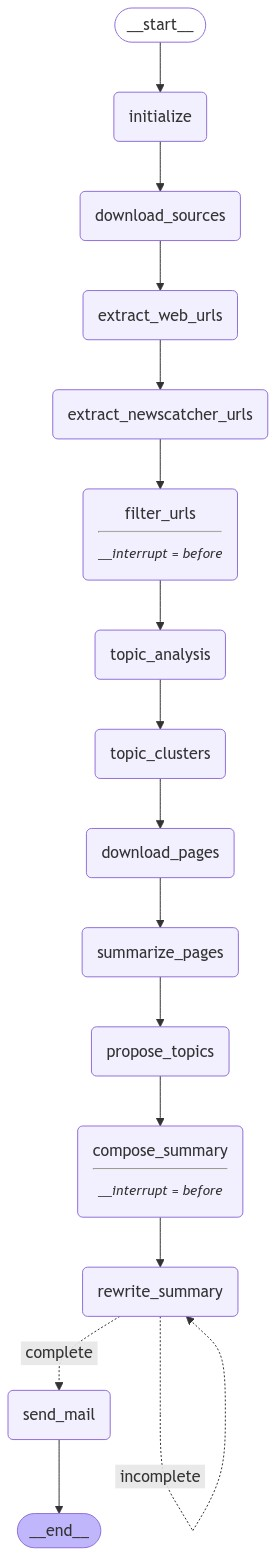

In [37]:
do_download = False
# before_date = None
before_date="2024-10-18 11:00:00"

# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
state["n_edits"] = 0
state["edit_complete"] = False

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [38]:
config


{'configurable': {'thread_id': '7da44215a35245e09c997de014361f84'}}

In [39]:
state


{'before_date': '2024-10-18 11:00:00',
 'do_download': False,
 'n_edits': 0,
 'edit_complete': False}

In [40]:
state = lg_agent.run(state, config)


2024-10-19 13:19:35,423 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-19 13:19:35,423 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-19 13:19:35,424 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-19 13:19:35,424 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-19 13:19:35,424 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-19 13:19:35,425 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-19 13:19:35,425 - AInewsbot - INFO - 

['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']
['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']


2024-10-19 13:19:35,663 - AInewsbot - INFO - parse_file - found 162 raw links
2024-10-19 13:19:35,665 - AInewsbot - INFO - parse_file - found 64 filtered links
2024-10-19 13:19:35,665 - AInewsbot - INFO - 64 links found
2024-10-19 13:19:35,665 - AInewsbot - INFO - Hacker News -> htmldata/Hacker News Page 1 (10_19_2024 12_47_19 PM).html
2024-10-19 13:19:35,676 - AInewsbot - INFO - parse_file - found 261 raw links
2024-10-19 13:19:35,679 - AInewsbot - INFO - parse_file - found 27 filtered links
2024-10-19 13:19:35,680 - AInewsbot - INFO - 27 links found
2024-10-19 13:19:35,680 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker News Page 2 (10_19_2024 12_47_20 PM).html
2024-10-19 13:19:35,690 - AInewsbot - INFO - parse_file - found 255 raw links
2024-10-19 13:19:35,693 - AInewsbot - INFO - parse_file - found 21 filtered links
2024-10-19 13:19:35,693 - AInewsbot - INFO - 21 links found
2024-10-19 13:19:35,694 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (10_19_2024 12_47_30 PM

,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,51
FT Tech,55
Feedly AI,71
Google News,60
Hacker News,27
Hacker News 2,21
HackerNoon,97


2024-10-19 13:19:36,094 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,51
FT Tech,55
Feedly AI,71
Google News,60
Hacker News,27
Hacker News 2,21
HackerNoon,97


In [41]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)


ValueError: int is not allowed for map key when strict_map_key=True

In [61]:
state = lg_agent.run(None, config)


EmptyInputError: Received no input for __start__

In [62]:
for state in lg_agent.graph.get_state_history(config):
    print(state)


In [ ]:
snapshot.count ()



In [ ]:
snapshot = lg_agent.graph.get_state(config)
sna

In [ ]:
events = lg_agent.graph.stream(None, config, stream_mode="values")


In [ ]:
for event in events:
    print(event)

In [ ]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    events = lg_agent.graph.stream(None, config, stream_mode="values")
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()    
else:
    print("Operation cancelled by user.")


In [ ]:
# get last state
last_state = lg_agent.graph.get_state(config)
pd.DataFrame(last_state.values['AIdf'])


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})